# Current development
**Option 1 - Soft physics (not solving ODE)**: Saw a paper that decouple completely the physics part: redesign the PUNN network to predict position directly, to compare with the acceleration that comes from the physical model (therefore defining the loss function). In practice the phy position is from the acc integration (with euler or runge-kutta) This avoids autodiff entirely. Doesnt even have IC/BC loss. (Geng et al., Mo et al.)

~~**Option 2 - Hard physics (solve ODE) but tweak current approach**: Architecturally decouple the time derivative computation from 𝑢(𝑡) by, for instance, constructing a subnetwork that takes only 𝑡 as input for computing derivatives, while 𝑢 is applied externally in the physics loss computation. Two networks: PUNN and PINN but where the PINN is just to leverage tensorflow computational graph and has only t as input.~~ > I think im mistaking forward vs inverse problem here

# Imports

In [ ]:
from scipy.interpolate import interp1d
from scipy .integrate import cumulative_trapezoid
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras import Loss
import seaborn as sns

# Train on single vehicle dynamics

## Constant coefficient car

In [14]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate

        self.X = np.array(x0, dtype=float) #[position, velocity]

        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }

    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""

        # Store history
        self.history['x'].append(self.X[0])
        self.history['v'].append(self.X[1])
        self.history['u'].append(u)


        # Rk4
        k1 = self._dynamics(self.X, u)
        a = k1[1] #gets v_dot = actual acceleration
        self.history["a"].append(a)

        k2 = self._dynamics(self.X + 0.5*dt*k1, u)
        k3 = self._dynamics(self.X + 0.5*dt*k2, u)
        k4 = self._dynamics(self.X + dt*k3, u)

        self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x, v = X
        Fr = (self.c0 + self.c1 * v)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v**2)/2
        Fg = self.m*g*np.sin(self.road_grade)

        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        return np.array([v, a])

## Generate synthetic data

In [15]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
v0 = 20/3.6
x0 = (0, v0) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)

#DEFINE U
t_samp = np.array([0, 40, 100, 200, 250, t_end]) #time check points
u_samp_train = np.array([0, 0.2, 1, 0.4, 0.3, 0.1]) * m # traction force (input from engine)
u = interp1d(t_samp, u_samp_train, kind='linear') #quadratic interpolation -> no drivetrain limitation for now

#generate data:
for t_curr in t:
    car.update(u(t_curr), dt)

# for validation later (different trajectory):

### Simulate measurements (add noise)

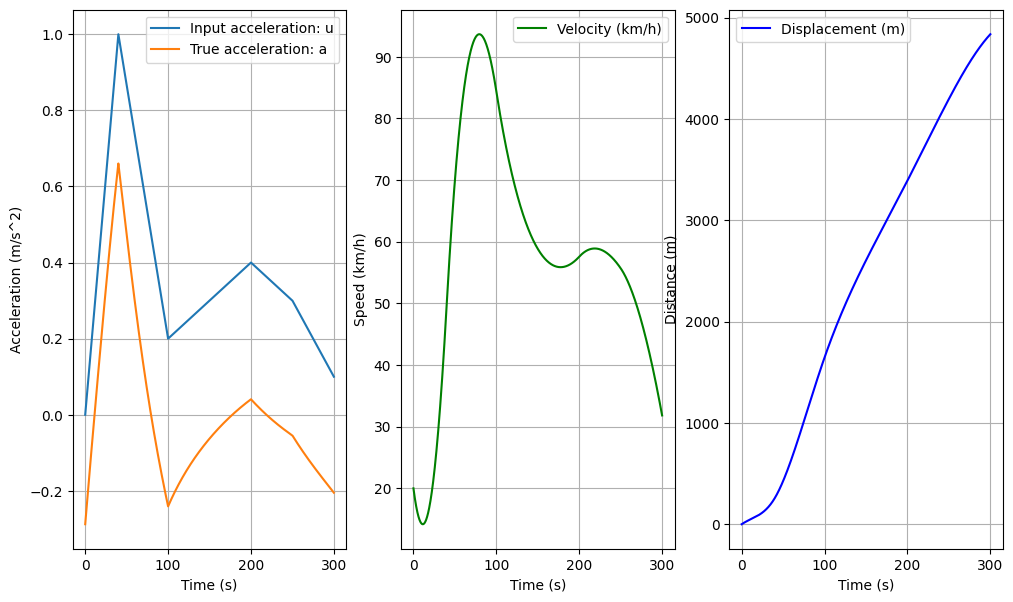

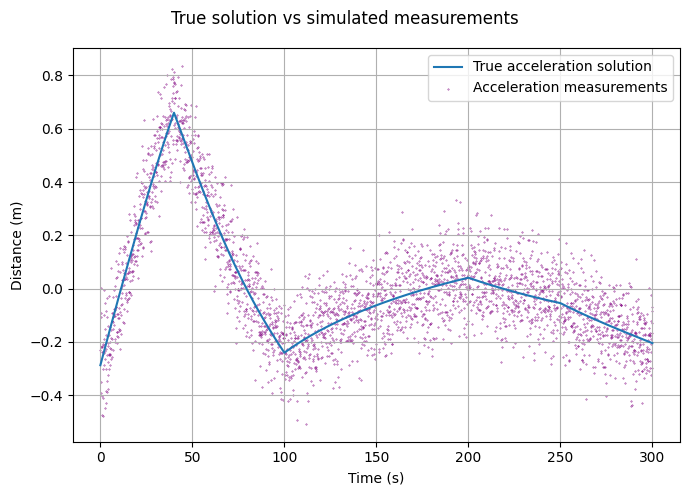

In [16]:
variance = 0.1

Y_true = np.array(car.history["a"]).reshape(-1,1)
Y_noise = Y_true + np.random.normal(0, variance, size=Y_true.shape)
v_true = np.array(car.history["v"]) # in m/s
x_true = np.array(car.history["x"])

fig = plt.figure(figsize=(12,7))
ax=fig.subplots(1,3)

ax[0].plot(t, np.array(car.history["u"])/car.m, label = "Input acceleration: u")
ax[0].plot(t, car.history["a"], label="True acceleration: a")
ax[0].set_ylabel("Acceleration (m/s^2)")

ax[1].plot(t, np.array(car.history["v"])*3.6, label="Velocity (km/h)", color="green")
ax[1].set_ylabel("Speed (km/h)")

ax[2].plot(t, np.array(car.history["x"]), label="Displacement (m)", color="blue")
ax[2].set_ylabel("Distance (m)")

for i in range(len(ax)):
    ax[i].set_xlabel("Time (s)")
    ax[i].legend()
    ax[i].grid()

plt.figure(figsize=(7,5))
plt.suptitle("True solution vs simulated measurements")
plt.plot(t, Y_true, label="True acceleration solution")
plt.scatter(t, Y_noise, label="Acceleration measurements", s=0.1, color="purple")
plt.ylabel("Distance (m)")
plt.grid()
plt.legend()
plt.xlabel("Time (s)")
plt.tight_layout()

## Forward Problem

In [17]:
def comparison_plot(t: np.ndarray, true_data: np.ndarray, meas_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str):
    '''
    true_data: contains acc, vel (in m/s), and pos in (t, 3) shape
    '''

    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12, 8))
    plt.suptitle(suptitle)

    # Plot for acceleration:
    plt.subplot(1, 3, 1)
    plt.plot(t, true_data[:, 0], label="True Acceleration", linewidth=2, color="purple")
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    plt.scatter(t, meas_data, label="Measured acceleration points", s=7, color="red")
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1, 3, 2)
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2) #conversion from m/s to km/h
    for data, label in pred_data:
        plt.plot(t, data[:, 1]*3.6, '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()


    plt.subplot(1, 3, 3)
    plt.plot(t, true_data[:, 2], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 2], '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    stopped_epoch = np.argmin(val_loss) + 1  # Get the epoch with the minimum validation loss

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    # Add a marker for the early stopping epoch
    plt.axvline(x=stopped_epoch, color='r', linestyle='--', label='Early Stopping')
    plt.text(stopped_epoch, val_loss[stopped_epoch - 1], f'({stopped_epoch}, {val_loss[stopped_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()


# Prepping data

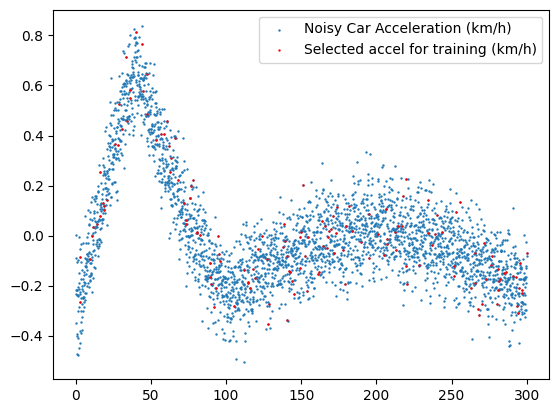

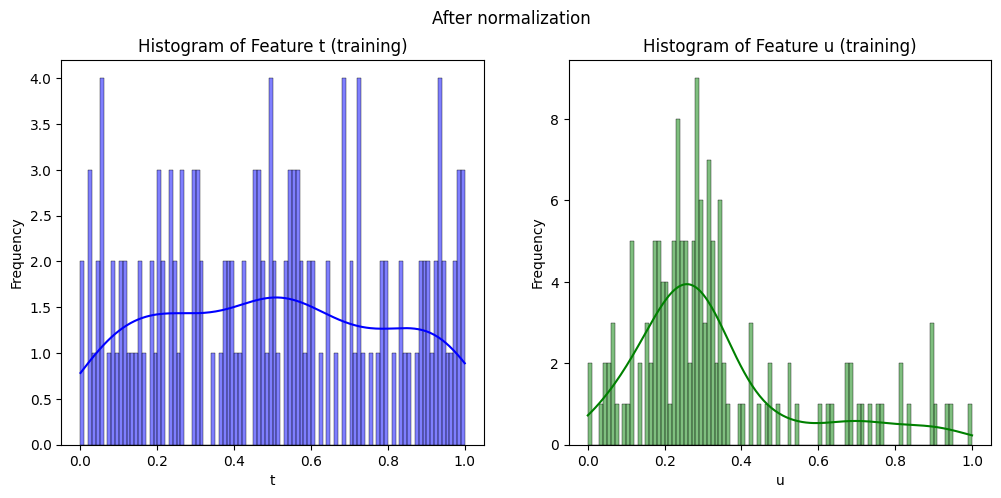

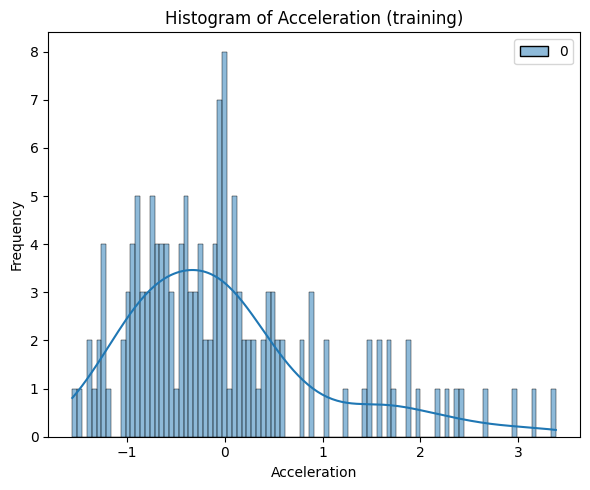

In [18]:
# prepping the data
train_ratio = .05
X = np.stack([t, u(t)], axis=-1) #t and u as features

Y_train, Y_test, X_train, X_test = train_test_split(Y_noise, X, train_size=train_ratio, random_state=31)
#print(Y_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(Y_noise, Y_train)
Y_mask = Y_noise.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_noise, label="Noisy Car Acceleration (km/h)", s=.5)
plt.scatter(t, Y_mask, label="Selected accel for training (km/h)", s=.5, color="red")
plt.legend()
plt.show()

#Prediction Normalization
# if we dont do this, position contributes more to the loss, due to the sheer inbalance of scale
scaler_Y = StandardScaler().fit(Y_train)
Y_train_norm = scaler_Y.transform(Y_train)
Y_test_norm = scaler_Y.transform(Y_test)
Y_true_norm = scaler_Y.transform(Y_true)
y_0_norm = Y_true_norm[0, :]

# feature normalization all based on the training distribution
scaler_X = MinMaxScaler().fit(X_train)
X_train_norm = scaler_X.transform(X_train)
X_test_norm = scaler_X.transform(X_test)
X_norm = scaler_X.transform(X)
x_0_norm = X_norm[0, :]

# Plot histograms for features and outputs using seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("After normalization")

# Plot histograms for features
sns.histplot(X_train_norm[:, 0], bins=100, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Histogram of Feature t (training)')
ax[0].set_xlabel('t')
ax[0].set_ylabel('Frequency')

sns.histplot(X_train_norm[:, 1], bins=100, kde=True, ax=ax[1], color='green')
ax[1].set_title('Histogram of Feature u (training)')
ax[1].set_xlabel('u')
ax[1].set_ylabel('Frequency')

# Plot histogram for output
plt.figure(figsize=(6, 5))
sns.histplot(Y_train_norm, bins=100, kde=True, color='orange')
plt.title('Histogram of Acceleration (training)')
plt.xlabel('Acceleration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# PUNN-only

In [ ]:
#globals
#------
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
batch = 16
metrics = []
opt = Adam(learning_rate=1e-4, weight_decay=1e-3)
loss = "mse"
patience = 50
schedule_tg = 50
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/punn_model_forward.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(2, ))) #input: t,u
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(1, activation="linear")) #output layer -> a^
punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
#with output scaling:
history_punn_fwd = punn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_norm, Y_true_norm),
                                  batch_size=batch, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_punn_fwd.history)

In [ ]:
punn_model.save("models/punn_model_forward.h5")

## PUNN predictions
offline integration for testing, in reality it would be real-time

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Normalized MSE/RMSE for acceleration: 7.18719e-03, 8.47773e-02
MSE/RMSE for acceleration: 5.31021e-04, 2.30439e-02
MSE/RMSE for velocity: 5.37883e-01, 7.33405e-01
MSE/RMSE for position: 2.44176e+03, 4.94142e+01


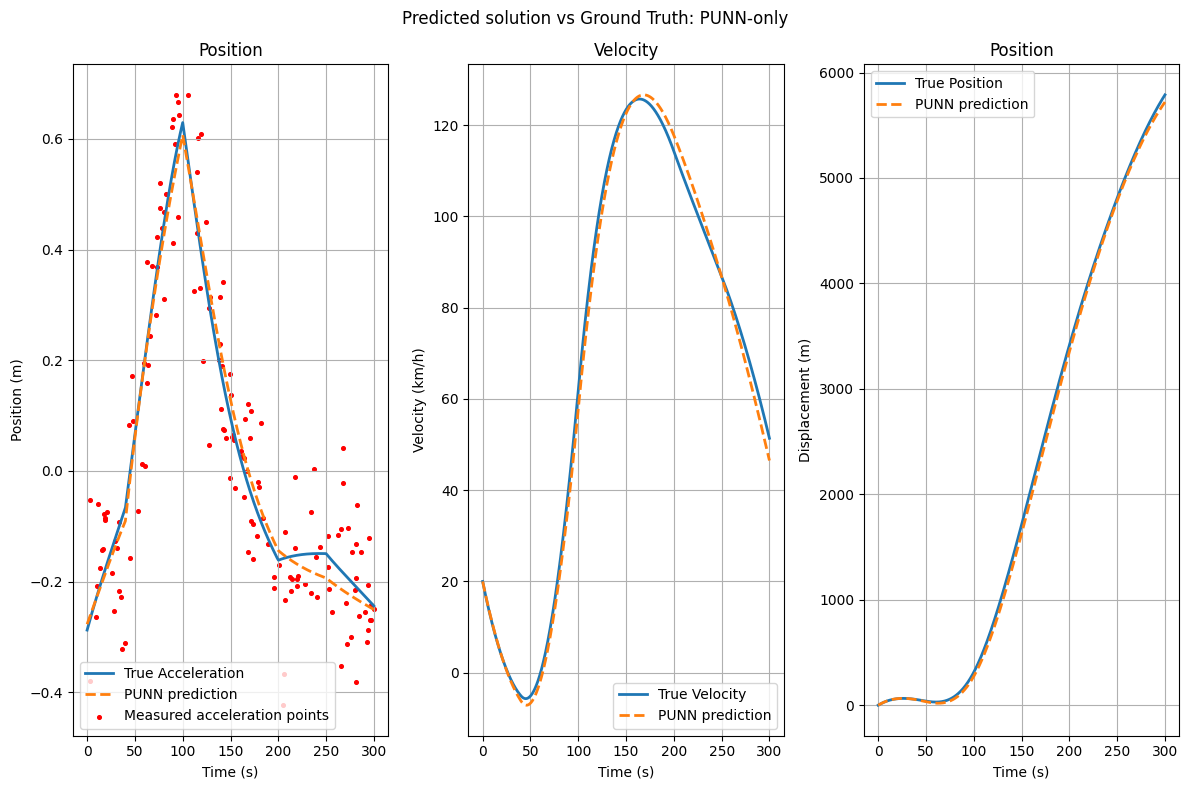

In [ ]:
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
traj_true = np.hstack((Y_true, v_true.reshape(-1,1), x_true.reshape(-1,1))) #shape(t, 3) -> acceleration, velocity (km/h), position

punn_v_phy = np.zeros_like(t)
punn_x_phy = np.zeros_like(t)

#vectorized preodiction offline
punn_a_norm = punn_model.predict(X_norm)
punn_a_phy = scaler_Y.inverse_transform(punn_a_norm).flatten()

punn_v_phy = cumulative_trapezoid(y=punn_a_phy, dx=dt, initial=0)  # Velocity (m/s)
punn_v_phy += x0[1] #add initial condition (m/s)
punn_x_phy = cumulative_trapezoid(y=punn_v_phy, dx=dt, initial=0)  # Position (m)
punn_x_phy += x0[0] #add initial condition (m)

mse_a_norm = mean_squared_error(Y_true_norm, punn_a_norm)
mse_a_phy = mean_squared_error(Y_true, punn_a_phy)
mse_x, mse_v = mean_squared_error(x_true, punn_x_phy), mean_squared_error(v_true, punn_v_phy)

punn_a_phy = punn_a_phy.reshape(-1, 1)
punn_v_phy = punn_v_phy.reshape(-1,1)
punn_x_phy = punn_x_phy.reshape(-1,1)
punn_pred_data = np.hstack((punn_a_phy, punn_v_phy, punn_x_phy))

print(f"Normalized MSE/RMSE for acceleration: {mse_a_norm:.5e}, {np.sqrt(mse_a_norm):.5e}")
print(f"MSE/RMSE for acceleration: {mse_a_phy:.5e}, {np.sqrt(mse_a_phy):.5e}")
print(f"MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
print(f"MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

comparison_plot(t=t, true_data=traj_true, meas_data=Y_mask,
    pred_data=[(punn_pred_data, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only"
)

# PINN

## Combined Loss

In [7]:
def tf_cumulative_trapezoid(y, x):
    """
    Computes cumulative integral using the trapezoidal rule without breaking tensor computational graph
    Both y and x must be 1D tensors of the same length.
    """
    dx = x[1:] - x[:-1]
    areas = 0.5 * (y[1:] + y[:-1]) * dx
    return tf.concat([[0.0], tf.math.cumsum(areas)], axis=0)


In [8]:
collocation_size = len(t) #trying to increase collocation poins for better physics convergence
t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = u(t_c)
X_c = np.stack([t_c, u_c], axis=-1)
X_c_norm = scaler_X.transform(X_c)

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, X_c_norm: np.ndarray, y_0_norm: np.ndarray, x_0_norm: np.ndarray, v0:float,
                 scaler_X: MinMaxScaler, scaler_Y, loss_weights: tuple[float, float, float]):
        super().__init__()
        self.car = car
        self.model = model
        self.alpha_d, self.alpha_p, self.alpha_b = loss_weights

        #IC
        self.y_0_norm = y_0_norm #acc
        self.v0 = v0
        self.x_0_norm = x_0_norm
        self.scaler_Y = scaler_Y
        self.scaler_X = scaler_X

        self.X_c_norm = tf.convert_to_tensor(X_c_norm, dtype=tf.float32)

        X_c_denorm = scaler_X.inverse_transform(X_c_norm)
        self.u_phy = tf.constant(X_c_denorm[:, 1], dtype=tf.float32)  # physical u values for equation
        self.t_c = tf.constant(X_c_denorm[:, 0], dtype=tf.float32)

    def data_loss(self, y_true, y_pred):
        sqr_diff = tf.square(y_true - y_pred)
        return tf.reduce_mean(sqr_diff)

    def physics_loss(self):
        g = 9.81
        car = self.car

        a_norm = self.model(self.X_c_norm) #use PUNN to predict on collocation points
        #denormalize
        a_phy = a_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ #denorm
        a_phy = keras.ops.ravel(a_phy) #-> 1D
        v_phy = self.v0 + tf_cumulative_trapezoid(a_phy, self.t_c)

        #resistive forces
        Fr = (car.c0 + car.c1 * v_phy) * (car.m * g * np.cos(car.road_grade))
        Fa = (car.p * car.Cd * car.Af * v_phy**2) / 2
        Fg = car.m * g * np.sin(car.road_grade)

        #physics residuals
        res = car.m * a_phy - (self.u_phy - Fr - Fa - Fg)  # Newton's law
        return tf.reduce_mean(tf.square(res))

    def boundary_loss(self):
        y0_pred = self.model(self.x_0_norm[tf.newaxis, :])
        sqr_diff = tf.square(y0_pred - self.y_0_norm)
        return tf.reduce_mean(sqr_diff)

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()
        bound_loss = self.boundary_loss()

        return (
            self.alpha_d * data_loss +
            self.alpha_p * pde_loss +
            self.alpha_b * bound_loss
        )

## Training

In [9]:
#globals
#------
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
patience = 50
schedule_tg = 200
metrics = ["mse"]
opt = Adam(learning_rate=0.001, weight_decay=1e-3)
batch = 16
alpha_d = 1
alpha_p = 0.1
alpha_b = 1
alpha = alpha_d, alpha_p, alpha_b #weights for different loss components
#------

#PINN
pinn_model = Sequential()
pinn_model.add(Input(shape=(2, ))) #input: t and u
for _ in range(0,n_hid_layers):
    pinn_model.add(Dense(n_neurons, activation=act))
pinn_model.add(Dense(1, activation="linear")) #output layer -> a^
loss = CombinedLoss(car=car, model=pinn_model, X_c_norm=X_c_norm, scaler_X=scaler_X,
                    scaler_Y=scaler_Y, loss_weights=alpha, x_0_norm=x_0_norm, y_0_norm=y_0_norm, v0=x0[1])
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/pinn_model_forward.h5',
    monitor='val_mse', #track mse loss against true trajectory (not custom loss)
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#training
history_pinn_fwd = pinn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_norm,Y_true_norm),
                                  batch_size=batch, epochs=epochs,
                                  callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_pinn_fwd.history)

Epoch 1/2000
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 14749.9375 - mse: 0.8025

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 13945.3672 - mse: 0.7625 - val_loss: 5714.7915 - val_mse: 0.3122 - learning_rate: 0.0010
Epoch 2/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5714.9565 - mse: 0.4762

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 4779.5469 - mse: 0.3802 - val_loss: 3847.3608 - val_mse: 0.1978 - learning_rate: 0.0010
Epoch 3/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3847.6050 - mse: 0.4430

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 3834.9285 - mse: 0.3470 - val_loss: 3199.3298 - val_mse: 0.1766 - learning_rate: 0.0010
Epoch 4/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3199.3906 - mse: 0.2372

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 3046.3059 - mse: 0.2946 - val_loss: 2821.8997 - val_mse: 0.1633 - learning_rate: 0.0010
Epoch 5/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2822.0581 - mse: 0.3214

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2754.9688 - mse: 0.2917 - val_loss: 2484.0049 - val_mse: 0.1408 - learning_rate: 0.0010
Epoch 6/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2484.1602 - mse: 0.2963

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2421.9041 - mse: 0.2555 - val_loss: 2264.0525 - val_mse: 0.1237 - learning_rate: 0.0010
Epoch 7/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2264.3784 - mse: 0.4499

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 2213.9219 - mse: 0.3071 - val_loss: 2067.8701 - val_mse: 0.1143 - learning_rate: 0.0010
Epoch 8/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2068.1226 - mse: 0.3665

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2033.6179 - mse: 0.2795 - val_loss: 1931.2836 - val_mse: 0.1071 - learning_rate: 0.0010
Epoch 9/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1931.4725 - mse: 0.2971

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1903.7539 - mse: 0.2560 - val_loss: 1825.9840 - val_mse: 0.1021 - learning_rate: 0.0010
Epoch 10/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1826.1721 - mse: 0.2899

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 1805.3290 - mse: 0.2525 - val_loss: 1743.9852 - val_mse: 0.0992 - learning_rate: 0.0010
Epoch 11/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1744.1014 - mse: 0.2159

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 1726.8754 - mse: 0.2531 - val_loss: 1672.6123 - val_mse: 0.0966 - learning_rate: 0.0010
Epoch 12/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1672.8132 - mse: 0.2970

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1655.4843 - mse: 0.2440 - val_loss: 1598.8729 - val_mse: 0.0936 - learning_rate: 0.0010
Epoch 13/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1598.9707 - mse: 0.1916

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 1579.6418 - mse: 0.2303 - val_loss: 1514.7627 - val_mse: 0.0895 - learning_rate: 0.0010
Epoch 14/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1514.8516 - mse: 0.1784

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 1492.1461 - mse: 0.2365 - val_loss: 1415.5593 - val_mse: 0.0841 - learning_rate: 0.0010
Epoch 15/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1415.6434 - mse: 0.1683

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 1388.9125 - mse: 0.2335 - val_loss: 1299.2509 - val_mse: 0.0777 - learning_rate: 0.0010
Epoch 16/2000
 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1286.6882 - mse: 0.2327

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 1268.3829 - mse: 0.2257 - val_loss: 1165.4459 - val_mse: 0.0701 - learning_rate: 0.0010
Epoch 17/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1165.6456 - mse: 0.2697

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1130.5814 - mse: 0.2060 - val_loss: 1015.8357 - val_mse: 0.0616 - learning_rate: 0.0010
Epoch 18/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1015.8909 - mse: 0.1174

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 977.9274 - mse: 0.1969 - val_loss: 855.2867 - val_mse: 0.0525 - learning_rate: 0.0010
Epoch 19/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 819.1260 - mse: 0.1772 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 816.1896 - mse: 0.1781 - val_loss: 692.6752 - val_mse: 0.0432 - learning_rate: 0.0010
Epoch 20/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 692.7581 - mse: 0.1257

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 655.1871 - mse: 0.1769 - val_loss: 540.1808 - val_mse: 0.0344 - learning_rate: 0.0010
Epoch 21/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 540.3653 - mse: 0.2190

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 507.3760 - mse: 0.1854 - val_loss: 410.0372 - val_mse: 0.0267 - learning_rate: 0.0010
Epoch 22/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 410.2024 - mse: 0.1920

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 384.1435 - mse: 0.1596 - val_loss: 310.0151 - val_mse: 0.0206 - learning_rate: 0.0010
Epoch 23/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 310.1646 - mse: 0.1703

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 291.7006 - mse: 0.1613 - val_loss: 240.9075 - val_mse: 0.0162 - learning_rate: 0.0010
Epoch 24/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 241.0332 - mse: 0.1420

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 229.2187 - mse: 0.1451 - val_loss: 197.6037 - val_mse: 0.0133 - learning_rate: 0.0010
Epoch 25/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 197.7744 - mse: 0.1840

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 190.7659 - mse: 0.1575 - val_loss: 172.3090 - val_mse: 0.0114 - learning_rate: 0.0010
Epoch 26/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 172.4565 - mse: 0.1588

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 168.4229 - mse: 0.1391 - val_loss: 157.6404 - val_mse: 0.0103 - learning_rate: 0.0010
Epoch 27/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 157.7813 - mse: 0.1512

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 155.3028 - mse: 0.1350 - val_loss: 148.3512 - val_mse: 0.0096 - learning_rate: 0.0010
Epoch 28/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 148.4549 - mse: 0.1133

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 146.7318 - mse: 0.1304 - val_loss: 141.5470 - val_mse: 0.0091 - learning_rate: 0.0010
Epoch 29/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 141.6774 - mse: 0.1394

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 140.2788 - mse: 0.1383 - val_loss: 135.9681 - val_mse: 0.0087 - learning_rate: 0.0010
Epoch 30/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 136.0738 - mse: 0.1144

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 134.8950 - mse: 0.1355 - val_loss: 131.1349 - val_mse: 0.0083 - learning_rate: 0.0010
Epoch 31/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 131.2372 - mse: 0.1106

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 130.2660 - mse: 0.1357 - val_loss: 132.5594 - val_mse: 0.0080 - learning_rate: 0.0010
Epoch 32/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 132.7424 - mse: 0.1910

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 157.6037 - mse: 0.1418 - val_loss: 147.7915 - val_mse: 0.0080 - learning_rate: 0.0010
Epoch 33/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 138.8462 - mse: 0.1490 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 138.3869 - mse: 0.1475 - val_loss: 128.1448 - val_mse: 0.0076 - learning_rate: 0.0010
Epoch 34/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 128.2938 - mse: 0.1567

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 127.0515 - mse: 0.1471 - val_loss: 120.3810 - val_mse: 0.0074 - learning_rate: 0.0010
Epoch 35/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 120.4438 - mse: 0.0702

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 119.0464 - mse: 0.1233 - val_loss: 115.1222 - val_mse: 0.0072 - learning_rate: 0.0010
Epoch 36/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 115.0785 - mse: 0.1416 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 115.0150 - mse: 0.1415 - val_loss: 112.4512 - val_mse: 0.0070 - learning_rate: 0.0010
Epoch 37/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 112.5296 - mse: 0.0853

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 111.6877 - mse: 0.1327 - val_loss: 109.1343 - val_mse: 0.0068 - learning_rate: 0.0010
Epoch 38/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 108.5790 - mse: 0.1252 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 108.5249 - mse: 0.1266 - val_loss: 106.0293 - val_mse: 0.0066 - learning_rate: 0.0010
Epoch 39/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 106.1703 - mse: 0.1478

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 105.5122 - mse: 0.1434 - val_loss: 103.1851 - val_mse: 0.0064 - learning_rate: 0.0010
Epoch 40/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 103.3155 - mse: 0.1368

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 102.6082 - mse: 0.1395 - val_loss: 100.2423 - val_mse: 0.0063 - learning_rate: 0.0010
Epoch 41/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 100.3956 - mse: 0.1596

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 99.6877 - mse: 0.1458 - val_loss: 97.3480 - val_mse: 0.0061 - learning_rate: 0.0010
Epoch 42/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 97.4487 - mse: 0.1067

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 97.0129 - mse: 0.1317 - val_loss: 101.4315 - val_mse: 0.0059 - learning_rate: 0.0010
Epoch 43/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 125.7408 - mse: 0.1579 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 126.9537 - mse: 0.1562 - val_loss: 110.4549 - val_mse: 0.0058 - learning_rate: 0.0010
Epoch 44/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 110.6642 - mse: 0.2150

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 116.2127 - mse: 0.1480 - val_loss: 96.7506 - val_mse: 0.0055 - learning_rate: 0.0010
Epoch 45/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 96.9118 - mse: 0.1667

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 97.4639 - mse: 0.1443 - val_loss: 91.2446 - val_mse: 0.0053 - learning_rate: 0.0010
Epoch 46/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 91.3218 - mse: 0.0825

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 89.5888 - mse: 0.1322 - val_loss: 85.3556 - val_mse: 0.0052 - learning_rate: 0.0010
Epoch 47/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 85.5513 - mse: 0.2008

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 84.5542 - mse: 0.1589 - val_loss: 80.9673 - val_mse: 0.0050 - learning_rate: 0.0010
Epoch 48/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 81.0592 - mse: 0.0969

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 80.7213 - mse: 0.1265 - val_loss: 78.3367 - val_mse: 0.0048 - learning_rate: 0.0010
Epoch 49/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 78.4573 - mse: 0.1254

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 77.6837 - mse: 0.1305 - val_loss: 75.3020 - val_mse: 0.0046 - learning_rate: 0.0010
Epoch 50/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 75.4727 - mse: 0.1753

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 74.8427 - mse: 0.1495 - val_loss: 72.5326 - val_mse: 0.0044 - learning_rate: 0.0010
Epoch 51/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 72.6473 - mse: 0.1191

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 72.0338 - mse: 0.1368 - val_loss: 69.7981 - val_mse: 0.0042 - learning_rate: 0.0010
Epoch 52/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 69.9399 - mse: 0.1460

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 69.2691 - mse: 0.1412 - val_loss: 67.0778 - val_mse: 0.0041 - learning_rate: 0.0010
Epoch 53/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 67.1836 - mse: 0.1099

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 66.8005 - mse: 0.1380 - val_loss: 71.8707 - val_mse: 0.0039 - learning_rate: 0.0010
Epoch 54/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 72.0227 - mse: 0.1560

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 106.5960 - mse: 0.1504 - val_loss: 77.4741 - val_mse: 0.0038 - learning_rate: 0.0010
Epoch 55/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 77.6085 - mse: 0.1382

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 94.7202 - mse: 0.1450 - val_loss: 71.5260 - val_mse: 0.0037 - learning_rate: 0.0010
Epoch 56/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 71.6865 - mse: 0.1642

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 72.4356 - mse: 0.1436 - val_loss: 67.1504 - val_mse: 0.0035 - learning_rate: 0.0010
Epoch 57/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 67.2821 - mse: 0.1352

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 62.6646 - mse: 0.1396 - val_loss: 59.0557 - val_mse: 0.0033 - learning_rate: 0.0010
Epoch 58/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 56.9908 - mse: 0.1359 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 56.9094 - mse: 0.1364 - val_loss: 54.6725 - val_mse: 0.0032 - learning_rate: 0.0010
Epoch 59/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 54.8263 - mse: 0.1570

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 53.7132 - mse: 0.1411 - val_loss: 51.9793 - val_mse: 0.0031 - learning_rate: 0.0010
Epoch 60/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 52.1375 - mse: 0.1612

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 51.3795 - mse: 0.1322 - val_loss: 49.6337 - val_mse: 0.0029 - learning_rate: 0.0010
Epoch 61/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 49.7625 - mse: 0.1317

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 49.3188 - mse: 0.1433 - val_loss: 47.6967 - val_mse: 0.0028 - learning_rate: 0.0010
Epoch 62/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 47.8828 - mse: 0.1889

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 47.4206 - mse: 0.1523 - val_loss: 45.9339 - val_mse: 0.0027 - learning_rate: 0.0010
Epoch 63/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 46.0223 - mse: 0.0910

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 45.6612 - mse: 0.1256 - val_loss: 44.2809 - val_mse: 0.0026 - learning_rate: 0.0010
Epoch 64/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 44.3960 - mse: 0.1176

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 44.0352 - mse: 0.1361 - val_loss: 42.7184 - val_mse: 0.0025 - learning_rate: 0.0010
Epoch 65/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 42.9015 - mse: 0.1856

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 42.5092 - mse: 0.1456 - val_loss: 41.2743 - val_mse: 0.0024 - learning_rate: 0.0010
Epoch 66/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 41.4524 - mse: 0.1805

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 41.1044 - mse: 0.1540 - val_loss: 40.0877 - val_mse: 0.0023 - learning_rate: 0.0010
Epoch 67/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 40.9637 - mse: 0.1525 - val_loss: 66.0394 - val_mse: 0.0024 - learning_rate: 0.0010
Epoch 68/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 98.8030 - mse: 0.1208 - val_loss: 83.5858 - val_mse: 0.0024 - learning_rate: 0.0010
Epoch 69/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 83.6648 - mse: 0.0815

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 70.8141 - mse: 0.1333 - val_loss: 44.2307 - val_mse: 0.0022 - learning_rate: 0.0010
Epoch 70/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 44.3939 - mse: 0.1653

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 46.1955 - mse: 0.1538 - val_loss: 37.0688 - val_mse: 0.0021 - learning_rate: 0.0010
Epoch 71/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 37.2794 - mse: 0.2127

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 38.7550 - mse: 0.1560 - val_loss: 34.9660 - val_mse: 0.0020 - learning_rate: 0.0010
Epoch 72/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 35.0899 - mse: 0.1259

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 35.7576 - mse: 0.1509 - val_loss: 34.6082 - val_mse: 0.0020 - learning_rate: 0.0010
Epoch 73/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 34.8167 - mse: 0.2104

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 34.4725 - mse: 0.1641 - val_loss: 33.8343 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 74/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 33.9911 - mse: 0.1587

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 33.6585 - mse: 0.1473 - val_loss: 32.7864 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 75/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 32.9559 - mse: 0.1713

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 32.8118 - mse: 0.1478 - val_loss: 32.1997 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 76/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32.1958 - mse: 0.1259 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 32.1860 - mse: 0.1274 - val_loss: 31.6262 - val_mse: 0.0018 - learning_rate: 0.0010
Epoch 77/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 31.7735 - mse: 0.1491

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 31.6257 - mse: 0.1358 - val_loss: 31.0963 - val_mse: 0.0018 - learning_rate: 0.0010
Epoch 78/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 31.2365 - mse: 0.1420

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 31.1202 - mse: 0.1420 - val_loss: 30.6182 - val_mse: 0.0018 - learning_rate: 0.0010
Epoch 79/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 30.7029 - mse: 0.0864

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 30.6400 - mse: 0.1280 - val_loss: 30.1949 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 80/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 30.4010 - mse: 0.2078

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 30.2579 - mse: 0.1564 - val_loss: 29.8587 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 81/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 30.1467 - mse: 0.1249 - val_loss: 35.2167 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 82/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 61.4173 - mse: 0.1155 - val_loss: 63.9244 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 83/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 53.7668 - mse: 0.1277 - val_loss: 60.3087 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 84/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 45.3482 - mse: 0.1303 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 44.8451 - mse: 0.1314 - val_loss: 36.7193 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 85/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 36.8443 - mse: 0.1267

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 34.3785 - mse: 0.1423 - val_loss: 29.3788 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 86/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 29.5241 - mse: 0.1469

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 30.1577 - mse: 0.1571 - val_loss: 28.3014 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 87/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 28.3998 - mse: 0.1000

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 28.6677 - mse: 0.1367 - val_loss: 28.4914 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 88/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 28.7030 - mse: 0.2132

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 28.3504 - mse: 0.1472 - val_loss: 27.8502 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 89/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 28.0227 - mse: 0.1741

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 28.0094 - mse: 0.1630 - val_loss: 27.7027 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 90/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 27.8453 - mse: 0.1441

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 27.7677 - mse: 0.1437 - val_loss: 27.4646 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 91/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 27.6963 - mse: 0.2333

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 27.5907 - mse: 0.1667 - val_loss: 27.2961 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 92/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 27.3992 - mse: 0.1046

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 27.4006 - mse: 0.1413 - val_loss: 27.1425 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 93/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 27.2937 - mse: 0.1528

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 27.2569 - mse: 0.1506 - val_loss: 26.9980 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 94/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 27.1713 - mse: 0.1748

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 27.1133 - mse: 0.1512 - val_loss: 26.8583 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 95/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 26.9993 - mse: 0.1425

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 26.9737 - mse: 0.1478 - val_loss: 26.7364 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 96/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 26.8487 - mse: 0.1139

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 26.8703 - mse: 0.1469 - val_loss: 26.9088 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 97/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 28.5862 - mse: 0.1507 - val_loss: 58.1555 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 98/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 89.9412 - mse: 0.1475 - val_loss: 54.8590 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 99/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 54.9901 - mse: 0.1328

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 55.3061 - mse: 0.1360 - val_loss: 28.8494 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 100/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 31.4434 - mse: 0.1388 - val_loss: 32.5002 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 101/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 32.5935 - mse: 0.0949

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 29.4470 - mse: 0.1287 - val_loss: 27.7173 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 102/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 27.8305 - mse: 0.1147

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 27.5947 - mse: 0.1447 - val_loss: 26.1014 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 103/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 26.1966 - mse: 0.0968

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 26.3707 - mse: 0.1514 - val_loss: 26.2405 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 104/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 26.3259 - mse: 0.0869

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 26.2086 - mse: 0.1222 - val_loss: 25.8541 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 105/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.9754 - mse: 0.1541 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 25.9730 - mse: 0.1531 - val_loss: 25.7132 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 106/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 25.9856 - mse: 0.2739

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 25.8670 - mse: 0.1630 - val_loss: 25.6221 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 107/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 25.8087 - mse: 0.1881

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 25.7491 - mse: 0.1497 - val_loss: 25.5203 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 108/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 25.6369 - mse: 0.1181

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 25.6393 - mse: 0.1424 - val_loss: 25.4203 - val_mse: 0.0015 - learning_rate: 0.0010
Epoch 109/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 25.5403 - mse: 0.1215

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 25.5341 - mse: 0.1373 - val_loss: 25.3266 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 110/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 25.5688 - mse: 0.2436

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 25.4734 - mse: 0.1713 - val_loss: 25.2311 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 111/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 25.3786 - mse: 0.1489

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 25.3579 - mse: 0.1508 - val_loss: 25.1393 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 112/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 25.2998 - mse: 0.1619

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 25.2784 - mse: 0.1540 - val_loss: 25.2068 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 113/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 26.4146 - mse: 0.1619 - val_loss: 50.5489 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 114/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 94.9431 - mse: 0.1512 - val_loss: 50.4961 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 115/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 50.6437 - mse: 0.1492

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 60.4865 - mse: 0.1493 - val_loss: 25.6793 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 116/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 32.1751 - mse: 0.1508 - val_loss: 27.5984 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 117/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 27.7347 - mse: 0.1378

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 27.5336 - mse: 0.1437 - val_loss: 27.1198 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 118/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 27.2094 - mse: 0.0910

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 26.0649 - mse: 0.1358 - val_loss: 25.8188 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 119/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 26.0278 - mse: 0.2104

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 25.3718 - mse: 0.1484 - val_loss: 24.6650 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 120/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 24.8305 - mse: 0.1669

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 24.8279 - mse: 0.1437 - val_loss: 24.4408 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 121/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 24.5663 - mse: 0.1269

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 24.5588 - mse: 0.1354 - val_loss: 24.3689 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 122/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 24.5215 - mse: 0.1540

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 24.4733 - mse: 0.1470 - val_loss: 24.2308 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 123/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 24.3971 - mse: 0.1677

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 24.3617 - mse: 0.1546 - val_loss: 24.1357 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 124/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 24.3385 - mse: 0.2042

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 24.2605 - mse: 0.1462 - val_loss: 24.0460 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 125/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 24.1337 - mse: 0.0890

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 24.1516 - mse: 0.1297 - val_loss: 23.9529 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 126/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 24.1601 - mse: 0.2086

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 24.0871 - mse: 0.1580 - val_loss: 23.8610 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 127/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 24.0562 - mse: 0.1965

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 23.9885 - mse: 0.1510 - val_loss: 23.7692 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 128/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 23.8458 - mse: 0.0780

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 23.8749 - mse: 0.1290 - val_loss: 23.6772 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 129/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 23.7535 - mse: 0.0777

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 23.7852 - mse: 0.1314 - val_loss: 23.5852 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 130/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 23.7948 - mse: 0.2110

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 23.7255 - mse: 0.1639 - val_loss: 23.4927 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 131/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 23.5524 - mse: 0.0610

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 23.6024 - mse: 0.1327 - val_loss: 23.4107 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 132/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 23.5921 - mse: 0.1415 - val_loss: 24.9206 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 133/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 39.3894 - mse: 0.1524 - val_loss: 232.3793 - val_mse: 0.0027 - learning_rate: 0.0010
Epoch 134/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 135.2552 - mse: 0.1330 - val_loss: 27.2709 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 135/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 27.3897 - mse: 0.1201

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 42.9005 - mse: 0.1439 - val_loss: 23.2488 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 136/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 23.4279 - mse: 0.1804

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 29.1992 - mse: 0.1491 - val_loss: 23.0565 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 137/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 23.1471 - mse: 0.0919

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 25.2111 - mse: 0.1262 - val_loss: 22.9439 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 138/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 23.0998 - mse: 0.1572

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 23.7656 - mse: 0.1460 - val_loss: 22.9308 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 139/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 23.0633 - mse: 0.1339

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 23.1961 - mse: 0.1380 - val_loss: 22.9194 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 140/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 23.0482 - mse: 0.1301

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 22.9759 - mse: 0.1410 - val_loss: 22.7812 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 141/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 22.9788 - mse: 0.1989

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 22.8489 - mse: 0.1482 - val_loss: 22.5840 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 142/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 22.7038 - mse: 0.1210

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 22.7030 - mse: 0.1378 - val_loss: 22.4834 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 143/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 22.6900 - mse: 0.2080

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 22.5988 - mse: 0.1416 - val_loss: 22.3860 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 144/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 22.4914 - mse: 0.1067

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 22.4848 - mse: 0.1232 - val_loss: 22.2894 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 145/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 22.4953 - mse: 0.2072

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 22.4090 - mse: 0.1444 - val_loss: 22.1932 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 146/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 22.2985 - mse: 0.1066

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 22.3072 - mse: 0.1379 - val_loss: 22.0981 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 147/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 22.2726 - mse: 0.1758

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 22.2261 - mse: 0.1520 - val_loss: 22.0029 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 148/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 22.1021 - mse: 0.1004

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 22.1088 - mse: 0.1302 - val_loss: 21.9070 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 149/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 22.0297 - mse: 0.1240

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 22.0276 - mse: 0.1449 - val_loss: 21.8108 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 150/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 21.9082 - mse: 0.0987

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 21.9171 - mse: 0.1307 - val_loss: 21.7143 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 151/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 21.8450 - mse: 0.1320

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 21.8364 - mse: 0.1467 - val_loss: 21.6173 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 152/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 21.7700 - mse: 0.1538

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 21.7359 - mse: 0.1430 - val_loss: 21.5214 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 153/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 21.6288 - mse: 0.1086

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 21.6234 - mse: 0.1224 - val_loss: 21.4872 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 154/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 21.9059 - mse: 0.1524 - val_loss: 27.6951 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 155/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 55.7616 - mse: 0.1293 - val_loss: 114.0967 - val_mse: 0.0018 - learning_rate: 0.0010
Epoch 156/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 65.8203 - mse: 0.1539 - val_loss: 39.4059 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 157/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 39.5885 - mse: 0.1839

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 39.4102 - mse: 0.1490 - val_loss: 21.1198 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 158/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 24.8634 - mse: 0.1687 - val_loss: 23.2547 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 159/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 23.4391 - mse: 0.1856

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 22.5569 - mse: 0.1439 - val_loss: 22.5589 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 160/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 22.7661 - mse: 0.2084

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 21.9408 - mse: 0.1596 - val_loss: 20.9307 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 161/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 21.0435 - mse: 0.1140

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 21.1848 - mse: 0.1449 - val_loss: 20.8540 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 162/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.9291 - mse: 0.1559 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 20.9253 - mse: 0.1548 - val_loss: 20.6571 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 163/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 20.8887 - mse: 0.2328

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 20.8100 - mse: 0.1706 - val_loss: 20.5528 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 164/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 20.7594 - mse: 0.2077

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 20.6575 - mse: 0.1430 - val_loss: 20.4283 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 165/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 20.5018 - mse: 0.0747

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 20.5317 - mse: 0.1259 - val_loss: 20.3304 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 166/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 20.5148 - mse: 0.1856

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 20.4534 - mse: 0.1466 - val_loss: 20.2323 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 167/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 20.3763 - mse: 0.1451

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 20.3498 - mse: 0.1420 - val_loss: 20.1341 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 168/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 20.2316 - mse: 0.0986

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 20.2367 - mse: 0.1272 - val_loss: 20.0358 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 169/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 20.1990 - mse: 0.1643

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 20.1570 - mse: 0.1458 - val_loss: 19.9380 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 170/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.0622 - mse: 0.1470 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 20.0601 - mse: 0.1467 - val_loss: 19.8400 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 171/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 19.9244 - mse: 0.0856

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 19.9483 - mse: 0.1331 - val_loss: 19.7413 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 172/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.8747 - mse: 0.1563 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 19.8717 - mse: 0.1551 - val_loss: 19.6429 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 173/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 19.7802 - mse: 0.1384

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 19.7590 - mse: 0.1405 - val_loss: 19.5495 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 174/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 19.6115 - mse: 0.0631

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 19.6819 - mse: 0.1252 - val_loss: 20.2619 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 175/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 29.0560 - mse: 0.1260 - val_loss: 183.7869 - val_mse: 0.0020 - learning_rate: 0.0010
Epoch 176/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 160.8077 - mse: 0.1526 - val_loss: 26.8022 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 177/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 38.6095 - mse: 0.1526 - val_loss: 23.0878 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 178/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 23.2065 - mse: 0.1198

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 26.1691 - mse: 0.1396 - val_loss: 19.6095 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 179/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 19.7579 - mse: 0.1495

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 21.6965 - mse: 0.1550 - val_loss: 19.1046 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 180/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 19.2760 - mse: 0.1725

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 20.0999 - mse: 0.1442 - val_loss: 19.0012 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 181/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 19.1935 - mse: 0.1934

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 19.4461 - mse: 0.1521 - val_loss: 18.9255 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 182/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 19.0732 - mse: 0.1487

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 19.1386 - mse: 0.1482 - val_loss: 18.8608 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 183/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 18.9818 - mse: 0.1221

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 18.9733 - mse: 0.1414 - val_loss: 18.7688 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 184/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.8845 - mse: 0.1596 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 18.8808 - mse: 0.1581 - val_loss: 18.6486 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 185/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 18.7487 - mse: 0.1011

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 18.7572 - mse: 0.1372 - val_loss: 18.5408 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 186/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 18.6365 - mse: 0.0968

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 18.6626 - mse: 0.1422 - val_loss: 18.4531 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 187/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 18.5681 - mse: 0.1161

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 18.5651 - mse: 0.1356 - val_loss: 18.3617 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 188/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 18.5445 - mse: 0.1839

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 18.4903 - mse: 0.1509 - val_loss: 18.2728 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 189/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 18.4638 - mse: 0.1920

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 18.4021 - mse: 0.1517 - val_loss: 18.1840 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 190/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 18.2928 - mse: 0.1098

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 18.3081 - mse: 0.1463 - val_loss: 18.0957 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 191/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 18.2628 - mse: 0.1681

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 18.2230 - mse: 0.1494 - val_loss: 18.0080 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 192/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 18.1214 - mse: 0.1144

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 18.1183 - mse: 0.1324 - val_loss: 17.9206 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 193/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 17.9903 - mse: 0.0708

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 18.0207 - mse: 0.1221 - val_loss: 17.8332 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 194/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 18.0436 - mse: 0.2115

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 17.9762 - mse: 0.1649 - val_loss: 17.7464 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 195/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.8528 - mse: 0.1268 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 17.8528 - mse: 0.1283 - val_loss: 17.6599 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 196/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 17.7963 - mse: 0.1374

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 17.7754 - mse: 0.1373 - val_loss: 17.5737 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 197/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.7099 - mse: 0.1560 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 17.7072 - mse: 0.1549 - val_loss: 17.4912 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 198/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 17.6504 - mse: 0.1602

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 17.6234 - mse: 0.1421 - val_loss: 17.6159 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 199/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 19.0007 - mse: 0.1408 - val_loss: 45.2114 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 200/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 36.4987 - mse: 0.1332 - val_loss: 23.3091 - val_mse: 0.0010 - learning_rate: 9.0000e-04
Epoch 201/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 23.3874 - mse: 0.0794

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 23.4071 - mse: 0.1350 - val_loss: 18.0121 - val_mse: 9.9173e-04 - learning_rate: 9.0000e-04
Epoch 202/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 18.1121 - mse: 0.1010

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 19.0633 - mse: 0.1313 - val_loss: 17.1077 - val_mse: 9.8481e-04 - learning_rate: 9.0000e-04
Epoch 203/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 17.2832 - mse: 0.1765

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 17.6969 - mse: 0.1493 - val_loss: 17.2319 - val_mse: 9.8287e-04 - learning_rate: 9.0000e-04
Epoch 204/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 17.4032 - mse: 0.1723

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 17.3289 - mse: 0.1517 - val_loss: 17.1705 - val_mse: 9.7882e-04 - learning_rate: 9.0000e-04
Epoch 205/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 17.2451 - mse: 0.0756

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 17.1687 - mse: 0.1202 - val_loss: 16.9116 - val_mse: 9.7285e-04 - learning_rate: 9.0000e-04
Epoch 206/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 17.0066 - mse: 0.0960

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 17.0342 - mse: 0.1307 - val_loss: 16.8265 - val_mse: 9.6800e-04 - learning_rate: 9.0000e-04
Epoch 207/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 16.9608 - mse: 0.1353

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 16.9601 - mse: 0.1562 - val_loss: 16.7456 - val_mse: 9.6390e-04 - learning_rate: 9.0000e-04
Epoch 208/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 16.8235 - mse: 0.0789

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 16.8613 - mse: 0.1344 - val_loss: 16.6701 - val_mse: 9.5999e-04 - learning_rate: 9.0000e-04
Epoch 209/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 16.8061 - mse: 0.1369

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 16.7970 - mse: 0.1461 - val_loss: 16.5955 - val_mse: 9.5573e-04 - learning_rate: 9.0000e-04
Epoch 210/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16.7023 - mse: 0.1233 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 16.7028 - mse: 0.1251 - val_loss: 16.5232 - val_mse: 9.5158e-04 - learning_rate: 9.0000e-04
Epoch 211/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 16.7278 - mse: 0.2056

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 16.6558 - mse: 0.1508 - val_loss: 16.4511 - val_mse: 9.4754e-04 - learning_rate: 9.0000e-04
Epoch 212/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 16.5422 - mse: 0.0920

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 16.5804 - mse: 0.1476 - val_loss: 16.3792 - val_mse: 9.4344e-04 - learning_rate: 9.0000e-04
Epoch 213/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 16.5683 - mse: 0.1900

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 16.5100 - mse: 0.1490 - val_loss: 16.3076 - val_mse: 9.3938e-04 - learning_rate: 9.0000e-04
Epoch 214/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.4308 - mse: 0.1400 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 16.4298 - mse: 0.1403 - val_loss: 16.2363 - val_mse: 9.3531e-04 - learning_rate: 9.0000e-04
Epoch 215/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 16.4806 - mse: 0.2452

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 16.3882 - mse: 0.1700 - val_loss: 16.1651 - val_mse: 9.3129e-04 - learning_rate: 9.0000e-04
Epoch 216/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.2992 - mse: 0.1507 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 16.2973 - mse: 0.1501 - val_loss: 16.0943 - val_mse: 9.2727e-04 - learning_rate: 9.0000e-04
Epoch 217/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 16.2482 - mse: 0.1547

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 16.2260 - mse: 0.1494 - val_loss: 16.0241 - val_mse: 9.2325e-04 - learning_rate: 9.0000e-04
Epoch 218/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 16.2026 - mse: 0.1793

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 16.1616 - mse: 0.1546 - val_loss: 15.9653 - val_mse: 9.1911e-04 - learning_rate: 9.0000e-04
Epoch 219/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 16.1513 - mse: 0.1411 - val_loss: 17.2818 - val_mse: 9.2084e-04 - learning_rate: 9.0000e-04
Epoch 220/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 27.9922 - mse: 0.1346 - val_loss: 158.4208 - val_mse: 0.0017 - learning_rate: 9.0000e-04
Epoch 221/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 117.0936 - mse: 0.1456 - val_loss: 19.1905 - val_mse: 9.3560e-04 - learning_rate: 9.0000e-04
Epoch 222/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 29.0255 - mse: 0.1572 - val_loss: 23.8053 - val_mse: 9.6378e-04 - learning_rate: 9.0000e-04
Epoch 223/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 21.3536 - mse: 0.1462 - val_loss: 20.2870 - val_mse: 9.3934e-04 - learning_rate: 9.0000e-04
Epoch 224/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 18.2034 - mse: 0.1351 - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 16.8482 - mse: 0.1556 - val_loss: 16.3491 - val_mse: 9.0717e-04 - learning_rate: 9.0000e-04
Epoch 226/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 16.5137 - mse: 0.1655

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 16.1788 - mse: 0.1540 - val_loss: 15.6393 - val_mse: 8.9842e-04 - learning_rate: 9.0000e-04
Epoch 227/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 15.7376 - mse: 0.0992

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 15.7980 - mse: 0.1391 - val_loss: 15.4904 - val_mse: 8.9328e-04 - learning_rate: 9.0000e-04
Epoch 228/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 15.6268 - mse: 0.1373

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 15.6374 - mse: 0.1454 - val_loss: 15.4571 - val_mse: 8.8955e-04 - learning_rate: 9.0000e-04
Epoch 229/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.5596 - mse: 0.1364 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 15.5586 - mse: 0.1370 - val_loss: 15.3544 - val_mse: 8.8606e-04 - learning_rate: 9.0000e-04
Epoch 230/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 15.4926 - mse: 0.1390

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 15.4868 - mse: 0.1445 - val_loss: 15.2967 - val_mse: 8.8271e-04 - learning_rate: 9.0000e-04
Epoch 231/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 15.3888 - mse: 0.0930

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 15.4081 - mse: 0.1302 - val_loss: 15.2283 - val_mse: 8.7887e-04 - learning_rate: 9.0000e-04
Epoch 232/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 15.3278 - mse: 0.1004

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 15.3386 - mse: 0.1257 - val_loss: 15.1661 - val_mse: 8.7529e-04 - learning_rate: 9.0000e-04
Epoch 233/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.2911 - mse: 0.1395 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 15.2903 - mse: 0.1399 - val_loss: 15.1039 - val_mse: 8.7182e-04 - learning_rate: 9.0000e-04
Epoch 234/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 15.1967 - mse: 0.0937

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 15.2306 - mse: 0.1426 - val_loss: 15.0418 - val_mse: 8.6821e-04 - learning_rate: 9.0000e-04
Epoch 235/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.1812 - mse: 0.1540 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 15.1791 - mse: 0.1531 - val_loss: 14.9799 - val_mse: 8.6471e-04 - learning_rate: 9.0000e-04
Epoch 236/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 15.1433 - mse: 0.1642

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 15.1121 - mse: 0.1479 - val_loss: 14.9182 - val_mse: 8.6117e-04 - learning_rate: 9.0000e-04
Epoch 237/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.0370 - mse: 0.1333 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 15.0368 - mse: 0.1342 - val_loss: 14.8568 - val_mse: 8.5765e-04 - learning_rate: 9.0000e-04
Epoch 238/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 15.0207 - mse: 0.1648

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 14.9871 - mse: 0.1459 - val_loss: 14.7955 - val_mse: 8.5420e-04 - learning_rate: 9.0000e-04
Epoch 239/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 15.0140 - mse: 0.2194

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 14.9341 - mse: 0.1540 - val_loss: 14.7349 - val_mse: 8.5074e-04 - learning_rate: 9.0000e-04
Epoch 240/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 14.8223 - mse: 0.0882

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 14.8434 - mse: 0.1228 - val_loss: 14.6915 - val_mse: 8.4763e-04 - learning_rate: 9.0000e-04
Epoch 241/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 14.8707 - mse: 0.1295 - val_loss: 15.8383 - val_mse: 8.5357e-04 - learning_rate: 9.0000e-04
Epoch 242/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 22.7923 - mse: 0.1540 - val_loss: 130.3905 - val_mse: 0.0016 - learning_rate: 9.0000e-04
Epoch 243/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 106.9642 - mse: 0.1463 - val_loss: 52.2593 - val_mse: 0.0010 - learning_rate: 9.0000e-04
Epoch 244/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 33.6811 - mse: 0.1435 - val_loss: 25.9055 - val_mse: 8.9920e-04 - learning_rate: 9.0000e-04
Epoch 245/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 26.0311 - mse: 0.1265

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 23.3435 - mse: 0.1413 - val_loss: 14.6707 - val_mse: 8.3775e-04 - learning_rate: 9.0000e-04
Epoch 246/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 16.4989 - mse: 0.1568 - val_loss: 15.3442 - val_mse: 8.4205e-04 - learning_rate: 9.0000e-04
Epoch 247/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 15.4741 - mse: 0.1307

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 15.1731 - mse: 0.1376 - val_loss: 15.1060 - val_mse: 8.3750e-04 - learning_rate: 9.0000e-04
Epoch 248/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 15.3056 - mse: 0.2005

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 14.9351 - mse: 0.1505 - val_loss: 14.3197 - val_mse: 8.2805e-04 - learning_rate: 9.0000e-04
Epoch 249/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 14.4790 - mse: 0.1601

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 14.5415 - mse: 0.1562 - val_loss: 14.3633 - val_mse: 8.2452e-04 - learning_rate: 9.0000e-04
Epoch 250/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 14.4252 - mse: 0.0627

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 14.4337 - mse: 0.1334 - val_loss: 14.2066 - val_mse: 8.2142e-04 - learning_rate: 9.0000e-04
Epoch 251/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 14.3811 - mse: 0.1753

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 14.3475 - mse: 0.1466 - val_loss: 14.1582 - val_mse: 8.1835e-04 - learning_rate: 9.0000e-04
Epoch 252/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 14.3318 - mse: 0.1744

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 14.2991 - mse: 0.1562 - val_loss: 14.0993 - val_mse: 8.1468e-04 - learning_rate: 9.0000e-04
Epoch 253/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 14.2655 - mse: 0.1671

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 14.2346 - mse: 0.1525 - val_loss: 14.0388 - val_mse: 8.1170e-04 - learning_rate: 9.0000e-04
Epoch 254/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 14.2101 - mse: 0.1720

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 14.1698 - mse: 0.1465 - val_loss: 13.9814 - val_mse: 8.0828e-04 - learning_rate: 9.0000e-04
Epoch 255/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 14.0934 - mse: 0.1128

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 14.0966 - mse: 0.1298 - val_loss: 13.9246 - val_mse: 8.0519e-04 - learning_rate: 9.0000e-04
Epoch 256/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 14.0966 - mse: 0.1729

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 14.0703 - mse: 0.1600 - val_loss: 13.8686 - val_mse: 8.0192e-04 - learning_rate: 9.0000e-04
Epoch 257/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 13.9793 - mse: 0.1115

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 13.9899 - mse: 0.1354 - val_loss: 13.8128 - val_mse: 7.9874e-04 - learning_rate: 9.0000e-04
Epoch 258/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 14.0026 - mse: 0.1906

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 13.9452 - mse: 0.1466 - val_loss: 13.7579 - val_mse: 7.9565e-04 - learning_rate: 9.0000e-04
Epoch 259/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 13.8631 - mse: 0.1060

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 13.8684 - mse: 0.1236 - val_loss: 13.7092 - val_mse: 7.9264e-04 - learning_rate: 9.0000e-04
Epoch 260/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.8627 - mse: 0.1565 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 13.8621 - mse: 0.1553 - val_loss: 13.8369 - val_mse: 7.9133e-04 - learning_rate: 9.0000e-04
Epoch 261/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 14.7965 - mse: 0.1568 - val_loss: 30.4088 - val_mse: 8.9597e-04 - learning_rate: 9.0000e-04
Epoch 262/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 65.0330 - mse: 0.1361 - val_loss: 17.5019 - val_mse: 8.1274e-04 - learning_rate: 9.0000e-04
Epoch 263/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 31.2145 - mse: 0.1398 - val_loss: 39.8877 - val_mse: 9.5350e-04 - learning_rate: 9.0000e-04
Epoch 264/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 27.6184 - mse: 0.1447 - val_loss: 15.1256 - val_mse: 7.9506e-04 - learning_rate: 9.0000e-04
Epoch 265/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 15.2870 - mse: 0.1621

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 17.1432 - mse: 0.1458 - val_loss: 14.4376 - val_mse: 7.8430e-04 - learning_rate: 9.0000e-04
Epoch 266/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 14.5553 - mse: 0.1185

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 14.4515 - mse: 0.1375 - val_loss: 14.5307 - val_mse: 7.8228e-04 - learning_rate: 9.0000e-04
Epoch 267/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 14.6973 - mse: 0.1674

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 14.2116 - mse: 0.1583 - val_loss: 13.3815 - val_mse: 7.7503e-04 - learning_rate: 9.0000e-04
Epoch 268/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 13.4791 - mse: 0.0984

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 13.6220 - mse: 0.1362 - val_loss: 13.4873 - val_mse: 7.7375e-04 - learning_rate: 9.0000e-04
Epoch 269/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 13.6246 - mse: 0.1380

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 13.5383 - mse: 0.1359 - val_loss: 13.2850 - val_mse: 7.6876e-04 - learning_rate: 9.0000e-04
Epoch 270/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 13.4656 - mse: 0.1814

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 13.4277 - mse: 0.1512 - val_loss: 13.2304 - val_mse: 7.6573e-04 - learning_rate: 9.0000e-04
Epoch 271/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.3531 - mse: 0.1312 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 13.3531 - mse: 0.1323 - val_loss: 13.1801 - val_mse: 7.6306e-04 - learning_rate: 9.0000e-04
Epoch 272/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 13.4073 - mse: 0.2280

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 13.3096 - mse: 0.1455 - val_loss: 13.1229 - val_mse: 7.5968e-04 - learning_rate: 9.0000e-04
Epoch 273/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 13.3062 - mse: 0.1841

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 13.2633 - mse: 0.1550 - val_loss: 13.0694 - val_mse: 7.5689e-04 - learning_rate: 9.0000e-04
Epoch 274/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 13.2531 - mse: 0.1844

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 13.2069 - mse: 0.1514 - val_loss: 13.0158 - val_mse: 7.5375e-04 - learning_rate: 9.0000e-04
Epoch 275/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 13.2071 - mse: 0.1920

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 13.1615 - mse: 0.1589 - val_loss: 12.9632 - val_mse: 7.5080e-04 - learning_rate: 9.0000e-04
Epoch 276/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 13.0771 - mse: 0.1147

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 13.0953 - mse: 0.1453 - val_loss: 12.9115 - val_mse: 7.4786e-04 - learning_rate: 9.0000e-04
Epoch 277/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 13.1205 - mse: 0.2097

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 13.0501 - mse: 0.1521 - val_loss: 12.8591 - val_mse: 7.4483e-04 - learning_rate: 9.0000e-04
Epoch 278/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.9819 - mse: 0.1351 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 12.9817 - mse: 0.1358 - val_loss: 12.8070 - val_mse: 7.4182e-04 - learning_rate: 9.0000e-04
Epoch 279/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 13.0202 - mse: 0.2139

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 12.9447 - mse: 0.1505 - val_loss: 12.7599 - val_mse: 7.3875e-04 - learning_rate: 9.0000e-04
Epoch 280/2000
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.9194 - mse: 0.1575 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 12.9220 - mse: 0.1550 - val_loss: 13.1631 - val_mse: 7.3712e-04 - learning_rate: 9.0000e-04
Epoch 281/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 17.1041 - mse: 0.1527 - val_loss: 95.2704 - val_mse: 0.0012 - learning_rate: 9.0000e-04
Epoch 282/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 121.9788 - mse: 0.1371 - val_loss: 87.6923 - val_mse: 0.0012 - learning_rate: 9.0000e-04
Epoch 283/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 47.8841 - mse: 0.1279 - val_loss: 35.4681 - val_mse: 8.8056e-04 - learning_rate: 9.0000e-04
Epoch 284/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 25.6235 - mse: 0.1530 - val_loss: 19.4258 - val_mse: 7.7867e-04 - learning_rate: 9.0000e-04
Epoch 285/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 17.1686 - mse: 0.1560 - val_loss: 14.5029 - val_mse: 7.4508e-04 - learning_rate: 9.0000e-04
Epoch 286/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 14.6023 - mse: 0.1001

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 14.2238 - mse: 0.1466 - val_loss: 12.9067 - val_mse: 7.3156e-04 - learning_rate: 9.0000e-04
Epoch 287/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 13.2228 - mse: 0.3168

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 13.1774 - mse: 0.1750 - val_loss: 12.5038 - val_mse: 7.2543e-04 - learning_rate: 9.0000e-04
Epoch 288/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12.6481 - mse: 0.1450

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 12.7569 - mse: 0.1535 - val_loss: 12.4857 - val_mse: 7.2210e-04 - learning_rate: 9.0000e-04
Epoch 289/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12.5746 - mse: 0.0897

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 12.6150 - mse: 0.1428 - val_loss: 12.4475 - val_mse: 7.1920e-04 - learning_rate: 9.0000e-04
Epoch 290/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 12.5934 - mse: 0.1465

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 12.5538 - mse: 0.1428 - val_loss: 12.3536 - val_mse: 7.1639e-04 - learning_rate: 9.0000e-04
Epoch 291/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12.4707 - mse: 0.1178

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 12.4889 - mse: 0.1450 - val_loss: 12.3041 - val_mse: 7.1381e-04 - learning_rate: 9.0000e-04
Epoch 292/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12.4653 - mse: 0.1619

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 12.4306 - mse: 0.1408 - val_loss: 12.2516 - val_mse: 7.1085e-04 - learning_rate: 9.0000e-04
Epoch 293/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12.4692 - mse: 0.2184

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 12.4078 - mse: 0.1684 - val_loss: 12.2023 - val_mse: 7.0789e-04 - learning_rate: 9.0000e-04
Epoch 294/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 12.3327 - mse: 0.1312

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 12.3174 - mse: 0.1279 - val_loss: 12.1527 - val_mse: 7.0513e-04 - learning_rate: 9.0000e-04
Epoch 295/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 12.2463 - mse: 0.0943

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 12.2694 - mse: 0.1292 - val_loss: 12.1035 - val_mse: 7.0228e-04 - learning_rate: 9.0000e-04
Epoch 296/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12.2485 - mse: 0.1457

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 12.2350 - mse: 0.1440 - val_loss: 12.0545 - val_mse: 6.9945e-04 - learning_rate: 9.0000e-04
Epoch 297/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12.2509 - mse: 0.1971

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 12.1934 - mse: 0.1514 - val_loss: 12.0053 - val_mse: 6.9665e-04 - learning_rate: 9.0000e-04
Epoch 298/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 12.0898 - mse: 0.0852

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 12.1221 - mse: 0.1292 - val_loss: 11.9562 - val_mse: 6.9381e-04 - learning_rate: 9.0000e-04
Epoch 299/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12.1239 - mse: 0.1684

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 12.0854 - mse: 0.1417 - val_loss: 11.9071 - val_mse: 6.9099e-04 - learning_rate: 9.0000e-04
Epoch 300/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12.0008 - mse: 0.0944

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 12.0241 - mse: 0.1296 - val_loss: 11.8584 - val_mse: 6.8821e-04 - learning_rate: 9.0000e-04
Epoch 301/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 11.9847 - mse: 0.1271

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 11.9832 - mse: 0.1365 - val_loss: 11.8139 - val_mse: 6.8553e-04 - learning_rate: 9.0000e-04
Epoch 302/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 11.9894 - mse: 0.1762

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.9562 - mse: 0.1517 - val_loss: 11.8012 - val_mse: 6.8321e-04 - learning_rate: 9.0000e-04
Epoch 303/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 12.0421 - mse: 0.1525 - val_loss: 13.3628 - val_mse: 6.9228e-04 - learning_rate: 9.0000e-04
Epoch 304/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 20.1172 - mse: 0.1380 - val_loss: 108.1430 - val_mse: 0.0013 - learning_rate: 9.0000e-04
Epoch 305/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 90.1463 - mse: 0.1588 - val_loss: 50.6974 - val_mse: 8.8968e-04 - learning_rate: 9.0000e-04
Epoch 306/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 50.8935 - mse: 0.1970

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 32.6538 - mse: 0.1479 - val_loss: 11.9338 - val_mse: 6.7765e-04 - learning_rate: 9.0000e-04
Epoch 307/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 16.0253 - mse: 0.1594 - val_loss: 15.9968 - val_mse: 7.0501e-04 - learning_rate: 9.0000e-04
Epoch 308/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 16.1389 - mse: 0.1428

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 13.9093 - mse: 0.1531 - val_loss: 11.9506 - val_mse: 6.7587e-04 - learning_rate: 9.0000e-04
Epoch 309/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.4297 - mse: 0.1330 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 12.4204 - mse: 0.1339 - val_loss: 12.0605 - val_mse: 6.7126e-04 - learning_rate: 9.0000e-04
Epoch 310/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12.1923 - mse: 0.1325

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 11.9238 - mse: 0.1440 - val_loss: 11.4768 - val_mse: 6.6675e-04 - learning_rate: 9.0000e-04
Epoch 311/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 11.7141 - mse: 0.2381

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 11.7002 - mse: 0.1657 - val_loss: 11.4986 - val_mse: 6.6510e-04 - learning_rate: 9.0000e-04
Epoch 312/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 11.7246 - mse: 0.2266

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 11.6349 - mse: 0.1673 - val_loss: 11.4124 - val_mse: 6.6119e-04 - learning_rate: 9.0000e-04
Epoch 313/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 11.5126 - mse: 0.1009

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 11.5141 - mse: 0.1300 - val_loss: 11.3425 - val_mse: 6.5887e-04 - learning_rate: 9.0000e-04
Epoch 314/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.4642 - mse: 0.1385 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 11.4637 - mse: 0.1389 - val_loss: 11.2884 - val_mse: 6.5571e-04 - learning_rate: 9.0000e-04
Epoch 315/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 11.3853 - mse: 0.0976

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.4145 - mse: 0.1404 - val_loss: 11.2386 - val_mse: 6.5317e-04 - learning_rate: 9.0000e-04
Epoch 316/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.3564 - mse: 0.1296 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.3567 - mse: 0.1309 - val_loss: 11.1884 - val_mse: 6.5029e-04 - learning_rate: 9.0000e-04
Epoch 317/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 11.3277 - mse: 0.1399

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.3250 - mse: 0.1480 - val_loss: 11.1422 - val_mse: 6.4749e-04 - learning_rate: 9.0000e-04
Epoch 318/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.2845 - mse: 0.1538 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 11.2827 - mse: 0.1529 - val_loss: 11.0933 - val_mse: 6.4475e-04 - learning_rate: 9.0000e-04
Epoch 319/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 11.1848 - mse: 0.0921

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 11.2022 - mse: 0.1210 - val_loss: 11.0469 - val_mse: 6.4195e-04 - learning_rate: 9.0000e-04
Epoch 320/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.1880 - mse: 0.1468 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 11.1877 - mse: 0.1465 - val_loss: 11.0947 - val_mse: 6.3921e-04 - learning_rate: 9.0000e-04
Epoch 321/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 11.6338 - mse: 0.1639 - val_loss: 18.3888 - val_mse: 6.7445e-04 - learning_rate: 9.0000e-04
Epoch 322/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 45.1120 - mse: 0.1615 - val_loss: 75.2329 - val_mse: 9.9140e-04 - learning_rate: 9.0000e-04
Epoch 323/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 44.3297 - mse: 0.1617 - val_loss: 20.2838 - val_mse: 6.8411e-04 - learning_rate: 9.0000e-04
Epoch 324/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 24.7362 - mse: 0.1493 - val_loss: 13.1128 - val_mse: 6.5043e-04 - learning_rate: 9.0000e-04
Epoch 325/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 13.7805 - mse: 0.1464 - val_loss: 14.7359 - val_mse: 6.5935e-04 - learning_rate: 9.0000e-04
Epoch 326/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 14.8737 - mse: 0.1385

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 12.9480 - mse: 0.1464 - val_loss: 11.2337 - val_mse: 6.3396e-04 - learning_rate: 9.0000e-04
Epoch 327/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 11.3543 - mse: 0.1213

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 11.5724 - mse: 0.1458 - val_loss: 11.0079 - val_mse: 6.2813e-04 - learning_rate: 9.0000e-04
Epoch 328/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 11.1334 - mse: 0.1261

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 11.0568 - mse: 0.1377 - val_loss: 10.8473 - val_mse: 6.2503e-04 - learning_rate: 9.0000e-04
Epoch 329/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.9913 - mse: 0.1446

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 10.9594 - mse: 0.1376 - val_loss: 10.7321 - val_mse: 6.2296e-04 - learning_rate: 9.0000e-04
Epoch 330/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10.8727 - mse: 0.1412

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.8295 - mse: 0.1286 - val_loss: 10.6436 - val_mse: 6.1965e-04 - learning_rate: 9.0000e-04
Epoch 331/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10.7861 - mse: 0.1431

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 10.7742 - mse: 0.1352 - val_loss: 10.6032 - val_mse: 6.1679e-04 - learning_rate: 9.0000e-04
Epoch 332/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 10.7793 - mse: 0.1768

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.7299 - mse: 0.1401 - val_loss: 10.5545 - val_mse: 6.1438e-04 - learning_rate: 9.0000e-04
Epoch 333/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.7199 - mse: 0.1661

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.6805 - mse: 0.1395 - val_loss: 10.5062 - val_mse: 6.1144e-04 - learning_rate: 9.0000e-04
Epoch 334/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.6061 - mse: 0.1004

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 10.6363 - mse: 0.1429 - val_loss: 10.4580 - val_mse: 6.0890e-04 - learning_rate: 9.0000e-04
Epoch 335/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10.6089 - mse: 0.1515

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.5856 - mse: 0.1396 - val_loss: 10.4109 - val_mse: 6.0615e-04 - learning_rate: 9.0000e-04
Epoch 336/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10.5426 - mse: 0.1323

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.5290 - mse: 0.1299 - val_loss: 10.3644 - val_mse: 6.0347e-04 - learning_rate: 9.0000e-04
Epoch 337/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.5526 - mse: 0.1889

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 10.5194 - mse: 0.1668 - val_loss: 10.3179 - val_mse: 6.0078e-04 - learning_rate: 9.0000e-04
Epoch 338/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 10.4540 - mse: 0.1367

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.4574 - mse: 0.1513 - val_loss: 10.2713 - val_mse: 5.9806e-04 - learning_rate: 9.0000e-04
Epoch 339/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 10.3863 - mse: 0.1156

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 10.3861 - mse: 0.1264 - val_loss: 10.2261 - val_mse: 5.9533e-04 - learning_rate: 9.0000e-04
Epoch 340/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.3470 - mse: 0.1214

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 10.3582 - mse: 0.1412 - val_loss: 10.2290 - val_mse: 5.9257e-04 - learning_rate: 9.0000e-04
Epoch 341/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 10.6594 - mse: 0.1532 - val_loss: 16.7597 - val_mse: 6.2372e-04 - learning_rate: 9.0000e-04
Epoch 342/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 48.9177 - mse: 0.1474 - val_loss: 78.6306 - val_mse: 9.7022e-04 - learning_rate: 9.0000e-04
Epoch 343/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 47.9730 - mse: 0.1679 - val_loss: 41.0805 - val_mse: 7.5778e-04 - learning_rate: 9.0000e-04
Epoch 344/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 30.9882 - mse: 0.1519 - val_loss: 15.1633 - val_mse: 6.1446e-04 - learning_rate: 9.0000e-04
Epoch 345/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 15.2831 - mse: 0.1205

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 16.2575 - mse: 0.1254 - val_loss: 10.4738 - val_mse: 5.8900e-04 - learning_rate: 9.0000e-04
Epoch 346/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 10.6540 - mse: 0.1807

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 11.8815 - mse: 0.1536 - val_loss: 10.0825 - val_mse: 5.8633e-04 - learning_rate: 9.0000e-04
Epoch 347/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.2118 - mse: 0.1300

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.6075 - mse: 0.1384 - val_loss: 10.2955 - val_mse: 5.8596e-04 - learning_rate: 9.0000e-04
Epoch 348/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 10.4407 - mse: 0.1458

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 10.3229 - mse: 0.1513 - val_loss: 10.1661 - val_mse: 5.8264e-04 - learning_rate: 9.0000e-04
Epoch 349/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 10.3111 - mse: 0.1456

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.2034 - mse: 0.1499 - val_loss: 9.9243 - val_mse: 5.7820e-04 - learning_rate: 9.0000e-04
Epoch 350/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.1313 - mse: 0.2076

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 10.0835 - mse: 0.1561 - val_loss: 9.8754 - val_mse: 5.7508e-04 - learning_rate: 9.0000e-04
Epoch 351/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.0344 - mse: 0.1596

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 10.0040 - mse: 0.1442 - val_loss: 9.8242 - val_mse: 5.7253e-04 - learning_rate: 9.0000e-04
Epoch 352/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 9.9432 - mse: 0.1196

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.9473 - mse: 0.1352 - val_loss: 9.7754 - val_mse: 5.7018e-04 - learning_rate: 9.0000e-04
Epoch 353/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.9320 - mse: 0.1572

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 9.9088 - mse: 0.1456 - val_loss: 9.7290 - val_mse: 5.6751e-04 - learning_rate: 9.0000e-04
Epoch 354/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 9.9093 - mse: 0.1809

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 9.8825 - mse: 0.1645 - val_loss: 9.6849 - val_mse: 5.6486e-04 - learning_rate: 9.0000e-04
Epoch 355/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 9.8186 - mse: 0.1343

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 9.8185 - mse: 0.1451 - val_loss: 9.6399 - val_mse: 5.6232e-04 - learning_rate: 9.0000e-04
Epoch 356/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 9.7748 - mse: 0.1355

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.7818 - mse: 0.1532 - val_loss: 9.5953 - val_mse: 5.5973e-04 - learning_rate: 9.0000e-04
Epoch 357/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 9.7864 - mse: 0.1917

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 9.7277 - mse: 0.1436 - val_loss: 9.5506 - val_mse: 5.5717e-04 - learning_rate: 9.0000e-04
Epoch 358/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.6821 - mse: 0.1321

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.6907 - mse: 0.1512 - val_loss: 9.5063 - val_mse: 5.5463e-04 - learning_rate: 9.0000e-04
Epoch 359/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.6064 - mse: 0.1007

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.6398 - mse: 0.1449 - val_loss: 9.4614 - val_mse: 5.5202e-04 - learning_rate: 9.0000e-04
Epoch 360/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.5727 - mse: 0.1119

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.5764 - mse: 0.1263 - val_loss: 9.4168 - val_mse: 5.4941e-04 - learning_rate: 9.0000e-04
Epoch 361/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 9.5511 - mse: 0.1349

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.5464 - mse: 0.1406 - val_loss: 9.3726 - val_mse: 5.4682e-04 - learning_rate: 9.0000e-04
Epoch 362/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 9.5694 - mse: 0.1974

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 9.5151 - mse: 0.1534 - val_loss: 9.3331 - val_mse: 5.4415e-04 - learning_rate: 9.0000e-04
Epoch 363/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 9.4556 - mse: 0.1231

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.4882 - mse: 0.1487 - val_loss: 9.5743 - val_mse: 5.4237e-04 - learning_rate: 9.0000e-04
Epoch 364/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 11.1446 - mse: 0.1431 - val_loss: 38.2547 - val_mse: 6.9770e-04 - learning_rate: 9.0000e-04
Epoch 365/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 78.2650 - mse: 0.1475 - val_loss: 18.3934 - val_mse: 6.0022e-04 - learning_rate: 9.0000e-04
Epoch 366/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 35.7703 - mse: 0.1369 - val_loss: 22.9533 - val_mse: 6.1128e-04 - learning_rate: 9.0000e-04
Epoch 367/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 17.1706 - mse: 0.1470 - val_loss: 17.1448 - val_mse: 5.8027e-04 - learning_rate: 9.0000e-04
Epoch 368/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 17.3099 - mse: 0.1656

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 13.8399 - mse: 0.1558 - val_loss: 10.0170 - val_mse: 5.4002e-04 - learning_rate: 9.0000e-04
Epoch 369/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 10.0934 - mse: 0.0770

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 10.5856 - mse: 0.1288 - val_loss: 9.3148 - val_mse: 5.3579e-04 - learning_rate: 9.0000e-04
Epoch 370/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 9.4329 - mse: 0.1186

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.5159 - mse: 0.1197 - val_loss: 9.4918 - val_mse: 5.3499e-04 - learning_rate: 9.0000e-04
Epoch 371/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.6061 - mse: 0.1149

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 9.4333 - mse: 0.1373 - val_loss: 9.0553 - val_mse: 5.2918e-04 - learning_rate: 9.0000e-04
Epoch 372/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.2282 - mse: 0.1734

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 9.2395 - mse: 0.1528 - val_loss: 9.0646 - val_mse: 5.2651e-04 - learning_rate: 9.0000e-04
Epoch 373/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.1346 - mse: 0.0706

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.1621 - mse: 0.1340 - val_loss: 8.9696 - val_mse: 5.2419e-04 - learning_rate: 9.0000e-04
Epoch 374/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.1805 - mse: 0.2114

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 9.1209 - mse: 0.1587 - val_loss: 8.9283 - val_mse: 5.2173e-04 - learning_rate: 9.0000e-04
Epoch 375/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.9754 - mse: 0.0477

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.0398 - mse: 0.1215 - val_loss: 8.8859 - val_mse: 5.1908e-04 - learning_rate: 9.0000e-04
Epoch 376/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.0119 - mse: 0.1266

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 9.0189 - mse: 0.1447 - val_loss: 8.8422 - val_mse: 5.1679e-04 - learning_rate: 9.0000e-04
Epoch 377/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.0153 - mse: 0.1736

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.9764 - mse: 0.1455 - val_loss: 8.7986 - val_mse: 5.1422e-04 - learning_rate: 9.0000e-04
Epoch 378/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.9475 - mse: 0.1494

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.9307 - mse: 0.1429 - val_loss: 8.7558 - val_mse: 5.1179e-04 - learning_rate: 9.0000e-04
Epoch 379/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.9012 - mse: 0.1458

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 8.8974 - mse: 0.1523 - val_loss: 8.7135 - val_mse: 5.0933e-04 - learning_rate: 9.0000e-04
Epoch 380/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.8579 - mse: 0.1449

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 8.8523 - mse: 0.1495 - val_loss: 8.6710 - val_mse: 5.0688e-04 - learning_rate: 9.0000e-04
Epoch 381/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.8524 - mse: 0.1819

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.7975 - mse: 0.1372 - val_loss: 8.6285 - val_mse: 5.0441e-04 - learning_rate: 9.0000e-04
Epoch 382/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.7893 - mse: 0.1612

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 8.7723 - mse: 0.1544 - val_loss: 8.5861 - val_mse: 5.0194e-04 - learning_rate: 9.0000e-04
Epoch 383/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.7288 - mse: 0.1432

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.7175 - mse: 0.1412 - val_loss: 8.5570 - val_mse: 4.9938e-04 - learning_rate: 9.0000e-04
Epoch 384/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 8.7560 - mse: 0.1570 - val_loss: 9.5035 - val_mse: 5.0114e-04 - learning_rate: 9.0000e-04
Epoch 385/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 15.6264 - mse: 0.1297 - val_loss: 105.6522 - val_mse: 0.0010 - learning_rate: 9.0000e-04
Epoch 386/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 105.7812 - mse: 0.1511 - val_loss: 61.8456 - val_mse: 8.3490e-04 - learning_rate: 9.0000e-04
Epoch 387/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 33.8105 - mse: 0.1662 - val_loss: 20.0988 - val_mse: 5.7162e-04 - learning_rate: 9.0000e-04
Epoch 388/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 20.2707 - mse: 0.1725

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 17.9588 - mse: 0.1530 - val_loss: 8.6826 - val_mse: 4.9663e-04 - learning_rate: 9.0000e-04
Epoch 389/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.6366 - mse: 0.1258

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.6422 - mse: 0.1275 - val_loss: 9.0470 - val_mse: 4.9476e-04 - learning_rate: 9.0000e-04
Epoch 390/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 9.1535 - mse: 0.1070

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.1475 - mse: 0.1410 - val_loss: 9.1708 - val_mse: 4.9340e-04 - learning_rate: 9.0000e-04
Epoch 391/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.2827 - mse: 0.1124

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.9191 - mse: 0.1510 - val_loss: 8.4232 - val_mse: 4.8805e-04 - learning_rate: 9.0000e-04
Epoch 392/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.5917 - mse: 0.1690

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.6028 - mse: 0.1494 - val_loss: 8.3415 - val_mse: 4.8633e-04 - learning_rate: 9.0000e-04
Epoch 393/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.4467 - mse: 0.1057

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 8.4710 - mse: 0.1562 - val_loss: 8.2739 - val_mse: 4.8366e-04 - learning_rate: 9.0000e-04
Epoch 394/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.4587 - mse: 0.1852

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 8.4200 - mse: 0.1576 - val_loss: 8.2230 - val_mse: 4.8087e-04 - learning_rate: 9.0000e-04
Epoch 395/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.3384 - mse: 0.1159

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.3350 - mse: 0.1258 - val_loss: 8.1746 - val_mse: 4.7865e-04 - learning_rate: 9.0000e-04
Epoch 396/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.3617 - mse: 0.1876

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.3094 - mse: 0.1436 - val_loss: 8.1364 - val_mse: 4.7642e-04 - learning_rate: 9.0000e-04
Epoch 397/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.2352 - mse: 0.0993

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.2550 - mse: 0.1287 - val_loss: 8.0968 - val_mse: 4.7399e-04 - learning_rate: 9.0000e-04
Epoch 398/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 8.2542 - mse: 0.1578

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.2382 - mse: 0.1518 - val_loss: 8.0564 - val_mse: 4.7179e-04 - learning_rate: 9.0000e-04
Epoch 399/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.1963 - mse: 0.1403

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.1863 - mse: 0.1400 - val_loss: 8.0161 - val_mse: 4.6942e-04 - learning_rate: 9.0000e-04
Epoch 400/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 8.1423 - mse: 0.1266

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 8.1442 - mse: 0.1371 - val_loss: 7.9804 - val_mse: 4.6738e-04 - learning_rate: 8.1000e-04
Epoch 401/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.0788 - mse: 0.0989

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 8.1114 - mse: 0.1400 - val_loss: 7.9450 - val_mse: 4.6532e-04 - learning_rate: 8.1000e-04
Epoch 402/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.0126 - mse: 0.0681

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 8.0823 - mse: 0.1464 - val_loss: 7.9093 - val_mse: 4.6326e-04 - learning_rate: 8.1000e-04
Epoch 403/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0540 - mse: 0.1531 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 8.0525 - mse: 0.1523 - val_loss: 7.8737 - val_mse: 4.6119e-04 - learning_rate: 8.1000e-04
Epoch 404/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.0043 - mse: 0.1311

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.9997 - mse: 0.1350 - val_loss: 7.8380 - val_mse: 4.5914e-04 - learning_rate: 8.1000e-04
Epoch 405/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.9992 - mse: 0.1616

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.9767 - mse: 0.1476 - val_loss: 7.8025 - val_mse: 4.5709e-04 - learning_rate: 8.1000e-04
Epoch 406/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 7.9691 - mse: 0.1671

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 7.9431 - mse: 0.1496 - val_loss: 7.7668 - val_mse: 4.5503e-04 - learning_rate: 8.1000e-04
Epoch 407/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.9133 - mse: 0.1469

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 7.9017 - mse: 0.1438 - val_loss: 7.7312 - val_mse: 4.5297e-04 - learning_rate: 8.1000e-04
Epoch 408/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.9849 - mse: 0.2541

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.8845 - mse: 0.1622 - val_loss: 7.6957 - val_mse: 4.5091e-04 - learning_rate: 8.1000e-04
Epoch 409/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.8345 - mse: 0.1392

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.8280 - mse: 0.1413 - val_loss: 7.6601 - val_mse: 4.4887e-04 - learning_rate: 8.1000e-04
Epoch 410/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.7854 - mse: 0.1258

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.7827 - mse: 0.1316 - val_loss: 7.6245 - val_mse: 4.4680e-04 - learning_rate: 8.1000e-04
Epoch 411/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.7358 - mse: 0.1118

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.7406 - mse: 0.1251 - val_loss: 7.5890 - val_mse: 4.4474e-04 - learning_rate: 8.1000e-04
Epoch 412/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.7472 - mse: 0.1586

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.7348 - mse: 0.1549 - val_loss: 7.5533 - val_mse: 4.4270e-04 - learning_rate: 8.1000e-04
Epoch 413/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 7.6714 - mse: 0.1185

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.6840 - mse: 0.1396 - val_loss: 7.5176 - val_mse: 4.4065e-04 - learning_rate: 8.1000e-04
Epoch 414/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.6191 - mse: 0.1020

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 7.6494 - mse: 0.1408 - val_loss: 7.4821 - val_mse: 4.3857e-04 - learning_rate: 8.1000e-04
Epoch 415/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6241 - mse: 0.1504 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.6229 - mse: 0.1498 - val_loss: 7.4465 - val_mse: 4.3657e-04 - learning_rate: 8.1000e-04
Epoch 416/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 7.6680 - mse: 0.2220

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 7.6099 - mse: 0.1724 - val_loss: 7.4107 - val_mse: 4.3451e-04 - learning_rate: 8.1000e-04
Epoch 417/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.5485 - mse: 0.1383

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 7.5492 - mse: 0.1474 - val_loss: 7.3752 - val_mse: 4.3246e-04 - learning_rate: 8.1000e-04
Epoch 418/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.4986 - mse: 0.1238

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 7.5044 - mse: 0.1381 - val_loss: 7.3396 - val_mse: 4.3038e-04 - learning_rate: 8.1000e-04
Epoch 419/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.3823 - mse: 0.0432

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 7.4580 - mse: 0.1274 - val_loss: 7.3040 - val_mse: 4.2834e-04 - learning_rate: 8.1000e-04
Epoch 420/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.4383 - mse: 0.1348

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.4311 - mse: 0.1361 - val_loss: 7.2684 - val_mse: 4.2632e-04 - learning_rate: 8.1000e-04
Epoch 421/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.4159 - mse: 0.1480

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 7.4105 - mse: 0.1511 - val_loss: 7.2332 - val_mse: 4.2422e-04 - learning_rate: 8.1000e-04
Epoch 422/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.3840 - mse: 0.1512

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 7.3669 - mse: 0.1419 - val_loss: 7.2074 - val_mse: 4.2210e-04 - learning_rate: 8.1000e-04
Epoch 423/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 7.3631 - mse: 0.1306 - val_loss: 7.7436 - val_mse: 4.2228e-04 - learning_rate: 8.1000e-04
Epoch 424/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 10.8488 - mse: 0.1574 - val_loss: 59.0163 - val_mse: 7.0730e-04 - learning_rate: 8.1000e-04
Epoch 425/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 77.7778 - mse: 0.1441 - val_loss: 50.1505 - val_mse: 6.9324e-04 - learning_rate: 8.1000e-04
Epoch 426/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 50.2489 - mse: 0.0991

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 34.3126 - mse: 0.1380 - val_loss: 7.1338 - val_mse: 4.1826e-04 - learning_rate: 8.1000e-04
Epoch 427/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 11.6449 - mse: 0.1373 - val_loss: 10.8979 - val_mse: 4.3646e-04 - learning_rate: 8.1000e-04
Epoch 428/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 9.2477 - mse: 0.1463 - val_loss: 8.7661 - val_mse: 4.2307e-04 - learning_rate: 8.1000e-04
Epoch 429/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 8.9217 - mse: 0.1560

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 8.3144 - mse: 0.1454 - val_loss: 7.0401 - val_mse: 4.1338e-04 - learning_rate: 8.1000e-04
Epoch 430/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 7.3635 - mse: 0.1235 - val_loss: 7.2483 - val_mse: 4.1391e-04 - learning_rate: 8.1000e-04
Epoch 431/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.3786 - mse: 0.1307

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.2499 - mse: 0.1311 - val_loss: 6.9830 - val_mse: 4.0996e-04 - learning_rate: 8.1000e-04
Epoch 432/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.1779 - mse: 0.1953

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 7.1613 - mse: 0.1610 - val_loss: 6.9778 - val_mse: 4.0777e-04 - learning_rate: 8.1000e-04
Epoch 433/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1191 - mse: 0.1647 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 7.1161 - mse: 0.1628 - val_loss: 6.9135 - val_mse: 4.0611e-04 - learning_rate: 8.1000e-04
Epoch 434/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.0958 - mse: 0.1828

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 7.0456 - mse: 0.1405 - val_loss: 6.8786 - val_mse: 4.0415e-04 - learning_rate: 8.1000e-04
Epoch 435/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0202 - mse: 0.1481 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.0192 - mse: 0.1478 - val_loss: 6.8466 - val_mse: 4.0223e-04 - learning_rate: 8.1000e-04
Epoch 436/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 7.0198 - mse: 0.1736

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.9972 - mse: 0.1585 - val_loss: 6.8144 - val_mse: 4.0043e-04 - learning_rate: 8.1000e-04
Epoch 437/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.9872 - mse: 0.1732

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.9534 - mse: 0.1469 - val_loss: 6.7819 - val_mse: 3.9850e-04 - learning_rate: 8.1000e-04
Epoch 438/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.9498 - mse: 0.1683

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.9402 - mse: 0.1662 - val_loss: 6.7501 - val_mse: 3.9665e-04 - learning_rate: 8.1000e-04
Epoch 439/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.8754 - mse: 0.1257

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 6.8754 - mse: 0.1335 - val_loss: 6.7180 - val_mse: 3.9482e-04 - learning_rate: 8.1000e-04
Epoch 440/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.8170 - mse: 0.0993

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.8440 - mse: 0.1339 - val_loss: 6.6868 - val_mse: 3.9303e-04 - learning_rate: 8.1000e-04
Epoch 441/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.9296 - mse: 0.2432

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.8381 - mse: 0.1594 - val_loss: 6.6547 - val_mse: 3.9118e-04 - learning_rate: 8.1000e-04
Epoch 442/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.7849 - mse: 0.1307

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.7810 - mse: 0.1344 - val_loss: 6.6232 - val_mse: 3.8933e-04 - learning_rate: 8.1000e-04
Epoch 443/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.7011 - mse: 0.0784

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.7480 - mse: 0.1317 - val_loss: 6.6097 - val_mse: 3.8779e-04 - learning_rate: 8.1000e-04
Epoch 444/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 6.8114 - mse: 0.1308 - val_loss: 8.1667 - val_mse: 3.9735e-04 - learning_rate: 8.1000e-04
Epoch 445/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 17.5761 - mse: 0.1605 - val_loss: 135.7208 - val_mse: 0.0012 - learning_rate: 8.1000e-04
Epoch 446/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 87.7285 - mse: 0.1423 - val_loss: 17.6233 - val_mse: 4.4542e-04 - learning_rate: 8.1000e-04
Epoch 447/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 17.0256 - mse: 0.1437 - val_loss: 19.2666 - val_mse: 4.5313e-04 - learning_rate: 8.1000e-04
Epoch 448/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 13.0763 - mse: 0.1589 - val_loss: 10.1813 - val_mse: 4.0180e-04 - learning_rate: 8.1000e-04
Epoch 449/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2720 - mse: 0.1356  

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 9.2062 - mse: 0.1364 - val_loss: 6.7013 - val_mse: 3.8244e-04 - learning_rate: 8.1000e-04
Epoch 450/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.7998 - mse: 0.0990

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.2459 - mse: 0.1373 - val_loss: 6.5995 - val_mse: 3.8178e-04 - learning_rate: 8.1000e-04
Epoch 451/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.7315 - mse: 0.1325

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.7663 - mse: 0.1564 - val_loss: 6.6525 - val_mse: 3.8066e-04 - learning_rate: 8.1000e-04
Epoch 452/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.7430 - mse: 0.0908

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.6643 - mse: 0.1244 - val_loss: 6.4104 - val_mse: 3.7703e-04 - learning_rate: 8.1000e-04
Epoch 453/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.5591 - mse: 0.1491

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.5623 - mse: 0.1386 - val_loss: 6.3982 - val_mse: 3.7508e-04 - learning_rate: 8.1000e-04
Epoch 454/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.4593 - mse: 0.0615

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.5201 - mse: 0.1411 - val_loss: 6.3453 - val_mse: 3.7349e-04 - learning_rate: 8.1000e-04
Epoch 455/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.4925 - mse: 0.1476

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.4780 - mse: 0.1372 - val_loss: 6.3186 - val_mse: 3.7189e-04 - learning_rate: 8.1000e-04
Epoch 456/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.4793 - mse: 0.1610

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.4554 - mse: 0.1447 - val_loss: 6.2883 - val_mse: 3.7007e-04 - learning_rate: 8.1000e-04
Epoch 457/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.4266 - mse: 0.1386

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 6.4316 - mse: 0.1510 - val_loss: 6.2590 - val_mse: 3.6846e-04 - learning_rate: 8.1000e-04
Epoch 458/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.4122 - mse: 0.1536

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.3904 - mse: 0.1387 - val_loss: 6.2301 - val_mse: 3.6677e-04 - learning_rate: 8.1000e-04
Epoch 459/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 6.3934 - mse: 0.1637

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.3766 - mse: 0.1535 - val_loss: 6.2019 - val_mse: 3.6515e-04 - learning_rate: 8.1000e-04
Epoch 460/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.3171 - mse: 0.1155

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.3360 - mse: 0.1415 - val_loss: 6.1735 - val_mse: 3.6342e-04 - learning_rate: 8.1000e-04
Epoch 461/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.3035 - mse: 0.1304

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.2971 - mse: 0.1310 - val_loss: 6.1447 - val_mse: 3.6181e-04 - learning_rate: 8.1000e-04
Epoch 462/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2805 - mse: 0.1424 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 6.2801 - mse: 0.1426 - val_loss: 6.1163 - val_mse: 3.6016e-04 - learning_rate: 8.1000e-04
Epoch 463/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.2712 - mse: 0.1553

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.2530 - mse: 0.1436 - val_loss: 6.0892 - val_mse: 3.5846e-04 - learning_rate: 8.1000e-04
Epoch 464/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.2432 - mse: 0.1543

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.2247 - mse: 0.1419 - val_loss: 6.0656 - val_mse: 3.5679e-04 - learning_rate: 8.1000e-04
Epoch 465/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.2291 - mse: 0.1638

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.2084 - mse: 0.1426 - val_loss: 6.1365 - val_mse: 3.5536e-04 - learning_rate: 8.1000e-04
Epoch 466/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.6298 - mse: 0.1474 - val_loss: 12.1873 - val_mse: 3.8614e-04 - learning_rate: 8.1000e-04
Epoch 467/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 31.4561 - mse: 0.1360 - val_loss: 63.3804 - val_mse: 6.7510e-04 - learning_rate: 8.1000e-04
Epoch 468/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 34.9454 - mse: 0.1557 - val_loss: 6.9238 - val_mse: 3.5653e-04 - learning_rate: 8.1000e-04
Epoch 469/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 13.6588 - mse: 0.1317 - val_loss: 13.0604 - val_mse: 3.9902e-04 - learning_rate: 8.1000e-04
Epoch 470/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.5890 - mse: 0.1462 - val_loss: 7.1414 - val_mse: 3.5973e-04 - learning_rate: 8.1000e-04
Epoch 471/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.3530 - mse: 0.2120

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.4948 - mse: 0.1601 - val_loss: 6.4113 - val_mse: 3.5146e-04 - learning_rate: 8.1000e-04
Epoch 472/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3929 - mse: 0.1547 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.3898 - mse: 0.1538 - val_loss: 6.1011 - val_mse: 3.4849e-04 - learning_rate: 8.1000e-04
Epoch 473/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.2115 - mse: 0.1107

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.2364 - mse: 0.1404 - val_loss: 5.9907 - val_mse: 3.4774e-04 - learning_rate: 8.1000e-04
Epoch 474/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.1174 - mse: 0.1270

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.0658 - mse: 0.1374 - val_loss: 5.8524 - val_mse: 3.4504e-04 - learning_rate: 8.1000e-04
Epoch 475/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.9558 - mse: 0.1037

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.0087 - mse: 0.1485 - val_loss: 5.8351 - val_mse: 3.4337e-04 - learning_rate: 8.1000e-04
Epoch 476/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.9921 - mse: 0.1573

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.9721 - mse: 0.1424 - val_loss: 5.8050 - val_mse: 3.4210e-04 - learning_rate: 8.1000e-04
Epoch 477/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.9677 - mse: 0.1630

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.9458 - mse: 0.1493 - val_loss: 5.7755 - val_mse: 3.4039e-04 - learning_rate: 8.1000e-04
Epoch 478/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.0640 - mse: 0.2888

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.9374 - mse: 0.1692 - val_loss: 5.7488 - val_mse: 3.3895e-04 - learning_rate: 8.1000e-04
Epoch 479/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.9296 - mse: 0.1812

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.9028 - mse: 0.1608 - val_loss: 5.7221 - val_mse: 3.3737e-04 - learning_rate: 8.1000e-04
Epoch 480/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.8642 - mse: 0.1425

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.8561 - mse: 0.1404 - val_loss: 5.6963 - val_mse: 3.3587e-04 - learning_rate: 8.1000e-04
Epoch 481/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.8164 - mse: 0.1204

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 5.8202 - mse: 0.1305 - val_loss: 5.6705 - val_mse: 3.3437e-04 - learning_rate: 8.1000e-04
Epoch 482/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8216 - mse: 0.1570 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.8200 - mse: 0.1559 - val_loss: 5.6459 - val_mse: 3.3284e-04 - learning_rate: 8.1000e-04
Epoch 483/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.8492 - mse: 0.2036

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 5.7942 - mse: 0.1535 - val_loss: 5.6301 - val_mse: 3.3129e-04 - learning_rate: 8.1000e-04
Epoch 484/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.8285 - mse: 0.1987

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.7937 - mse: 0.1477 - val_loss: 5.9321 - val_mse: 3.3101e-04 - learning_rate: 8.1000e-04
Epoch 485/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 7.3472 - mse: 0.1529 - val_loss: 27.3343 - val_mse: 4.4901e-04 - learning_rate: 8.1000e-04
Epoch 486/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 53.7194 - mse: 0.1321 - val_loss: 5.9922 - val_mse: 3.3193e-04 - learning_rate: 8.1000e-04
Epoch 487/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 19.7289 - mse: 0.1460 - val_loss: 21.7944 - val_mse: 4.1570e-04 - learning_rate: 8.1000e-04
Epoch 488/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 21.9524 - mse: 0.1584

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 14.5366 - mse: 0.1384 - val_loss: 5.7301 - val_mse: 3.2803e-04 - learning_rate: 8.1000e-04
Epoch 489/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 7.5510 - mse: 0.1554 - val_loss: 7.4051 - val_mse: 3.3932e-04 - learning_rate: 8.1000e-04
Epoch 490/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.5070 - mse: 0.1022

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 6.5811 - mse: 0.1325 - val_loss: 5.6070 - val_mse: 3.2580e-04 - learning_rate: 8.1000e-04
Epoch 491/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.7194 - mse: 0.1127

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.9171 - mse: 0.1321 - val_loss: 5.7469 - val_mse: 3.2414e-04 - learning_rate: 8.1000e-04
Epoch 492/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.8895 - mse: 0.1429

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.7503 - mse: 0.1423 - val_loss: 5.4591 - val_mse: 3.2207e-04 - learning_rate: 8.1000e-04
Epoch 493/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.5790 - mse: 0.1203

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.6168 - mse: 0.1457 - val_loss: 5.4427 - val_mse: 3.2074e-04 - learning_rate: 8.1000e-04
Epoch 494/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.6849 - mse: 0.2425

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.5979 - mse: 0.1573 - val_loss: 5.4193 - val_mse: 3.1895e-04 - learning_rate: 8.1000e-04
Epoch 495/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.5827 - mse: 0.1637

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.5579 - mse: 0.1496 - val_loss: 5.3862 - val_mse: 3.1780e-04 - learning_rate: 8.1000e-04
Epoch 496/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.5726 - mse: 0.1868

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.5406 - mse: 0.1629 - val_loss: 5.3588 - val_mse: 3.1620e-04 - learning_rate: 8.1000e-04
Epoch 497/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.5032 - mse: 0.1448

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.5030 - mse: 0.1511 - val_loss: 5.3340 - val_mse: 3.1490e-04 - learning_rate: 8.1000e-04
Epoch 498/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.4436 - mse: 0.1100

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.4653 - mse: 0.1375 - val_loss: 5.3093 - val_mse: 3.1346e-04 - learning_rate: 8.1000e-04
Epoch 499/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.5287 - mse: 0.2198

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.4718 - mse: 0.1683 - val_loss: 5.2858 - val_mse: 3.1203e-04 - learning_rate: 8.1000e-04
Epoch 500/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.4247 - mse: 0.1392

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 5.4157 - mse: 0.1360 - val_loss: 5.2620 - val_mse: 3.1066e-04 - learning_rate: 8.1000e-04
Epoch 501/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.4034 - mse: 0.1418

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.3883 - mse: 0.1320 - val_loss: 5.2402 - val_mse: 3.0925e-04 - learning_rate: 8.1000e-04
Epoch 502/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.4007 - mse: 0.1607

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.3923 - mse: 0.1550 - val_loss: 5.2576 - val_mse: 3.0786e-04 - learning_rate: 8.1000e-04
Epoch 503/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.5089 - mse: 0.1307 - val_loss: 7.3215 - val_mse: 3.1691e-04 - learning_rate: 8.1000e-04
Epoch 504/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 15.9449 - mse: 0.1423 - val_loss: 89.2419 - val_mse: 7.8005e-04 - learning_rate: 8.1000e-04
Epoch 505/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 64.7659 - mse: 0.1388 - val_loss: 27.9913 - val_mse: 4.5283e-04 - learning_rate: 8.1000e-04
Epoch 506/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 16.6675 - mse: 0.1401 - val_loss: 9.2240 - val_mse: 3.3276e-04 - learning_rate: 8.1000e-04
Epoch 507/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 10.1354 - mse: 0.1567 - val_loss: 6.5463 - val_mse: 3.1062e-04 - learning_rate: 8.1000e-04
Epoch 508/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.7753 - mse: 0.2293

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.3267 - mse: 0.1625 - val_loss: 6.1289 - val_mse: 3.0769e-04 - learning_rate: 8.1000e-04
Epoch 509/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.2062 - mse: 0.0776

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.9856 - mse: 0.1203 - val_loss: 5.2448 - val_mse: 3.0322e-04 - learning_rate: 8.1000e-04
Epoch 510/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3516 - mse: 0.1232 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.3537 - mse: 0.1251 - val_loss: 5.1749 - val_mse: 3.0145e-04 - learning_rate: 8.1000e-04
Epoch 511/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.4368 - mse: 0.2622

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.3392 - mse: 0.1655 - val_loss: 5.1269 - val_mse: 2.9920e-04 - learning_rate: 8.1000e-04
Epoch 512/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.2886 - mse: 0.1620

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.2260 - mse: 0.1366 - val_loss: 5.0462 - val_mse: 2.9801e-04 - learning_rate: 8.1000e-04
Epoch 513/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1947 - mse: 0.1534 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.1936 - mse: 0.1526 - val_loss: 5.0180 - val_mse: 2.9652e-04 - learning_rate: 8.1000e-04
Epoch 514/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.0978 - mse: 0.0801

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.1492 - mse: 0.1343 - val_loss: 4.9957 - val_mse: 2.9520e-04 - learning_rate: 8.1000e-04
Epoch 515/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1292 - mse: 0.1378 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.1295 - mse: 0.1384 - val_loss: 4.9734 - val_mse: 2.9389e-04 - learning_rate: 8.1000e-04
Epoch 516/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.1736 - mse: 0.2005

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 5.1225 - mse: 0.1547 - val_loss: 4.9514 - val_mse: 2.9262e-04 - learning_rate: 8.1000e-04
Epoch 517/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.1649 - mse: 0.2139

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.0959 - mse: 0.1503 - val_loss: 4.9295 - val_mse: 2.9126e-04 - learning_rate: 8.1000e-04
Epoch 518/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.1014 - mse: 0.1722

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.0703 - mse: 0.1465 - val_loss: 4.9067 - val_mse: 2.9000e-04 - learning_rate: 8.1000e-04
Epoch 519/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.0457 - mse: 0.1393

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 5.0424 - mse: 0.1412 - val_loss: 4.8847 - val_mse: 2.8871e-04 - learning_rate: 8.1000e-04
Epoch 520/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.0255 - mse: 0.1411

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.0216 - mse: 0.1424 - val_loss: 4.8643 - val_mse: 2.8749e-04 - learning_rate: 8.1000e-04
Epoch 521/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.0680 - mse: 0.2040

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.0170 - mse: 0.1555 - val_loss: 4.8769 - val_mse: 2.8666e-04 - learning_rate: 8.1000e-04
Epoch 522/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.1323 - mse: 0.1428 - val_loss: 7.0186 - val_mse: 3.0037e-04 - learning_rate: 8.1000e-04
Epoch 523/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 16.8588 - mse: 0.1295 - val_loss: 112.9168 - val_mse: 9.6884e-04 - learning_rate: 8.1000e-04
Epoch 524/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 69.4348 - mse: 0.1554 - val_loss: 18.5368 - val_mse: 3.6001e-04 - learning_rate: 8.1000e-04
Epoch 525/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 13.9459 - mse: 0.1389 - val_loss: 13.8665 - val_mse: 3.3205e-04 - learning_rate: 8.1000e-04
Epoch 526/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 13.9546 - mse: 0.0884

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.9058 - mse: 0.1322 - val_loss: 4.8086 - val_mse: 2.8280e-04 - learning_rate: 8.1000e-04
Epoch 527/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.0518 - mse: 0.1458 - val_loss: 5.8688 - val_mse: 2.9011e-04 - learning_rate: 8.1000e-04
Epoch 528/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.0683 - mse: 0.1998

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.4623 - mse: 0.1487 - val_loss: 4.9540 - val_mse: 2.8262e-04 - learning_rate: 8.1000e-04
Epoch 529/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.0696 - mse: 0.1158

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 5.1073 - mse: 0.1260 - val_loss: 4.8325 - val_mse: 2.7959e-04 - learning_rate: 8.1000e-04
Epoch 530/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9210 - mse: 0.1400 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4.9205 - mse: 0.1404 - val_loss: 4.7197 - val_mse: 2.7816e-04 - learning_rate: 8.1000e-04
Epoch 531/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.8607 - mse: 0.1412

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 4.8870 - mse: 0.1599 - val_loss: 4.7088 - val_mse: 2.7736e-04 - learning_rate: 8.1000e-04
Epoch 532/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.8724 - mse: 0.1639

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.8535 - mse: 0.1621 - val_loss: 4.6665 - val_mse: 2.7567e-04 - learning_rate: 8.1000e-04
Epoch 533/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.7887 - mse: 0.1225

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.7914 - mse: 0.1321 - val_loss: 4.6411 - val_mse: 2.7454e-04 - learning_rate: 8.1000e-04
Epoch 534/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.7704 - mse: 0.1295

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.7684 - mse: 0.1315 - val_loss: 4.6200 - val_mse: 2.7327e-04 - learning_rate: 8.1000e-04
Epoch 535/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.7276 - mse: 0.1079

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.7507 - mse: 0.1356 - val_loss: 4.5992 - val_mse: 2.7205e-04 - learning_rate: 8.1000e-04
Epoch 536/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.7514 - mse: 0.1525

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.7523 - mse: 0.1583 - val_loss: 4.5785 - val_mse: 2.7083e-04 - learning_rate: 8.1000e-04
Epoch 537/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.7460 - mse: 0.1677

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.7093 - mse: 0.1359 - val_loss: 4.5580 - val_mse: 2.6964e-04 - learning_rate: 8.1000e-04
Epoch 538/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.6877 - mse: 0.1300

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.6926 - mse: 0.1399 - val_loss: 4.5375 - val_mse: 2.6839e-04 - learning_rate: 8.1000e-04
Epoch 539/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.7077 - mse: 0.1705

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.6812 - mse: 0.1487 - val_loss: 4.5175 - val_mse: 2.6715e-04 - learning_rate: 8.1000e-04
Epoch 540/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.6727 - mse: 0.1555

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.6511 - mse: 0.1389 - val_loss: 4.4964 - val_mse: 2.6598e-04 - learning_rate: 8.1000e-04
Epoch 541/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.7147 - mse: 0.2186

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.6625 - mse: 0.1712 - val_loss: 4.4777 - val_mse: 2.6474e-04 - learning_rate: 8.1000e-04
Epoch 542/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.5738 - mse: 0.0964

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.6006 - mse: 0.1239 - val_loss: 4.5311 - val_mse: 2.6364e-04 - learning_rate: 8.1000e-04
Epoch 543/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.0576 - mse: 0.1352 - val_loss: 12.9430 - val_mse: 3.0847e-04 - learning_rate: 8.1000e-04
Epoch 544/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 42.1062 - mse: 0.1415 - val_loss: 28.9822 - val_mse: 3.9895e-04 - learning_rate: 8.1000e-04
Epoch 545/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 24.8824 - mse: 0.1467 - val_loss: 28.5953 - val_mse: 3.9346e-04 - learning_rate: 8.1000e-04
Epoch 546/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 18.9806 - mse: 0.1579 - val_loss: 7.6082 - val_mse: 2.7882e-04 - learning_rate: 8.1000e-04
Epoch 547/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7693 - mse: 0.1704 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 8.7054 - mse: 0.1681 - val_loss: 4.4147 - val_mse: 2.6133e-04 - learning_rate: 8.1000e-04
Epoch 548/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.4796 - mse: 0.1423 - val_loss: 4.8707 - val_mse: 2.6410e-04 - learning_rate: 8.1000e-04
Epoch 549/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.8893 - mse: 0.1592 - val_loss: 4.7970 - val_mse: 2.6268e-04 - learning_rate: 8.1000e-04
Epoch 550/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.9258 - mse: 0.1290

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.7362 - mse: 0.1448 - val_loss: 4.3964 - val_mse: 2.5854e-04 - learning_rate: 8.1000e-04
Epoch 551/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.5905 - mse: 0.1944

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.5677 - mse: 0.1506 - val_loss: 4.3633 - val_mse: 2.5674e-04 - learning_rate: 8.1000e-04
Epoch 552/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.5008 - mse: 0.1378

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.5050 - mse: 0.1544 - val_loss: 4.3314 - val_mse: 2.5560e-04 - learning_rate: 8.1000e-04
Epoch 553/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.3956 - mse: 0.0645

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.4643 - mse: 0.1398 - val_loss: 4.3033 - val_mse: 2.5464e-04 - learning_rate: 8.1000e-04
Epoch 554/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.4081 - mse: 0.1050

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.4462 - mse: 0.1493 - val_loss: 4.2807 - val_mse: 2.5342e-04 - learning_rate: 8.1000e-04
Epoch 555/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.3501 - mse: 0.0696

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.4240 - mse: 0.1476 - val_loss: 4.2620 - val_mse: 2.5219e-04 - learning_rate: 8.1000e-04
Epoch 556/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.3922 - mse: 0.1304

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.3951 - mse: 0.1385 - val_loss: 4.2421 - val_mse: 2.5114e-04 - learning_rate: 8.1000e-04
Epoch 557/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.4711 - mse: 0.2292

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.4001 - mse: 0.1634 - val_loss: 4.2221 - val_mse: 2.4995e-04 - learning_rate: 8.1000e-04
Epoch 558/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.3536 - mse: 0.1318

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.3515 - mse: 0.1342 - val_loss: 4.2029 - val_mse: 2.4885e-04 - learning_rate: 8.1000e-04
Epoch 559/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.2973 - mse: 0.0947

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.3410 - mse: 0.1429 - val_loss: 4.1838 - val_mse: 2.4771e-04 - learning_rate: 8.1000e-04
Epoch 560/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.2661 - mse: 0.0825

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.3211 - mse: 0.1421 - val_loss: 4.1648 - val_mse: 2.4659e-04 - learning_rate: 8.1000e-04
Epoch 561/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.3362 - mse: 0.1717

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4.3044 - mse: 0.1442 - val_loss: 4.1466 - val_mse: 2.4544e-04 - learning_rate: 8.1000e-04
Epoch 562/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.2985 - mse: 0.1522

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.2976 - mse: 0.1559 - val_loss: 4.1277 - val_mse: 2.4434e-04 - learning_rate: 8.1000e-04
Epoch 563/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.2310 - mse: 0.1036

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 4.2567 - mse: 0.1338 - val_loss: 4.1092 - val_mse: 2.4322e-04 - learning_rate: 8.1000e-04
Epoch 564/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.2548 - mse: 0.1459

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.2520 - mse: 0.1472 - val_loss: 4.0956 - val_mse: 2.4209e-04 - learning_rate: 8.1000e-04
Epoch 565/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.2047 - mse: 0.1094

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 4.2432 - mse: 0.1384 - val_loss: 4.2888 - val_mse: 2.4167e-04 - learning_rate: 8.1000e-04
Epoch 566/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.4020 - mse: 0.1622 - val_loss: 22.0728 - val_mse: 3.4035e-04 - learning_rate: 8.1000e-04
Epoch 567/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 22.1543 - mse: 0.0818

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 51.4516 - mse: 0.1335 - val_loss: 4.0512 - val_mse: 2.3986e-04 - learning_rate: 8.1000e-04
Epoch 568/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 19.1744 - mse: 0.1454 - val_loss: 22.2395 - val_mse: 3.3935e-04 - learning_rate: 8.1000e-04
Epoch 569/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 13.5905 - mse: 0.1567 - val_loss: 6.1528 - val_mse: 2.5057e-04 - learning_rate: 8.1000e-04
Epoch 570/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 7.1401 - mse: 0.1614 - val_loss: 4.5020 - val_mse: 2.4239e-04 - learning_rate: 8.1000e-04
Epoch 571/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.7553 - mse: 0.1363 - val_loss: 4.8542 - val_mse: 2.4415e-04 - learning_rate: 8.1000e-04
Epoch 572/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.9492 - mse: 0.0952

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.5972 - mse: 0.1312 - val_loss: 3.9989 - val_mse: 2.3682e-04 - learning_rate: 8.1000e-04
Epoch 573/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.1705 - mse: 0.1718

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.2364 - mse: 0.1522 - val_loss: 4.0923 - val_mse: 2.3576e-04 - learning_rate: 8.1000e-04
Epoch 574/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.2181 - mse: 0.1261

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 4.1731 - mse: 0.1408 - val_loss: 3.9594 - val_mse: 2.3460e-04 - learning_rate: 8.1000e-04
Epoch 575/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.0622 - mse: 0.1030

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.0878 - mse: 0.1223 - val_loss: 3.9511 - val_mse: 2.3368e-04 - learning_rate: 8.1000e-04
Epoch 576/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.0563 - mse: 0.1054

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.0894 - mse: 0.1444 - val_loss: 3.9292 - val_mse: 2.3233e-04 - learning_rate: 8.1000e-04
Epoch 577/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.0290 - mse: 0.1000

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4.0466 - mse: 0.1250 - val_loss: 3.9066 - val_mse: 2.3143e-04 - learning_rate: 8.1000e-04
Epoch 578/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.0953 - mse: 0.1889

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.0686 - mse: 0.1676 - val_loss: 3.8871 - val_mse: 2.3027e-04 - learning_rate: 8.1000e-04
Epoch 579/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.9726 - mse: 0.0857

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.0154 - mse: 0.1329 - val_loss: 3.8692 - val_mse: 2.2928e-04 - learning_rate: 8.1000e-04
Epoch 580/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.0251 - mse: 0.1562

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.0006 - mse: 0.1359 - val_loss: 3.8515 - val_mse: 2.2822e-04 - learning_rate: 8.1000e-04
Epoch 581/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9826 - mse: 0.1351 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.9831 - mse: 0.1360 - val_loss: 3.8339 - val_mse: 2.2721e-04 - learning_rate: 8.1000e-04
Epoch 582/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.9815 - mse: 0.1478

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.9728 - mse: 0.1431 - val_loss: 3.8168 - val_mse: 2.2621e-04 - learning_rate: 8.1000e-04
Epoch 583/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.9030 - mse: 0.0864

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.9575 - mse: 0.1452 - val_loss: 3.7993 - val_mse: 2.2517e-04 - learning_rate: 8.1000e-04
Epoch 584/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9320 - mse: 0.1367 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.9324 - mse: 0.1374 - val_loss: 3.7822 - val_mse: 2.2418e-04 - learning_rate: 8.1000e-04
Epoch 585/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.9450 - mse: 0.1630

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.9265 - mse: 0.1480 - val_loss: 3.7709 - val_mse: 2.2330e-04 - learning_rate: 8.1000e-04
Epoch 586/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.9426 - mse: 0.1571 - val_loss: 4.0884 - val_mse: 2.2504e-04 - learning_rate: 8.1000e-04
Epoch 587/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.9919 - mse: 0.1439 - val_loss: 40.3774 - val_mse: 4.5462e-04 - learning_rate: 8.1000e-04
Epoch 588/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 66.5611 - mse: 0.1337 - val_loss: 27.0025 - val_mse: 3.4799e-04 - learning_rate: 8.1000e-04
Epoch 589/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 29.3926 - mse: 0.1278 - val_loss: 6.7687 - val_mse: 2.4311e-04 - learning_rate: 8.1000e-04
Epoch 590/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.2876 - mse: 0.1293 - val_loss: 9.4125 - val_mse: 2.5866e-04 - learning_rate: 8.1000e-04
Epoch 591/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 6.6239 - mse: 0.1465 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.0263 - mse: 0.1378 - val_loss: 3.7037 - val_mse: 2.1964e-04 - learning_rate: 8.1000e-04
Epoch 593/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.7966 - mse: 0.0931

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.0681 - mse: 0.1411 - val_loss: 3.9058 - val_mse: 2.1902e-04 - learning_rate: 8.1000e-04
Epoch 594/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.9979 - mse: 0.0923

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.9405 - mse: 0.1491 - val_loss: 3.7096 - val_mse: 2.1744e-04 - learning_rate: 8.1000e-04
Epoch 595/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.8304 - mse: 0.1209

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.8438 - mse: 0.1326 - val_loss: 3.6721 - val_mse: 2.1683e-04 - learning_rate: 8.1000e-04
Epoch 596/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.7593 - mse: 0.0874

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 3.7804 - mse: 0.1224 - val_loss: 3.6371 - val_mse: 2.1557e-04 - learning_rate: 8.1000e-04
Epoch 597/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.7727 - mse: 0.1358

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.7737 - mse: 0.1384 - val_loss: 3.6222 - val_mse: 2.1445e-04 - learning_rate: 8.1000e-04
Epoch 598/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.8128 - mse: 0.1908

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.7617 - mse: 0.1462 - val_loss: 3.6013 - val_mse: 2.1358e-04 - learning_rate: 8.1000e-04
Epoch 599/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6916 - mse: 0.0905

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7321 - mse: 0.1353 - val_loss: 3.5843 - val_mse: 2.1258e-04 - learning_rate: 8.1000e-04
Epoch 600/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6898 - mse: 0.1058

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.7033 - mse: 0.1228 - val_loss: 3.5695 - val_mse: 2.1172e-04 - learning_rate: 7.2900e-04
Epoch 601/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6661 - mse: 0.0969

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.6917 - mse: 0.1259 - val_loss: 3.5550 - val_mse: 2.1086e-04 - learning_rate: 7.2900e-04
Epoch 602/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.6721 - mse: 0.1173

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.6850 - mse: 0.1337 - val_loss: 3.5406 - val_mse: 2.1003e-04 - learning_rate: 7.2900e-04
Epoch 603/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6528 - mse: 0.1124

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.6827 - mse: 0.1458 - val_loss: 3.5261 - val_mse: 2.0917e-04 - learning_rate: 7.2900e-04
Epoch 604/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.7094 - mse: 0.1835

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.6696 - mse: 0.1471 - val_loss: 3.5119 - val_mse: 2.0832e-04 - learning_rate: 7.2900e-04
Epoch 605/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.6226 - mse: 0.1109

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.6433 - mse: 0.1351 - val_loss: 3.4975 - val_mse: 2.0749e-04 - learning_rate: 7.2900e-04
Epoch 606/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.5397 - mse: 0.0424

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.6168 - mse: 0.1229 - val_loss: 3.4833 - val_mse: 2.0666e-04 - learning_rate: 7.2900e-04
Epoch 607/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.6694 - mse: 0.1863

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.6471 - mse: 0.1673 - val_loss: 3.4693 - val_mse: 2.0581e-04 - learning_rate: 7.2900e-04
Epoch 608/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6528 - mse: 0.1837

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.6170 - mse: 0.1513 - val_loss: 3.4552 - val_mse: 2.0500e-04 - learning_rate: 7.2900e-04
Epoch 609/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.5983 - mse: 0.1433

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.5940 - mse: 0.1424 - val_loss: 3.4411 - val_mse: 2.0418e-04 - learning_rate: 7.2900e-04
Epoch 610/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.5629 - mse: 0.1220

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.5700 - mse: 0.1324 - val_loss: 3.4272 - val_mse: 2.0335e-04 - learning_rate: 7.2900e-04
Epoch 611/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5777 - mse: 0.1539 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.5767 - mse: 0.1530 - val_loss: 3.4132 - val_mse: 2.0255e-04 - learning_rate: 7.2900e-04
Epoch 612/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.5281 - mse: 0.1151

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.5535 - mse: 0.1438 - val_loss: 3.3994 - val_mse: 2.0172e-04 - learning_rate: 7.2900e-04
Epoch 613/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.5030 - mse: 0.1038

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.5250 - mse: 0.1291 - val_loss: 3.3855 - val_mse: 2.0090e-04 - learning_rate: 7.2900e-04
Epoch 614/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.5094 - mse: 0.1241

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.5155 - mse: 0.1335 - val_loss: 3.3717 - val_mse: 2.0011e-04 - learning_rate: 7.2900e-04
Epoch 615/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.5290 - mse: 0.1575

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.5106 - mse: 0.1424 - val_loss: 3.3580 - val_mse: 1.9929e-04 - learning_rate: 7.2900e-04
Epoch 616/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.5065 - mse: 0.1487

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.5015 - mse: 0.1470 - val_loss: 3.3443 - val_mse: 1.9850e-04 - learning_rate: 7.2900e-04
Epoch 617/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.4379 - mse: 0.0938

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.4775 - mse: 0.1367 - val_loss: 3.3306 - val_mse: 1.9770e-04 - learning_rate: 7.2900e-04
Epoch 618/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.5006 - mse: 0.1701

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.4762 - mse: 0.1490 - val_loss: 3.3170 - val_mse: 1.9688e-04 - learning_rate: 7.2900e-04
Epoch 619/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.5353 - mse: 0.2185

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.4698 - mse: 0.1563 - val_loss: 3.3034 - val_mse: 1.9610e-04 - learning_rate: 7.2900e-04
Epoch 620/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.4505 - mse: 0.1473

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.4321 - mse: 0.1321 - val_loss: 3.2899 - val_mse: 1.9530e-04 - learning_rate: 7.2900e-04
Epoch 621/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.3735 - mse: 0.0838

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.4154 - mse: 0.1290 - val_loss: 3.2764 - val_mse: 1.9451e-04 - learning_rate: 7.2900e-04
Epoch 622/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4279 - mse: 0.1547 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.4268 - mse: 0.1538 - val_loss: 3.2629 - val_mse: 1.9374e-04 - learning_rate: 7.2900e-04
Epoch 623/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.4141 - mse: 0.1514

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.4074 - mse: 0.1479 - val_loss: 3.2495 - val_mse: 1.9293e-04 - learning_rate: 7.2900e-04
Epoch 624/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.4012 - mse: 0.1519

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.3901 - mse: 0.1440 - val_loss: 3.2362 - val_mse: 1.9217e-04 - learning_rate: 7.2900e-04
Epoch 625/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.3148 - mse: 0.0788

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.3772 - mse: 0.1444 - val_loss: 3.2234 - val_mse: 1.9141e-04 - learning_rate: 7.2900e-04
Epoch 626/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.3818 - mse: 0.1586

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.3688 - mse: 0.1483 - val_loss: 3.2142 - val_mse: 1.9072e-04 - learning_rate: 7.2900e-04
Epoch 627/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.3534 - mse: 0.1334 - val_loss: 3.3383 - val_mse: 1.9122e-04 - learning_rate: 7.2900e-04
Epoch 628/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.0342 - mse: 0.1367 - val_loss: 14.0228 - val_mse: 2.5980e-04 - learning_rate: 7.2900e-04
Epoch 629/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 35.5095 - mse: 0.1472 - val_loss: 9.5868 - val_mse: 2.3232e-04 - learning_rate: 7.2900e-04
Epoch 630/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.3834 - mse: 0.1513 - val_loss: 17.7567 - val_mse: 2.8479e-04 - learning_rate: 7.2900e-04
Epoch 631/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 17.9016 - mse: 0.1452

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 12.4932 - mse: 0.1436 - val_loss: 3.1743 - val_mse: 1.8873e-04 - learning_rate: 7.2900e-04
Epoch 632/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.8966 - mse: 0.1301 - val_loss: 4.8228 - val_mse: 1.9578e-04 - learning_rate: 7.2900e-04
Epoch 633/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.9546 - mse: 0.1320

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.1194 - mse: 0.1299 - val_loss: 3.4715 - val_mse: 1.8824e-04 - learning_rate: 7.2900e-04
Epoch 634/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6409 - mse: 0.1696

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.6516 - mse: 0.1479 - val_loss: 3.2612 - val_mse: 1.8765e-04 - learning_rate: 7.2900e-04
Epoch 635/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.4091 - mse: 0.1481

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.3465 - mse: 0.1317 - val_loss: 3.1690 - val_mse: 1.8616e-04 - learning_rate: 7.2900e-04
Epoch 636/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.2631 - mse: 0.0943

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.2895 - mse: 0.1192 - val_loss: 3.1442 - val_mse: 1.8485e-04 - learning_rate: 7.2900e-04
Epoch 637/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.2964 - mse: 0.1524

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.2675 - mse: 0.1427 - val_loss: 3.0995 - val_mse: 1.8416e-04 - learning_rate: 7.2900e-04
Epoch 638/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.1703 - mse: 0.0710

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.2428 - mse: 0.1438 - val_loss: 3.0878 - val_mse: 1.8345e-04 - learning_rate: 7.2900e-04
Epoch 639/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.2167 - mse: 0.1291

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.2316 - mse: 0.1461 - val_loss: 3.0757 - val_mse: 1.8259e-04 - learning_rate: 7.2900e-04
Epoch 640/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.1742 - mse: 0.0987

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.2136 - mse: 0.1417 - val_loss: 3.0618 - val_mse: 1.8196e-04 - learning_rate: 7.2900e-04
Epoch 641/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.2008 - mse: 0.1392

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.1946 - mse: 0.1362 - val_loss: 3.0487 - val_mse: 1.8117e-04 - learning_rate: 7.2900e-04
Epoch 642/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.2089 - mse: 0.1603

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.1903 - mse: 0.1445 - val_loss: 3.0362 - val_mse: 1.8043e-04 - learning_rate: 7.2900e-04
Epoch 643/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.1002 - mse: 0.0641

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.1643 - mse: 0.1312 - val_loss: 3.0240 - val_mse: 1.7975e-04 - learning_rate: 7.2900e-04
Epoch 644/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.1378 - mse: 0.1140

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.1536 - mse: 0.1327 - val_loss: 3.0115 - val_mse: 1.7902e-04 - learning_rate: 7.2900e-04
Epoch 645/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.1602 - mse: 0.1488

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.1572 - mse: 0.1488 - val_loss: 2.9996 - val_mse: 1.7827e-04 - learning_rate: 7.2900e-04
Epoch 646/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.1533 - mse: 0.1539

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.1525 - mse: 0.1555 - val_loss: 2.9930 - val_mse: 1.7750e-04 - learning_rate: 7.2900e-04
Epoch 647/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.1525 - mse: 0.1597

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.1424 - mse: 0.1428 - val_loss: 3.1100 - val_mse: 1.7715e-04 - learning_rate: 7.2900e-04
Epoch 648/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.6683 - mse: 0.1409 - val_loss: 9.9479 - val_mse: 2.1422e-04 - learning_rate: 7.2900e-04
Epoch 649/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 26.3723 - mse: 0.1328 - val_loss: 29.7873 - val_mse: 3.2715e-04 - learning_rate: 7.2900e-04
Epoch 650/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 17.7799 - mse: 0.1604 - val_loss: 4.8779 - val_mse: 1.8459e-04 - learning_rate: 7.2900e-04
Epoch 651/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 8.8469 - mse: 0.1463 - val_loss: 7.7068 - val_mse: 2.0726e-04 - learning_rate: 7.2900e-04
Epoch 652/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.4311 - mse: 0.1428 - val_loss: 3.3353 - val_mse: 1.7811e-04 - learning_rate: 7.2900e-04
Epoch 653/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.4712 - mse: 0.1361

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.8673 - mse: 0.1322 - val_loss: 3.5426 - val_mse: 1.7679e-04 - learning_rate: 7.2900e-04
Epoch 654/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.6801 - mse: 0.1377

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.3778 - mse: 0.1427 - val_loss: 2.9240 - val_mse: 1.7358e-04 - learning_rate: 7.2900e-04
Epoch 655/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.1439 - mse: 0.1485 - val_loss: 2.9931 - val_mse: 1.7380e-04 - learning_rate: 7.2900e-04
Epoch 656/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.1340 - mse: 0.1411

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.0968 - mse: 0.1368 - val_loss: 2.9245 - val_mse: 1.7217e-04 - learning_rate: 7.2900e-04
Epoch 657/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.0420 - mse: 0.1177

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 3.0426 - mse: 0.1352 - val_loss: 2.8896 - val_mse: 1.7167e-04 - learning_rate: 7.2900e-04
Epoch 658/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.0083 - mse: 0.1189

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.0238 - mse: 0.1392 - val_loss: 2.8733 - val_mse: 1.7081e-04 - learning_rate: 7.2900e-04
Epoch 659/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.0854 - mse: 0.2122

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.0131 - mse: 0.1429 - val_loss: 2.8615 - val_mse: 1.7021e-04 - learning_rate: 7.2900e-04
Epoch 660/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.9691 - mse: 0.1078

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.9930 - mse: 0.1348 - val_loss: 2.8498 - val_mse: 1.6946e-04 - learning_rate: 7.2900e-04
Epoch 661/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9853 - mse: 0.1386 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 2.9857 - mse: 0.1391 - val_loss: 2.8382 - val_mse: 1.6886e-04 - learning_rate: 7.2900e-04
Epoch 662/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.0270 - mse: 0.1890

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.9870 - mse: 0.1519 - val_loss: 2.8264 - val_mse: 1.6816e-04 - learning_rate: 7.2900e-04
Epoch 663/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9755 - mse: 0.1517 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.9747 - mse: 0.1511 - val_loss: 2.8156 - val_mse: 1.6748e-04 - learning_rate: 7.2900e-04
Epoch 664/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.9826 - mse: 0.1671

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.9626 - mse: 0.1494 - val_loss: 2.8073 - val_mse: 1.6679e-04 - learning_rate: 7.2900e-04
Epoch 665/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.0840 - mse: 0.2768

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.9821 - mse: 0.1742 - val_loss: 2.8306 - val_mse: 1.6614e-04 - learning_rate: 7.2900e-04
Epoch 666/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.0499 - mse: 0.1358 - val_loss: 4.1232 - val_mse: 1.7199e-04 - learning_rate: 7.2900e-04
Epoch 667/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 9.1403 - mse: 0.1527 - val_loss: 58.4015 - val_mse: 4.8314e-04 - learning_rate: 7.2900e-04
Epoch 668/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 49.4210 - mse: 0.1680 - val_loss: 27.8953 - val_mse: 3.2783e-04 - learning_rate: 7.2900e-04
Epoch 669/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 27.9854 - mse: 0.0904

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 15.5334 - mse: 0.1371 - val_loss: 2.7842 - val_mse: 1.6502e-04 - learning_rate: 7.2900e-04
Epoch 670/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.2166 - mse: 0.1292 - val_loss: 5.6127 - val_mse: 1.7915e-04 - learning_rate: 7.2900e-04
Epoch 671/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.7471 - mse: 0.1346

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.3732 - mse: 0.1413 - val_loss: 2.7673 - val_mse: 1.6383e-04 - learning_rate: 7.2900e-04
Epoch 672/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.1978 - mse: 0.1313 - val_loss: 3.1328 - val_mse: 1.6642e-04 - learning_rate: 7.2900e-04
Epoch 673/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.2231 - mse: 0.0905

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.0805 - mse: 0.1266 - val_loss: 2.7592 - val_mse: 1.6255e-04 - learning_rate: 7.2900e-04
Epoch 674/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.8905 - mse: 0.1315

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.9006 - mse: 0.1393 - val_loss: 2.7299 - val_mse: 1.6181e-04 - learning_rate: 7.2900e-04
Epoch 675/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8831 - mse: 0.1534

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.8905 - mse: 0.1525 - val_loss: 2.7243 - val_mse: 1.6156e-04 - learning_rate: 7.2900e-04
Epoch 676/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.8642 - mse: 0.1400

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.8702 - mse: 0.1527 - val_loss: 2.7048 - val_mse: 1.6058e-04 - learning_rate: 7.2900e-04
Epoch 677/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8995 - mse: 0.1948

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.8537 - mse: 0.1543 - val_loss: 2.6900 - val_mse: 1.6011e-04 - learning_rate: 7.2900e-04
Epoch 678/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8619 - mse: 0.1721

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.8419 - mse: 0.1555 - val_loss: 2.6777 - val_mse: 1.5937e-04 - learning_rate: 7.2900e-04
Epoch 679/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.7582 - mse: 0.0807

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.7884 - mse: 0.1135 - val_loss: 2.6667 - val_mse: 1.5878e-04 - learning_rate: 7.2900e-04
Epoch 680/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8193 - mse: 0.1528

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.8112 - mse: 0.1472 - val_loss: 2.6564 - val_mse: 1.5819e-04 - learning_rate: 7.2900e-04
Epoch 681/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.7686 - mse: 0.1124

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.7785 - mse: 0.1247 - val_loss: 2.6465 - val_mse: 1.5762e-04 - learning_rate: 7.2900e-04
Epoch 682/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.7063 - mse: 0.0599

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2.7825 - mse: 0.1383 - val_loss: 2.6383 - val_mse: 1.5704e-04 - learning_rate: 7.2900e-04
Epoch 683/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.8627 - mse: 0.2246

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.8056 - mse: 0.1687 - val_loss: 2.6408 - val_mse: 1.5663e-04 - learning_rate: 7.2900e-04
Epoch 684/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.8020 - mse: 0.1372 - val_loss: 2.9802 - val_mse: 1.5881e-04 - learning_rate: 7.2900e-04
Epoch 685/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.3103 - mse: 0.1714 - val_loss: 22.0484 - val_mse: 2.8060e-04 - learning_rate: 7.2900e-04
Epoch 686/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 38.9783 - mse: 0.1408 - val_loss: 3.0867 - val_mse: 1.5664e-04 - learning_rate: 7.2900e-04
Epoch 687/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 12.5056 - mse: 0.1733 - val_loss: 14.1393 - val_mse: 2.3088e-04 - learning_rate: 7.2900e-04
Epoch 688/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 14.2541 - mse: 0.1151

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.2304 - mse: 0.1353 - val_loss: 2.7301 - val_mse: 1.5502e-04 - learning_rate: 7.2900e-04
Epoch 689/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.7397 - mse: 0.1437 - val_loss: 3.9787 - val_mse: 1.6078e-04 - learning_rate: 7.2900e-04
Epoch 690/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.0683 - mse: 0.0897

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.5564 - mse: 0.1361 - val_loss: 2.6758 - val_mse: 1.5470e-04 - learning_rate: 7.2900e-04
Epoch 691/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.8485 - mse: 0.1728

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.8456 - mse: 0.1377 - val_loss: 2.6575 - val_mse: 1.5392e-04 - learning_rate: 7.2900e-04
Epoch 692/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8540 - mse: 0.1967

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.8172 - mse: 0.1523 - val_loss: 2.6309 - val_mse: 1.5255e-04 - learning_rate: 7.2900e-04
Epoch 693/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.8490 - mse: 0.2183

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.7489 - mse: 0.1555 - val_loss: 2.5623 - val_mse: 1.5206e-04 - learning_rate: 7.2900e-04
Epoch 694/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.7137 - mse: 0.1515

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.7088 - mse: 0.1557 - val_loss: 2.5398 - val_mse: 1.5122e-04 - learning_rate: 7.2900e-04
Epoch 695/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.6519 - mse: 0.1123

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.6695 - mse: 0.1320 - val_loss: 2.5288 - val_mse: 1.5068e-04 - learning_rate: 7.2900e-04
Epoch 696/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.6870 - mse: 0.1584

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.6923 - mse: 0.1658 - val_loss: 2.5192 - val_mse: 1.5007e-04 - learning_rate: 7.2900e-04
Epoch 697/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.6381 - mse: 0.1190

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.6659 - mse: 0.1495 - val_loss: 2.5091 - val_mse: 1.4954e-04 - learning_rate: 7.2900e-04
Epoch 698/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.5854 - mse: 0.0764

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.6433 - mse: 0.1366 - val_loss: 2.4994 - val_mse: 1.4897e-04 - learning_rate: 7.2900e-04
Epoch 699/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.6369 - mse: 0.1377

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.6473 - mse: 0.1504 - val_loss: 2.4899 - val_mse: 1.4838e-04 - learning_rate: 7.2900e-04
Epoch 700/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.6525 - mse: 0.1628

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.6408 - mse: 0.1533 - val_loss: 2.4809 - val_mse: 1.4782e-04 - learning_rate: 7.2900e-04
Epoch 701/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.6288 - mse: 0.1481

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.6207 - mse: 0.1418 - val_loss: 2.4761 - val_mse: 1.4721e-04 - learning_rate: 7.2900e-04
Epoch 702/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.5783 - mse: 0.1024

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.6264 - mse: 0.1430 - val_loss: 2.5933 - val_mse: 1.4704e-04 - learning_rate: 7.2900e-04
Epoch 703/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.1832 - mse: 0.1498 - val_loss: 10.0762 - val_mse: 1.8815e-04 - learning_rate: 7.2900e-04
Epoch 704/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 27.7848 - mse: 0.1446 - val_loss: 22.7866 - val_mse: 2.6043e-04 - learning_rate: 7.2900e-04
Epoch 705/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 15.4029 - mse: 0.1440 - val_loss: 7.6095 - val_mse: 1.7257e-04 - learning_rate: 7.2900e-04
Epoch 706/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.6333 - mse: 0.1350 - val_loss: 5.2468 - val_mse: 1.6510e-04 - learning_rate: 7.2900e-04
Epoch 707/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.2789 - mse: 0.1433 - val_loss: 3.8168 - val_mse: 1.5526e-04 - learning_rate: 7.2900e-04
Epoch 708/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.9845 - mse: 0.1678

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.6628 - mse: 0.1504 - val_loss: 2.6119 - val_mse: 1.4550e-04 - learning_rate: 7.2900e-04
Epoch 709/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.7113 - mse: 0.0996

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.7538 - mse: 0.1428 - val_loss: 2.5966 - val_mse: 1.4480e-04 - learning_rate: 7.2900e-04
Epoch 710/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.7142 - mse: 0.1177

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.7020 - mse: 0.1360 - val_loss: 2.4785 - val_mse: 1.4455e-04 - learning_rate: 7.2900e-04
Epoch 711/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.6878 - mse: 0.2094

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.5979 - mse: 0.1539 - val_loss: 2.4021 - val_mse: 1.4324e-04 - learning_rate: 7.2900e-04
Epoch 712/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.5323 - mse: 0.1303

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.5592 - mse: 0.1498 - val_loss: 2.3977 - val_mse: 1.4262e-04 - learning_rate: 7.2900e-04
Epoch 713/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.5275 - mse: 0.1299

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.5382 - mse: 0.1416 - val_loss: 2.3875 - val_mse: 1.4228e-04 - learning_rate: 7.2900e-04
Epoch 714/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.5030 - mse: 0.1157

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.5196 - mse: 0.1355 - val_loss: 2.3756 - val_mse: 1.4159e-04 - learning_rate: 7.2900e-04
Epoch 715/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.5275 - mse: 0.1520

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.5163 - mse: 0.1432 - val_loss: 2.3657 - val_mse: 1.4111e-04 - learning_rate: 7.2900e-04
Epoch 716/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.5765 - mse: 0.2110

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.5257 - mse: 0.1620 - val_loss: 2.3570 - val_mse: 1.4058e-04 - learning_rate: 7.2900e-04
Epoch 717/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.5448 - mse: 0.1879

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.5210 - mse: 0.1663 - val_loss: 2.3480 - val_mse: 1.4007e-04 - learning_rate: 7.2900e-04
Epoch 718/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.4697 - mse: 0.1218

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.4894 - mse: 0.1435 - val_loss: 2.3397 - val_mse: 1.3952e-04 - learning_rate: 7.2900e-04
Epoch 719/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.5739 - mse: 0.2343

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.4986 - mse: 0.1608 - val_loss: 2.3330 - val_mse: 1.3898e-04 - learning_rate: 7.2900e-04
Epoch 720/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.4544 - mse: 0.1215

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.4724 - mse: 0.1401 - val_loss: 2.3341 - val_mse: 1.3845e-04 - learning_rate: 7.2900e-04
Epoch 721/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 2.4835 - mse: 0.1346 - val_loss: 2.5285 - val_mse: 1.3870e-04 - learning_rate: 7.2900e-04
Epoch 722/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.2670 - mse: 0.1572 - val_loss: 11.2926 - val_mse: 1.8736e-04 - learning_rate: 7.2900e-04
Epoch 723/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 26.9912 - mse: 0.1437 - val_loss: 16.6088 - val_mse: 2.1696e-04 - learning_rate: 7.2900e-04
Epoch 724/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 12.1449 - mse: 0.1418 - val_loss: 4.0801 - val_mse: 1.4560e-04 - learning_rate: 7.2900e-04
Epoch 725/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 7.2461 - mse: 0.1628 - val_loss: 6.7597 - val_mse: 1.6702e-04 - learning_rate: 7.2900e-04
Epoch 726/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.8945 - mse: 0.1349

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.6704 - mse: 0.1374 - val_loss: 2.2924 - val_mse: 1.3652e-04 - learning_rate: 7.2900e-04
Epoch 727/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.8609 - mse: 0.1384 - val_loss: 2.7926 - val_mse: 1.3835e-04 - learning_rate: 7.2900e-04
Epoch 728/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.7585 - mse: 0.1363 - val_loss: 2.4174 - val_mse: 1.3708e-04 - learning_rate: 7.2900e-04
Epoch 729/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.5149 - mse: 0.0976

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.4971 - mse: 0.1497 - val_loss: 2.2682 - val_mse: 1.3513e-04 - learning_rate: 7.2900e-04
Epoch 730/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.3278 - mse: 0.0598

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.4085 - mse: 0.1253 - val_loss: 2.2590 - val_mse: 1.3465e-04 - learning_rate: 7.2900e-04
Epoch 731/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.4137 - mse: 0.1548

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.4067 - mse: 0.1415 - val_loss: 2.2511 - val_mse: 1.3428e-04 - learning_rate: 7.2900e-04
Epoch 732/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.3574 - mse: 0.1065

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.3853 - mse: 0.1339 - val_loss: 2.2408 - val_mse: 1.3368e-04 - learning_rate: 7.2900e-04
Epoch 733/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.5060 - mse: 0.2653

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.4040 - mse: 0.1635 - val_loss: 2.2319 - val_mse: 1.3320e-04 - learning_rate: 7.2900e-04
Epoch 734/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.3589 - mse: 0.1271

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.3795 - mse: 0.1492 - val_loss: 2.2248 - val_mse: 1.3280e-04 - learning_rate: 7.2900e-04
Epoch 735/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.4107 - mse: 0.1860

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.3713 - mse: 0.1491 - val_loss: 2.2156 - val_mse: 1.3226e-04 - learning_rate: 7.2900e-04
Epoch 736/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.3673 - mse: 0.1518

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.3625 - mse: 0.1487 - val_loss: 2.2078 - val_mse: 1.3179e-04 - learning_rate: 7.2900e-04
Epoch 737/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.3955 - mse: 0.1878

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.3456 - mse: 0.1396 - val_loss: 2.2018 - val_mse: 1.3127e-04 - learning_rate: 7.2900e-04
Epoch 738/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.4560 - mse: 0.2544

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.3652 - mse: 0.1614 - val_loss: 2.2417 - val_mse: 1.3087e-04 - learning_rate: 7.2900e-04
Epoch 739/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.5130 - mse: 0.1431 - val_loss: 4.2798 - val_mse: 1.4104e-04 - learning_rate: 7.2900e-04
Epoch 740/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 11.7007 - mse: 0.1386 - val_loss: 63.5533 - val_mse: 4.8326e-04 - learning_rate: 7.2900e-04
Epoch 741/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 42.2104 - mse: 0.1455 - val_loss: 16.1371 - val_mse: 2.2245e-04 - learning_rate: 7.2900e-04
Epoch 742/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 9.5245 - mse: 0.1604 - val_loss: 4.5230 - val_mse: 1.4650e-04 - learning_rate: 7.2900e-04
Epoch 743/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.4675 - mse: 0.1362 - val_loss: 3.6477 - val_mse: 1.3744e-04 - learning_rate: 7.2900e-04
Epoch 744/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.7394 - mse: 0.0918

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.1404 - mse: 0.1387 - val_loss: 2.5240 - val_mse: 1.3051e-04 - learning_rate: 7.2900e-04
Epoch 745/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.7391 - mse: 0.1368 - val_loss: 2.4317 - val_mse: 1.3133e-04 - learning_rate: 7.2900e-04
Epoch 746/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.6368 - mse: 0.2053

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.4546 - mse: 0.1610 - val_loss: 2.1503 - val_mse: 1.2837e-04 - learning_rate: 7.2900e-04
Epoch 747/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.2589 - mse: 0.1087

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.3168 - mse: 0.1351 - val_loss: 2.1732 - val_mse: 1.2789e-04 - learning_rate: 7.2900e-04
Epoch 748/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.2684 - mse: 0.0954

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.3010 - mse: 0.1341 - val_loss: 2.1515 - val_mse: 1.2774e-04 - learning_rate: 7.2900e-04
Epoch 749/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.3657 - mse: 0.2143

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.3075 - mse: 0.1659 - val_loss: 2.1324 - val_mse: 1.2694e-04 - learning_rate: 7.2900e-04
Epoch 750/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.2782 - mse: 0.1460

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.2736 - mse: 0.1462 - val_loss: 2.1223 - val_mse: 1.2666e-04 - learning_rate: 7.2900e-04
Epoch 751/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.2615 - mse: 0.1393

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.2621 - mse: 0.1434 - val_loss: 2.1126 - val_mse: 1.2606e-04 - learning_rate: 7.2900e-04
Epoch 752/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.2141 - mse: 0.1017

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.2522 - mse: 0.1421 - val_loss: 2.1036 - val_mse: 1.2569e-04 - learning_rate: 7.2900e-04
Epoch 753/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2387 - mse: 0.1367 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.2393 - mse: 0.1375 - val_loss: 2.0962 - val_mse: 1.2523e-04 - learning_rate: 7.2900e-04
Epoch 754/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.2680 - mse: 0.1720

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.2493 - mse: 0.1549 - val_loss: 2.0890 - val_mse: 1.2483e-04 - learning_rate: 7.2900e-04
Epoch 755/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.1862 - mse: 0.0973

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.2184 - mse: 0.1313 - val_loss: 2.0817 - val_mse: 1.2436e-04 - learning_rate: 7.2900e-04
Epoch 756/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.2406 - mse: 0.1591

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.2224 - mse: 0.1427 - val_loss: 2.0742 - val_mse: 1.2395e-04 - learning_rate: 7.2900e-04
Epoch 757/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.3062 - mse: 0.2321

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.2370 - mse: 0.1643 - val_loss: 2.0734 - val_mse: 1.2343e-04 - learning_rate: 7.2900e-04
Epoch 758/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.2327 - mse: 0.1321 - val_loss: 2.5830 - val_mse: 1.2527e-04 - learning_rate: 7.2900e-04
Epoch 759/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.5099 - mse: 0.1458 - val_loss: 49.3979 - val_mse: 3.9507e-04 - learning_rate: 7.2900e-04
Epoch 760/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 58.4834 - mse: 0.1441 - val_loss: 38.4175 - val_mse: 3.5960e-04 - learning_rate: 7.2900e-04
Epoch 761/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 21.5591 - mse: 0.1369 - val_loss: 3.6510 - val_mse: 1.3470e-04 - learning_rate: 7.2900e-04
Epoch 762/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 6.6234 - mse: 0.1662 - val_loss: 2.8357 - val_mse: 1.2664e-04 - learning_rate: 7.2900e-04
Epoch 763/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.2627 - mse: 0.1473 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.8660 - mse: 0.1449 - val_loss: 2.3396 - val_mse: 1.2320e-04 - learning_rate: 7.2900e-04
Epoch 765/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.6029 - mse: 0.2634

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.4733 - mse: 0.1595 - val_loss: 2.0558 - val_mse: 1.2195e-04 - learning_rate: 7.2900e-04
Epoch 766/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.2332 - mse: 0.1512 - val_loss: 2.0995 - val_mse: 1.2202e-04 - learning_rate: 7.2900e-04
Epoch 767/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.3089 - mse: 0.2095

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.2125 - mse: 0.1467 - val_loss: 2.0208 - val_mse: 1.2073e-04 - learning_rate: 7.2900e-04
Epoch 768/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.1423 - mse: 0.1217

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.1605 - mse: 0.1346 - val_loss: 2.0231 - val_mse: 1.2026e-04 - learning_rate: 7.2900e-04
Epoch 769/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.1319 - mse: 0.1090

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.1506 - mse: 0.1333 - val_loss: 2.0075 - val_mse: 1.1996e-04 - learning_rate: 7.2900e-04
Epoch 770/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.2219 - mse: 0.2145

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.1616 - mse: 0.1565 - val_loss: 1.9989 - val_mse: 1.1950e-04 - learning_rate: 7.2900e-04
Epoch 771/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1500 - mse: 0.1525 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 2.1492 - mse: 0.1518 - val_loss: 1.9919 - val_mse: 1.1906e-04 - learning_rate: 7.2900e-04
Epoch 772/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.1460 - mse: 0.1541

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.1396 - mse: 0.1493 - val_loss: 1.9851 - val_mse: 1.1870e-04 - learning_rate: 7.2900e-04
Epoch 773/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.1295 - mse: 0.1445

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.1303 - mse: 0.1469 - val_loss: 1.9783 - val_mse: 1.1826e-04 - learning_rate: 7.2900e-04
Epoch 774/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.1505 - mse: 0.1724

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.1290 - mse: 0.1524 - val_loss: 1.9716 - val_mse: 1.1789e-04 - learning_rate: 7.2900e-04
Epoch 775/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1181 - mse: 0.1480 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.1177 - mse: 0.1477 - val_loss: 1.9651 - val_mse: 1.1750e-04 - learning_rate: 7.2900e-04
Epoch 776/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.0559 - mse: 0.0909

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.1007 - mse: 0.1373 - val_loss: 1.9585 - val_mse: 1.1713e-04 - learning_rate: 7.2900e-04
Epoch 777/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.1324 - mse: 0.1740

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.1095 - mse: 0.1526 - val_loss: 1.9520 - val_mse: 1.1672e-04 - learning_rate: 7.2900e-04
Epoch 778/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.0465 - mse: 0.0946

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.0883 - mse: 0.1380 - val_loss: 1.9456 - val_mse: 1.1637e-04 - learning_rate: 7.2900e-04
Epoch 779/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.0862 - mse: 0.1407

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.0825 - mse: 0.1386 - val_loss: 1.9391 - val_mse: 1.1596e-04 - learning_rate: 7.2900e-04
Epoch 780/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.1080 - mse: 0.1690

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.0924 - mse: 0.1549 - val_loss: 1.9338 - val_mse: 1.1555e-04 - learning_rate: 7.2900e-04
Epoch 781/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0171 - mse: 0.0834

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.0594 - mse: 0.1226 - val_loss: 2.0177 - val_mse: 1.1536e-04 - learning_rate: 7.2900e-04
Epoch 782/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.7444 - mse: 0.1401 - val_loss: 15.4645 - val_mse: 1.9124e-04 - learning_rate: 7.2900e-04
Epoch 783/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 44.9398 - mse: 0.1455 - val_loss: 4.0862 - val_mse: 1.3140e-04 - learning_rate: 7.2900e-04
Epoch 784/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 20.3166 - mse: 0.1474 - val_loss: 8.8903 - val_mse: 1.5455e-04 - learning_rate: 7.2900e-04
Epoch 785/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.5099 - mse: 0.1603 - val_loss: 6.7003 - val_mse: 1.4070e-04 - learning_rate: 7.2900e-04
Epoch 786/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.5656 - mse: 0.1695 - val_loss: 4.1074 - val_mse: 1.2681e-04 - learning_rate: 7.2900e-04
Epoch 787/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.1388 - mse: 0.1370 - val_loss

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2.5013 - mse: 0.1394 - val_loss: 2.0564 - val_mse: 1.1481e-04 - learning_rate: 7.2900e-04
Epoch 789/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.2936 - mse: 0.2373

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.2199 - mse: 0.1642 - val_loss: 1.9052 - val_mse: 1.1389e-04 - learning_rate: 7.2900e-04
Epoch 790/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.0875 - mse: 0.1527 - val_loss: 1.9230 - val_mse: 1.1391e-04 - learning_rate: 7.2900e-04
Epoch 791/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.0797 - mse: 0.1568

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.0543 - mse: 0.1446 - val_loss: 1.9033 - val_mse: 1.1331e-04 - learning_rate: 7.2900e-04
Epoch 792/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.9830 - mse: 0.0799

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2.0196 - mse: 0.1216 - val_loss: 1.8845 - val_mse: 1.1269e-04 - learning_rate: 7.2900e-04
Epoch 793/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0222 - mse: 0.1378

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.0388 - mse: 0.1547 - val_loss: 1.8794 - val_mse: 1.1227e-04 - learning_rate: 7.2900e-04
Epoch 794/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0766 - mse: 0.1973

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.0348 - mse: 0.1578 - val_loss: 1.8714 - val_mse: 1.1197e-04 - learning_rate: 7.2900e-04
Epoch 795/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0336 - mse: 0.1623

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.0284 - mse: 0.1586 - val_loss: 1.8651 - val_mse: 1.1158e-04 - learning_rate: 7.2900e-04
Epoch 796/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.9395 - mse: 0.0745

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.9939 - mse: 0.1304 - val_loss: 1.8589 - val_mse: 1.1121e-04 - learning_rate: 7.2900e-04
Epoch 797/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0108 - mse: 0.1520

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.0044 - mse: 0.1471 - val_loss: 1.8528 - val_mse: 1.1087e-04 - learning_rate: 7.2900e-04
Epoch 798/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.0327 - mse: 0.1799

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.0146 - mse: 0.1633 - val_loss: 1.8470 - val_mse: 1.1051e-04 - learning_rate: 7.2900e-04
Epoch 799/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.9227 - mse: 0.0759

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9867 - mse: 0.1413 - val_loss: 1.8410 - val_mse: 1.1018e-04 - learning_rate: 7.2900e-04
Epoch 800/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0236 - mse: 0.1826

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.9890 - mse: 0.1493 - val_loss: 1.8358 - val_mse: 1.0987e-04 - learning_rate: 6.5610e-04
Epoch 801/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.9884 - mse: 0.1527

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9766 - mse: 0.1421 - val_loss: 1.8307 - val_mse: 1.0957e-04 - learning_rate: 6.5610e-04
Epoch 802/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.0021 - mse: 0.1716

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.9912 - mse: 0.1619 - val_loss: 1.8255 - val_mse: 1.0925e-04 - learning_rate: 6.5610e-04
Epoch 803/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.9292 - mse: 0.1038

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.9617 - mse: 0.1375 - val_loss: 1.8205 - val_mse: 1.0897e-04 - learning_rate: 6.5610e-04
Epoch 804/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.9177 - mse: 0.0973

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.9502 - mse: 0.1310 - val_loss: 1.8154 - val_mse: 1.0865e-04 - learning_rate: 6.5610e-04
Epoch 805/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0607 - mse: 0.2454

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9969 - mse: 0.1828 - val_loss: 1.8104 - val_mse: 1.0837e-04 - learning_rate: 6.5610e-04
Epoch 806/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.9507 - mse: 0.1403

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.9604 - mse: 0.1513 - val_loss: 1.8054 - val_mse: 1.0809e-04 - learning_rate: 6.5610e-04
Epoch 807/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.9085 - mse: 0.1032

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.9454 - mse: 0.1413 - val_loss: 1.8005 - val_mse: 1.0779e-04 - learning_rate: 6.5610e-04
Epoch 808/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.0049 - mse: 0.2046

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.9733 - mse: 0.1741 - val_loss: 1.7956 - val_mse: 1.0749e-04 - learning_rate: 6.5610e-04
Epoch 809/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.9491 - mse: 0.1536

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9452 - mse: 0.1509 - val_loss: 1.7907 - val_mse: 1.0720e-04 - learning_rate: 6.5610e-04
Epoch 810/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.8862 - mse: 0.0957

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9343 - mse: 0.1449 - val_loss: 1.7858 - val_mse: 1.0692e-04 - learning_rate: 6.5610e-04
Epoch 811/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.8949 - mse: 0.1092

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9327 - mse: 0.1482 - val_loss: 1.7810 - val_mse: 1.0663e-04 - learning_rate: 6.5610e-04
Epoch 812/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8791 - mse: 0.0983

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.9075 - mse: 0.1278 - val_loss: 1.7762 - val_mse: 1.0634e-04 - learning_rate: 6.5610e-04
Epoch 813/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.8366 - mse: 0.0606

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.8992 - mse: 0.1243 - val_loss: 1.7714 - val_mse: 1.0610e-04 - learning_rate: 6.5610e-04
Epoch 814/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.9042 - mse: 0.1329

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9148 - mse: 0.1447 - val_loss: 1.7667 - val_mse: 1.0575e-04 - learning_rate: 6.5610e-04
Epoch 815/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8771 - mse: 0.1105

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9071 - mse: 0.1417 - val_loss: 1.7618 - val_mse: 1.0551e-04 - learning_rate: 6.5610e-04
Epoch 816/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.9217 - mse: 0.1600

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9011 - mse: 0.1405 - val_loss: 1.7570 - val_mse: 1.0523e-04 - learning_rate: 6.5610e-04
Epoch 817/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.8681 - mse: 0.1111

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.8972 - mse: 0.1414 - val_loss: 1.7523 - val_mse: 1.0496e-04 - learning_rate: 6.5610e-04
Epoch 818/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.8715 - mse: 0.1192

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.8891 - mse: 0.1380 - val_loss: 1.7476 - val_mse: 1.0467e-04 - learning_rate: 6.5610e-04
Epoch 819/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.8495 - mse: 0.1019

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.8755 - mse: 0.1291 - val_loss: 1.7430 - val_mse: 1.0442e-04 - learning_rate: 6.5610e-04
Epoch 820/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8275 - mse: 0.0847

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.8733 - mse: 0.1316 - val_loss: 1.7385 - val_mse: 1.0409e-04 - learning_rate: 6.5610e-04
Epoch 821/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.8991 - mse: 0.1607

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.8836 - mse: 0.1464 - val_loss: 1.7337 - val_mse: 1.0386e-04 - learning_rate: 6.5610e-04
Epoch 822/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.8584 - mse: 0.1248

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.8572 - mse: 0.1247 - val_loss: 1.7290 - val_mse: 1.0358e-04 - learning_rate: 6.5610e-04
Epoch 823/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.8344 - mse: 0.1055

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.8569 - mse: 0.1290 - val_loss: 1.7244 - val_mse: 1.0331e-04 - learning_rate: 6.5610e-04
Epoch 824/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.8584 - mse: 0.1340

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.8656 - mse: 0.1423 - val_loss: 1.7204 - val_mse: 1.0307e-04 - learning_rate: 6.5610e-04
Epoch 825/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.8191 - mse: 0.0988

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.8465 - mse: 0.1265 - val_loss: 1.7219 - val_mse: 1.0294e-04 - learning_rate: 6.5610e-04
Epoch 826/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.8744 - mse: 0.1422 - val_loss: 1.8704 - val_mse: 1.0403e-04 - learning_rate: 6.5610e-04
Epoch 827/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.5089 - mse: 0.1449 - val_loss: 10.1277 - val_mse: 1.5823e-04 - learning_rate: 6.5610e-04
Epoch 828/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 24.0596 - mse: 0.1674 - val_loss: 8.6413 - val_mse: 1.4956e-04 - learning_rate: 6.5610e-04
Epoch 829/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 9.2067 - mse: 0.1433 - val_loss: 7.0241 - val_mse: 1.3882e-04 - learning_rate: 6.5610e-04
Epoch 830/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 7.1683 - mse: 0.1270 - val_loss: 3.5436 - val_mse: 1.1159e-04 - learning_rate: 6.5610e-04
Epoch 831/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.9843 - mse: 0.1461 - val_loss:

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9948 - mse: 0.1345 - val_loss: 1.7153 - val_mse: 1.0173e-04 - learning_rate: 6.5610e-04
Epoch 834/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.8413 - mse: 0.1261

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.9005 - mse: 0.1411 - val_loss: 1.7539 - val_mse: 1.0112e-04 - learning_rate: 6.5610e-04
Epoch 835/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.8698 - mse: 0.1440 - val_loss: 1.7008 - val_mse: 1.0115e-04 - learning_rate: 6.5610e-04
Epoch 836/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.8863 - mse: 0.1856

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.8402 - mse: 0.1492 - val_loss: 1.6800 - val_mse: 1.0049e-04 - learning_rate: 6.5610e-04
Epoch 837/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.7966 - mse: 0.1167

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.8282 - mse: 0.1489 - val_loss: 1.6737 - val_mse: 1.0030e-04 - learning_rate: 6.5610e-04
Epoch 838/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8323 - mse: 0.1587

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.8202 - mse: 0.1472 - val_loss: 1.6691 - val_mse: 1.0003e-04 - learning_rate: 6.5610e-04
Epoch 839/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8456 - mse: 0.1766

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.8191 - mse: 0.1510 - val_loss: 1.6648 - val_mse: 9.9788e-05 - learning_rate: 6.5610e-04
Epoch 840/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7790 - mse: 0.1143

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.8045 - mse: 0.1408 - val_loss: 1.6607 - val_mse: 9.9494e-05 - learning_rate: 6.5610e-04
Epoch 841/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7930 - mse: 0.1335 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.7939 - mse: 0.1345 - val_loss: 1.6562 - val_mse: 9.9272e-05 - learning_rate: 6.5610e-04
Epoch 842/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.8187 - mse: 0.1626

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.8095 - mse: 0.1544 - val_loss: 1.6524 - val_mse: 9.9062e-05 - learning_rate: 6.5610e-04
Epoch 843/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.8285 - mse: 0.1762

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.8089 - mse: 0.1575 - val_loss: 1.6503 - val_mse: 9.8852e-05 - learning_rate: 6.5610e-04
Epoch 844/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.8010 - mse: 0.1478 - val_loss: 1.6914 - val_mse: 9.9132e-05 - learning_rate: 6.5610e-04
Epoch 845/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9314 - mse: 0.1286 - val_loss: 3.4143 - val_mse: 1.1108e-04 - learning_rate: 6.5610e-04
Epoch 846/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 9.0189 - mse: 0.1398 - val_loss: 51.9995 - val_mse: 4.2318e-04 - learning_rate: 6.5610e-04
Epoch 847/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 32.6150 - mse: 0.1399 - val_loss: 13.5254 - val_mse: 1.6457e-04 - learning_rate: 6.5610e-04
Epoch 848/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 7.7820 - mse: 0.1505 - val_loss: 2.1781 - val_mse: 1.0027e-04 - learning_rate: 6.5610e-04
Epoch 849/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.6736 - mse: 0.1371 - val_loss

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.7006 - mse: 0.1488 - val_loss: 1.6331 - val_mse: 9.7858e-05 - learning_rate: 6.5610e-04
Epoch 851/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.9789 - mse: 0.1553 - val_loss: 1.8531 - val_mse: 9.8291e-05 - learning_rate: 6.5610e-04
Epoch 852/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.9290 - mse: 0.1536 - val_loss: 1.6921 - val_mse: 9.8127e-05 - learning_rate: 6.5610e-04
Epoch 853/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.9257 - mse: 0.2337

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.8320 - mse: 0.1748 - val_loss: 1.6218 - val_mse: 9.6992e-05 - learning_rate: 6.5610e-04
Epoch 854/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.7399 - mse: 0.1182

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7602 - mse: 0.1337 - val_loss: 1.6151 - val_mse: 9.6826e-05 - learning_rate: 6.5610e-04
Epoch 855/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.7073 - mse: 0.0923

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7631 - mse: 0.1448 - val_loss: 1.6111 - val_mse: 9.6600e-05 - learning_rate: 6.5610e-04
Epoch 856/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.7881 - mse: 0.1771

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.7547 - mse: 0.1429 - val_loss: 1.6066 - val_mse: 9.6351e-05 - learning_rate: 6.5610e-04
Epoch 857/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7345 - mse: 0.1280

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7501 - mse: 0.1441 - val_loss: 1.6036 - val_mse: 9.6038e-05 - learning_rate: 6.5610e-04
Epoch 858/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7660 - mse: 0.1625

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7448 - mse: 0.1427 - val_loss: 1.5987 - val_mse: 9.5897e-05 - learning_rate: 6.5610e-04
Epoch 859/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.7185 - mse: 0.1199

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7375 - mse: 0.1398 - val_loss: 1.5949 - val_mse: 9.5659e-05 - learning_rate: 6.5610e-04
Epoch 860/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.7257 - mse: 0.1309

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7351 - mse: 0.1412 - val_loss: 1.5909 - val_mse: 9.5426e-05 - learning_rate: 6.5610e-04
Epoch 861/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.7336 - mse: 0.1428

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7307 - mse: 0.1407 - val_loss: 1.5872 - val_mse: 9.5214e-05 - learning_rate: 6.5610e-04
Epoch 862/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7533 - mse: 0.1663

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7267 - mse: 0.1405 - val_loss: 1.5852 - val_mse: 9.5052e-05 - learning_rate: 6.5610e-04
Epoch 863/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7391 - mse: 0.1493 - val_loss: 1.6740 - val_mse: 9.5759e-05 - learning_rate: 6.5610e-04
Epoch 864/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.3089 - mse: 0.1544 - val_loss: 11.6574 - val_mse: 1.6133e-04 - learning_rate: 6.5610e-04
Epoch 865/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 31.0175 - mse: 0.1476 - val_loss: 1.7556 - val_mse: 9.6621e-05 - learning_rate: 6.5610e-04
Epoch 866/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 11.9171 - mse: 0.1421 - val_loss: 14.6568 - val_mse: 1.8186e-04 - learning_rate: 6.5610e-04
Epoch 867/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.0210 - mse: 0.1418 - val_loss: 4.9903 - val_mse: 1.1839e-04 - learning_rate: 6.5610e-04
Epoch 868/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.2542 - mse: 0.1487 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.8843 - mse: 0.1334 - val_loss: 1.7793 - val_mse: 9.4891e-05 - learning_rate: 6.5610e-04
Epoch 871/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.9225 - mse: 0.1433

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.8349 - mse: 0.1432 - val_loss: 1.5681 - val_mse: 9.3996e-05 - learning_rate: 6.5610e-04
Epoch 872/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7486 - mse: 0.1592 - val_loss: 1.5913 - val_mse: 9.4154e-05 - learning_rate: 6.5610e-04
Epoch 873/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7752 - mse: 0.1840

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.7486 - mse: 0.1724 - val_loss: 1.5591 - val_mse: 9.3528e-05 - learning_rate: 6.5610e-04
Epoch 874/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.6684 - mse: 0.1094

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7088 - mse: 0.1481 - val_loss: 1.5578 - val_mse: 9.3226e-05 - learning_rate: 6.5610e-04
Epoch 875/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7108 - mse: 0.1548 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7098 - mse: 0.1539 - val_loss: 1.5519 - val_mse: 9.3107e-05 - learning_rate: 6.5610e-04
Epoch 876/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.7433 - mse: 0.1915

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7113 - mse: 0.1607 - val_loss: 1.5475 - val_mse: 9.2823e-05 - learning_rate: 6.5610e-04
Epoch 877/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7241 - mse: 0.1767

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.6999 - mse: 0.1533 - val_loss: 1.5439 - val_mse: 9.2630e-05 - learning_rate: 6.5610e-04
Epoch 878/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.6548 - mse: 0.1110

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6808 - mse: 0.1378 - val_loss: 1.5402 - val_mse: 9.2411e-05 - learning_rate: 6.5610e-04
Epoch 879/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.6572 - mse: 0.1170

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6782 - mse: 0.1389 - val_loss: 1.5368 - val_mse: 9.2213e-05 - learning_rate: 6.5610e-04
Epoch 880/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.7345 - mse: 0.1978

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6988 - mse: 0.1630 - val_loss: 1.5335 - val_mse: 9.1987e-05 - learning_rate: 6.5610e-04
Epoch 881/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6640 - mse: 0.1306

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6683 - mse: 0.1358 - val_loss: 1.5299 - val_mse: 9.1827e-05 - learning_rate: 6.5610e-04
Epoch 882/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7208 - mse: 0.1910

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.6903 - mse: 0.1613 - val_loss: 1.5265 - val_mse: 9.1590e-05 - learning_rate: 6.5610e-04
Epoch 883/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.6187 - mse: 0.0923

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.6559 - mse: 0.1303 - val_loss: 1.5232 - val_mse: 9.1401e-05 - learning_rate: 6.5610e-04
Epoch 884/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.6643 - mse: 0.1412

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.6697 - mse: 0.1472 - val_loss: 1.5209 - val_mse: 9.1187e-05 - learning_rate: 6.5610e-04
Epoch 885/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5997 - mse: 0.0789

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6517 - mse: 0.1299 - val_loss: 1.5397 - val_mse: 9.0934e-05 - learning_rate: 6.5610e-04
Epoch 886/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7594 - mse: 0.1498 - val_loss: 2.6631 - val_mse: 9.6290e-05 - learning_rate: 6.5610e-04
Epoch 887/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 7.3313 - mse: 0.1389 - val_loss: 51.0756 - val_mse: 3.7755e-04 - learning_rate: 6.5610e-04
Epoch 888/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 38.9247 - mse: 0.1317 - val_loss: 17.8114 - val_mse: 1.9945e-04 - learning_rate: 6.5610e-04
Epoch 889/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.5746 - mse: 0.1538 - val_loss: 3.5561 - val_mse: 1.0565e-04 - learning_rate: 6.5610e-04
Epoch 890/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.5447 - mse: 0.1407 - val_loss: 2.4754 - val_mse: 9.5599e-05 - learning_rate: 6.5610e-04
Epoch 891/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.3221 - mse: 0.1396 - val_loss

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6906 - mse: 0.1271 - val_loss: 1.5329 - val_mse: 9.0021e-05 - learning_rate: 6.5610e-04
Epoch 895/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.7399 - mse: 0.2071

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6767 - mse: 0.1600 - val_loss: 1.4983 - val_mse: 8.9947e-05 - learning_rate: 6.5610e-04
Epoch 896/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6151 - mse: 0.1169

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.6385 - mse: 0.1375 - val_loss: 1.4962 - val_mse: 8.9786e-05 - learning_rate: 6.5610e-04
Epoch 897/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5954 - mse: 0.0992

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.6341 - mse: 0.1374 - val_loss: 1.4921 - val_mse: 8.9460e-05 - learning_rate: 6.5610e-04
Epoch 898/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5824 - mse: 0.0904

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.6238 - mse: 0.1323 - val_loss: 1.4884 - val_mse: 8.9366e-05 - learning_rate: 6.5610e-04
Epoch 899/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.6049 - mse: 0.1166

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.6199 - mse: 0.1322 - val_loss: 1.4847 - val_mse: 8.9115e-05 - learning_rate: 6.5610e-04
Epoch 900/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.7294 - mse: 0.2448

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6458 - mse: 0.1616 - val_loss: 1.4817 - val_mse: 8.8930e-05 - learning_rate: 6.5610e-04
Epoch 901/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.6318 - mse: 0.1502

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6365 - mse: 0.1557 - val_loss: 1.4787 - val_mse: 8.8814e-05 - learning_rate: 6.5610e-04
Epoch 902/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5978 - mse: 0.1192

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.6065 - mse: 0.1287 - val_loss: 1.4754 - val_mse: 8.8594e-05 - learning_rate: 6.5610e-04
Epoch 903/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6063 - mse: 0.1310

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6208 - mse: 0.1461 - val_loss: 1.4725 - val_mse: 8.8413e-05 - learning_rate: 6.5610e-04
Epoch 904/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.6884 - mse: 0.2160

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6330 - mse: 0.1612 - val_loss: 1.4712 - val_mse: 8.8206e-05 - learning_rate: 6.5610e-04
Epoch 905/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.6072 - mse: 0.1361

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.6185 - mse: 0.1459 - val_loss: 1.4957 - val_mse: 8.8000e-05 - learning_rate: 6.5610e-04
Epoch 906/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7325 - mse: 0.1539 - val_loss: 2.8984 - val_mse: 9.4921e-05 - learning_rate: 6.5610e-04
Epoch 907/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.9081 - mse: 0.1371 - val_loss: 56.6330 - val_mse: 4.0730e-04 - learning_rate: 6.5610e-04
Epoch 908/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 37.7079 - mse: 0.1471 - val_loss: 10.0301 - val_mse: 1.4676e-04 - learning_rate: 6.5610e-04
Epoch 909/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.9911 - mse: 0.1358 - val_loss: 6.7673 - val_mse: 1.2425e-04 - learning_rate: 6.5610e-04
Epoch 910/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.1623 - mse: 0.1684 - val_loss: 1.4708 - val_mse: 8.8035e-05 - learning_rate: 6.5610e-04
Epoch 911/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.2280 - mse: 0.1466 - val_loss

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9844 - mse: 0.1506 - val_loss: 1.5235 - val_mse: 8.7721e-05 - learning_rate: 6.5610e-04
Epoch 913/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7445 - mse: 0.1592 - val_loss: 1.5537 - val_mse: 8.8627e-05 - learning_rate: 6.5610e-04
Epoch 914/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.6500 - mse: 0.0964

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.6385 - mse: 0.1337 - val_loss: 1.4561 - val_mse: 8.7464e-05 - learning_rate: 6.5610e-04
Epoch 915/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.5683 - mse: 0.1123

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.6034 - mse: 0.1372 - val_loss: 1.4650 - val_mse: 8.7069e-05 - learning_rate: 6.5610e-04
Epoch 916/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.6023 - mse: 0.1424 - val_loss: 1.4534 - val_mse: 8.7147e-05 - learning_rate: 6.5610e-04
Epoch 917/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.6767 - mse: 0.2234

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.6014 - mse: 0.1511 - val_loss: 1.4467 - val_mse: 8.6799e-05 - learning_rate: 6.5610e-04
Epoch 918/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5386 - mse: 0.0920

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5745 - mse: 0.1290 - val_loss: 1.4430 - val_mse: 8.6669e-05 - learning_rate: 6.5610e-04
Epoch 919/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.5282 - mse: 0.0853

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5664 - mse: 0.1242 - val_loss: 1.4401 - val_mse: 8.6467e-05 - learning_rate: 6.5610e-04
Epoch 920/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.6633 - mse: 0.2233

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5914 - mse: 0.1522 - val_loss: 1.4372 - val_mse: 8.6346e-05 - learning_rate: 6.5610e-04
Epoch 921/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5366 - mse: 0.0995

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5567 - mse: 0.1203 - val_loss: 1.4344 - val_mse: 8.6140e-05 - learning_rate: 6.5610e-04
Epoch 922/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4879 - mse: 0.0536

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5682 - mse: 0.1345 - val_loss: 1.4316 - val_mse: 8.5990e-05 - learning_rate: 6.5610e-04
Epoch 923/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5991 - mse: 0.1676

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5707 - mse: 0.1399 - val_loss: 1.4289 - val_mse: 8.5853e-05 - learning_rate: 6.5610e-04
Epoch 924/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5156 - mse: 0.0868

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5673 - mse: 0.1391 - val_loss: 1.4264 - val_mse: 8.5697e-05 - learning_rate: 6.5610e-04
Epoch 925/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5082 - mse: 0.0818

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5626 - mse: 0.1365 - val_loss: 1.4286 - val_mse: 8.5449e-05 - learning_rate: 6.5610e-04
Epoch 926/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.5942 - mse: 0.1529 - val_loss: 1.6196 - val_mse: 8.5964e-05 - learning_rate: 6.5610e-04
Epoch 927/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.5412 - mse: 0.1450 - val_loss: 14.9200 - val_mse: 1.6168e-04 - learning_rate: 6.5610e-04
Epoch 928/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 30.8791 - mse: 0.1438 - val_loss: 2.1159 - val_mse: 9.1438e-05 - learning_rate: 6.5610e-04
Epoch 929/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 10.5691 - mse: 0.1305 - val_loss: 11.1250 - val_mse: 1.4004e-04 - learning_rate: 6.5610e-04
Epoch 930/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.5368 - mse: 0.1496 - val_loss: 2.0971 - val_mse: 8.8382e-05 - learning_rate: 6.5610e-04
Epoch 931/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.9799 - mse: 0.1423 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.7932 - mse: 0.1262 - val_loss: 1.4945 - val_mse: 8.5213e-05 - learning_rate: 6.5610e-04
Epoch 934/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6803 - mse: 0.1858

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.6112 - mse: 0.1441 - val_loss: 1.4344 - val_mse: 8.4932e-05 - learning_rate: 6.5610e-04
Epoch 935/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.6114 - mse: 0.1684 - val_loss: 1.4350 - val_mse: 8.5188e-05 - learning_rate: 6.5610e-04
Epoch 936/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5845 - mse: 0.1495

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5799 - mse: 0.1568 - val_loss: 1.4121 - val_mse: 8.4571e-05 - learning_rate: 6.5610e-04
Epoch 937/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.4975 - mse: 0.0855

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5433 - mse: 0.1331 - val_loss: 1.4062 - val_mse: 8.4517e-05 - learning_rate: 6.5610e-04
Epoch 938/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6002 - mse: 0.1942

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5568 - mse: 0.1506 - val_loss: 1.4033 - val_mse: 8.4311e-05 - learning_rate: 6.5610e-04
Epoch 939/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4785 - mse: 0.0753

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5405 - mse: 0.1377 - val_loss: 1.4007 - val_mse: 8.4183e-05 - learning_rate: 6.5610e-04
Epoch 940/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5235 - mse: 0.1229

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5501 - mse: 0.1500 - val_loss: 1.3982 - val_mse: 8.4018e-05 - learning_rate: 6.5610e-04
Epoch 941/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4953 - mse: 0.0972

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5312 - mse: 0.1337 - val_loss: 1.3959 - val_mse: 8.3893e-05 - learning_rate: 6.5610e-04
Epoch 942/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5169 - mse: 0.1211

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5412 - mse: 0.1460 - val_loss: 1.3937 - val_mse: 8.3764e-05 - learning_rate: 6.5610e-04
Epoch 943/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5416 - mse: 0.1479

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5373 - mse: 0.1440 - val_loss: 1.3920 - val_mse: 8.3643e-05 - learning_rate: 6.5610e-04
Epoch 944/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5708 - mse: 0.1788

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5409 - mse: 0.1496 - val_loss: 1.3903 - val_mse: 8.3527e-05 - learning_rate: 6.5610e-04
Epoch 945/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.5559 - mse: 0.1647 - val_loss: 1.4066 - val_mse: 8.3644e-05 - learning_rate: 6.5610e-04
Epoch 946/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.6068 - mse: 0.1536 - val_loss: 2.0952 - val_mse: 8.8841e-05 - learning_rate: 6.5610e-04
Epoch 947/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.7129 - mse: 0.1511 - val_loss: 36.7908 - val_mse: 3.1340e-04 - learning_rate: 6.5610e-04
Epoch 948/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 36.2744 - mse: 0.1706 - val_loss: 18.1231 - val_mse: 1.7731e-04 - learning_rate: 6.5610e-04
Epoch 949/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 12.6980 - mse: 0.1285 - val_loss: 2.8816 - val_mse: 9.4516e-05 - learning_rate: 6.5610e-04
Epoch 950/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.1887 - mse: 0.1371 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5794 - mse: 0.1482 - val_loss: 1.3816 - val_mse: 8.2745e-05 - learning_rate: 6.5610e-04
Epoch 955/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4470 - mse: 0.0654

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5287 - mse: 0.1417 - val_loss: 1.3764 - val_mse: 8.2615e-05 - learning_rate: 6.5610e-04
Epoch 956/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5841 - mse: 0.2078

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5403 - mse: 0.1597 - val_loss: 1.3746 - val_mse: 8.2595e-05 - learning_rate: 6.5610e-04
Epoch 957/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5600 - mse: 0.1856

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5232 - mse: 0.1476 - val_loss: 1.3704 - val_mse: 8.2345e-05 - learning_rate: 6.5610e-04
Epoch 958/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4939 - mse: 0.1236

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5244 - mse: 0.1541 - val_loss: 1.3678 - val_mse: 8.2215e-05 - learning_rate: 6.5610e-04
Epoch 959/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4852 - mse: 0.1175

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.5077 - mse: 0.1403 - val_loss: 1.3655 - val_mse: 8.2110e-05 - learning_rate: 6.5610e-04
Epoch 960/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5942 - mse: 0.2288

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5282 - mse: 0.1632 - val_loss: 1.3637 - val_mse: 8.1937e-05 - learning_rate: 6.5610e-04
Epoch 961/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4804 - mse: 0.1168

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5188 - mse: 0.1560 - val_loss: 1.3610 - val_mse: 8.1854e-05 - learning_rate: 6.5610e-04
Epoch 962/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5573 - mse: 0.1964

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.5165 - mse: 0.1560 - val_loss: 1.3599 - val_mse: 8.1749e-05 - learning_rate: 6.5610e-04
Epoch 963/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5201 - mse: 0.1600 - val_loss: 1.3665 - val_mse: 8.1779e-05 - learning_rate: 6.5610e-04
Epoch 964/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5255 - mse: 0.1412 - val_loss: 1.6103 - val_mse: 8.3788e-05 - learning_rate: 6.5610e-04
Epoch 965/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.5782 - mse: 0.1503 - val_loss: 15.0092 - val_mse: 1.7172e-04 - learning_rate: 6.5610e-04
Epoch 966/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 15.0597 - mse: 0.0506

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 28.1081 - mse: 0.1344 - val_loss: 1.4434 - val_mse: 8.1526e-05 - learning_rate: 6.5610e-04
Epoch 967/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 8.6198 - mse: 0.1488 - val_loss: 10.1324 - val_mse: 1.4096e-04 - learning_rate: 6.5610e-04
Epoch 968/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 6.5548 - mse: 0.1531 - val_loss: 1.4739 - val_mse: 8.1865e-05 - learning_rate: 6.5610e-04
Epoch 969/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.2732 - mse: 0.1448 - val_loss: 2.4375 - val_mse: 8.6701e-05 - learning_rate: 6.5610e-04
Epoch 970/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.1310 - mse: 0.1329 - val_loss: 1.4196 - val_mse: 8.2326e-05 - learning_rate: 6.5610e-04
Epoch 971/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6224 - mse: 0.1684 - val_loss: 1.4332 - val_mse: 8.2229e-05 - learning_rate: 6.5610e-04
Epoch 972/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5099 - mse: 0.0768

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5630 - mse: 0.1281 - val_loss: 1.4110 - val_mse: 8.1215e-05 - learning_rate: 6.5610e-04
Epoch 973/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.5196 - mse: 0.1384 - val_loss: 1.3588 - val_mse: 8.1286e-05 - learning_rate: 6.5610e-04
Epoch 974/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4751 - mse: 0.1164

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4869 - mse: 0.1330 - val_loss: 1.3463 - val_mse: 8.0828e-05 - learning_rate: 6.5610e-04
Epoch 975/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4732 - mse: 0.1270

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4881 - mse: 0.1417 - val_loss: 1.3430 - val_mse: 8.0759e-05 - learning_rate: 6.5610e-04
Epoch 976/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4770 - mse: 0.1341

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5012 - mse: 0.1584 - val_loss: 1.3409 - val_mse: 8.0623e-05 - learning_rate: 6.5610e-04
Epoch 977/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4760 - mse: 0.1352

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4811 - mse: 0.1408 - val_loss: 1.3389 - val_mse: 8.0529e-05 - learning_rate: 6.5610e-04
Epoch 978/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4876 - mse: 0.1488

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4817 - mse: 0.1436 - val_loss: 1.3366 - val_mse: 8.0367e-05 - learning_rate: 6.5610e-04
Epoch 979/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4962 - mse: 0.1597

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.4919 - mse: 0.1558 - val_loss: 1.3344 - val_mse: 8.0278e-05 - learning_rate: 6.5610e-04
Epoch 980/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4450 - mse: 0.1107

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4814 - mse: 0.1475 - val_loss: 1.3329 - val_mse: 8.0185e-05 - learning_rate: 6.5610e-04
Epoch 981/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.6056 - mse: 0.2728

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4969 - mse: 0.1642 - val_loss: 1.3332 - val_mse: 8.0138e-05 - learning_rate: 6.5610e-04
Epoch 982/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4802 - mse: 0.1427 - val_loss: 1.4003 - val_mse: 8.0750e-05 - learning_rate: 6.5610e-04
Epoch 983/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.7618 - mse: 0.1338 - val_loss: 5.1730 - val_mse: 1.0655e-04 - learning_rate: 6.5610e-04
Epoch 984/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 15.4628 - mse: 0.1311 - val_loss: 36.4424 - val_mse: 3.1008e-04 - learning_rate: 6.5610e-04
Epoch 985/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 18.1484 - mse: 0.1325 - val_loss: 1.3387 - val_mse: 8.0306e-05 - learning_rate: 6.5610e-04
Epoch 986/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.8995 - mse: 0.1502 - val_loss: 5.6043 - val_mse: 1.0355e-04 - learning_rate: 6.5610e-04
Epoch 987/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 5.7265 - mse: 0.1223

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.7109 - mse: 0.1429 - val_loss: 1.3710 - val_mse: 8.0132e-05 - learning_rate: 6.5610e-04
Epoch 988/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9533 - mse: 0.1362 - val_loss: 1.8896 - val_mse: 8.4677e-05 - learning_rate: 6.5610e-04
Epoch 989/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.1214 - mse: 0.2319

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7752 - mse: 0.1587 - val_loss: 1.3321 - val_mse: 7.9850e-05 - learning_rate: 6.5610e-04
Epoch 990/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4446 - mse: 0.1126

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.5181 - mse: 0.1395 - val_loss: 1.3781 - val_mse: 7.9750e-05 - learning_rate: 6.5610e-04
Epoch 991/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5160 - mse: 0.1483 - val_loss: 1.3498 - val_mse: 8.0021e-05 - learning_rate: 6.5610e-04
Epoch 992/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4787 - mse: 0.1289

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4792 - mse: 0.1430 - val_loss: 1.3259 - val_mse: 7.9382e-05 - learning_rate: 6.5610e-04
Epoch 993/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4623 - mse: 0.1389 - val_loss: 1.3201 - val_mse: 7.9402e-05 - learning_rate: 6.5610e-04
Epoch 994/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4460 - mse: 0.1259

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4566 - mse: 0.1375 - val_loss: 1.3172 - val_mse: 7.9204e-05 - learning_rate: 6.5610e-04
Epoch 995/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3941 - mse: 0.0770

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4379 - mse: 0.1213 - val_loss: 1.3156 - val_mse: 7.9165e-05 - learning_rate: 6.5610e-04
Epoch 996/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4288 - mse: 0.1133

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4335 - mse: 0.1188 - val_loss: 1.3129 - val_mse: 7.8990e-05 - learning_rate: 6.5610e-04
Epoch 997/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.4129 - mse: 0.1000

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4479 - mse: 0.1355 - val_loss: 1.3110 - val_mse: 7.8910e-05 - learning_rate: 6.5610e-04
Epoch 998/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4120 - mse: 0.1010

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4673 - mse: 0.1568 - val_loss: 1.3091 - val_mse: 7.8757e-05 - learning_rate: 6.5610e-04
Epoch 999/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4307 - mse: 0.1217

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4469 - mse: 0.1382 - val_loss: 1.3076 - val_mse: 7.8650e-05 - learning_rate: 6.5610e-04
Epoch 1000/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4657 - mse: 0.1581

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4536 - mse: 0.1465 - val_loss: 1.3058 - val_mse: 7.8548e-05 - learning_rate: 5.9049e-04
Epoch 1001/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4849 - mse: 0.1791

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4549 - mse: 0.1496 - val_loss: 1.3042 - val_mse: 7.8477e-05 - learning_rate: 5.9049e-04
Epoch 1002/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.3723 - mse: 0.0682

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4359 - mse: 0.1322 - val_loss: 1.3026 - val_mse: 7.8383e-05 - learning_rate: 5.9049e-04
Epoch 1003/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4399 - mse: 0.1374

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4569 - mse: 0.1548 - val_loss: 1.3010 - val_mse: 7.8310e-05 - learning_rate: 5.9049e-04
Epoch 1004/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4203 - mse: 0.1194

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4560 - mse: 0.1555 - val_loss: 1.2996 - val_mse: 7.8222e-05 - learning_rate: 5.9049e-04
Epoch 1005/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4084 - mse: 0.1089

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4267 - mse: 0.1276 - val_loss: 1.2980 - val_mse: 7.8135e-05 - learning_rate: 5.9049e-04
Epoch 1006/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4465 - mse: 0.1486

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4363 - mse: 0.1387 - val_loss: 1.2965 - val_mse: 7.8046e-05 - learning_rate: 5.9049e-04
Epoch 1007/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4372 - mse: 0.1408

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4416 - mse: 0.1455 - val_loss: 1.2950 - val_mse: 7.7940e-05 - learning_rate: 5.9049e-04
Epoch 1008/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4535 - mse: 0.1589 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4522 - mse: 0.1576 - val_loss: 1.2936 - val_mse: 7.7859e-05 - learning_rate: 5.9049e-04
Epoch 1009/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5221 - mse: 0.2286

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4602 - mse: 0.1671 - val_loss: 1.2921 - val_mse: 7.7784e-05 - learning_rate: 5.9049e-04
Epoch 1010/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.3644 - mse: 0.0724

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4160 - mse: 0.1243 - val_loss: 1.2906 - val_mse: 7.7709e-05 - learning_rate: 5.9049e-04
Epoch 1011/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4564 - mse: 0.1659

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 1.4500 - mse: 0.1598 - val_loss: 1.2892 - val_mse: 7.7613e-05 - learning_rate: 5.9049e-04
Epoch 1012/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.4836 - mse: 0.1945

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 1.4317 - mse: 0.1429 - val_loss: 1.2877 - val_mse: 7.7532e-05 - learning_rate: 5.9049e-04
Epoch 1013/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3793 - mse: 0.0916

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4268 - mse: 0.1394 - val_loss: 1.2863 - val_mse: 7.7448e-05 - learning_rate: 5.9049e-04
Epoch 1014/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3491 - mse: 0.0629

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4156 - mse: 0.1296 - val_loss: 1.2850 - val_mse: 7.7351e-05 - learning_rate: 5.9049e-04
Epoch 1015/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4430 - mse: 0.1581

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4303 - mse: 0.1458 - val_loss: 1.2836 - val_mse: 7.7310e-05 - learning_rate: 5.9049e-04
Epoch 1016/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4013 - mse: 0.1178

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4123 - mse: 0.1291 - val_loss: 1.2821 - val_mse: 7.7209e-05 - learning_rate: 5.9049e-04
Epoch 1017/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.4207 - mse: 0.1387

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4185 - mse: 0.1368 - val_loss: 1.2807 - val_mse: 7.7130e-05 - learning_rate: 5.9049e-04
Epoch 1018/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3925 - mse: 0.1119

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4212 - mse: 0.1409 - val_loss: 1.2794 - val_mse: 7.7047e-05 - learning_rate: 5.9049e-04
Epoch 1019/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4744 - mse: 0.1951

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4269 - mse: 0.1477 - val_loss: 1.2786 - val_mse: 7.7004e-05 - learning_rate: 5.9049e-04
Epoch 1020/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.3531 - mse: 0.0745

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4131 - mse: 0.1349 - val_loss: 1.2778 - val_mse: 7.6952e-05 - learning_rate: 5.9049e-04
Epoch 1021/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4264 - mse: 0.1477 - val_loss: 1.2947 - val_mse: 7.7135e-05 - learning_rate: 5.9049e-04
Epoch 1022/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.5153 - mse: 0.1603 - val_loss: 2.3481 - val_mse: 8.4925e-05 - learning_rate: 5.9049e-04
Epoch 1023/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.9052 - mse: 0.1484 - val_loss: 49.7211 - val_mse: 3.9232e-04 - learning_rate: 5.9049e-04
Epoch 1024/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 31.7547 - mse: 0.1513 - val_loss: 8.9628 - val_mse: 1.1877e-04 - learning_rate: 5.9049e-04
Epoch 1025/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.9881 - mse: 0.1472 - val_loss: 5.2317 - val_mse: 9.8319e-05 - learning_rate: 5.9049e-04
Epoch 1026/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.2607 - mse: 0.1537 - val

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.5103 - mse: 0.1433 - val_loss: 1.3449 - val_mse: 7.6717e-05 - learning_rate: 5.9049e-04
Epoch 1030/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4594 - mse: 0.1146

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4528 - mse: 0.1434 - val_loss: 1.2733 - val_mse: 7.6541e-05 - learning_rate: 5.9049e-04
Epoch 1031/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.4487 - mse: 0.1663 - val_loss: 1.2809 - val_mse: 7.6714e-05 - learning_rate: 5.9049e-04
Epoch 1032/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4378 - mse: 0.1570

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4229 - mse: 0.1460 - val_loss: 1.2714 - val_mse: 7.6342e-05 - learning_rate: 5.9049e-04
Epoch 1033/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3348 - mse: 0.0634

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3915 - mse: 0.1217 - val_loss: 1.2677 - val_mse: 7.6338e-05 - learning_rate: 5.9049e-04
Epoch 1034/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4056 - mse: 0.1380

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4007 - mse: 0.1334 - val_loss: 1.2659 - val_mse: 7.6193e-05 - learning_rate: 5.9049e-04
Epoch 1035/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.4425 - mse: 0.1766

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4257 - mse: 0.1602 - val_loss: 1.2644 - val_mse: 7.6151e-05 - learning_rate: 5.9049e-04
Epoch 1036/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4481 - mse: 0.1839

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4014 - mse: 0.1375 - val_loss: 1.2629 - val_mse: 7.6027e-05 - learning_rate: 5.9049e-04
Epoch 1037/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4283 - mse: 0.1654

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4025 - mse: 0.1400 - val_loss: 1.2614 - val_mse: 7.5972e-05 - learning_rate: 5.9049e-04
Epoch 1038/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3824 - mse: 0.1211

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4000 - mse: 0.1389 - val_loss: 1.2602 - val_mse: 7.5905e-05 - learning_rate: 5.9049e-04
Epoch 1039/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4470 - mse: 0.1869

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4098 - mse: 0.1499 - val_loss: 1.2593 - val_mse: 7.5785e-05 - learning_rate: 5.9049e-04
Epoch 1040/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4644 - mse: 0.2051

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4135 - mse: 0.1547 - val_loss: 1.2579 - val_mse: 7.5707e-05 - learning_rate: 5.9049e-04
Epoch 1041/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3663 - mse: 0.1084

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.3907 - mse: 0.1324 - val_loss: 1.2654 - val_mse: 7.5560e-05 - learning_rate: 5.9049e-04
Epoch 1042/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4286 - mse: 0.1467 - val_loss: 1.5034 - val_mse: 7.6339e-05 - learning_rate: 5.9049e-04
Epoch 1043/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.4889 - mse: 0.1349 - val_loss: 14.6838 - val_mse: 1.5164e-04 - learning_rate: 5.9049e-04
Epoch 1044/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 25.0671 - mse: 0.1709 - val_loss: 3.3706 - val_mse: 9.1729e-05 - learning_rate: 5.9049e-04
Epoch 1045/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.4995 - mse: 0.1346 - val_loss: 7.8928 - val_mse: 1.1234e-04 - learning_rate: 5.9049e-04
Epoch 1046/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.8224 - mse: 0.1463 - val_loss: 1.3378 - val_mse: 7.5864e-05 - learning_rate: 5.9049e-04
Epoch 1047/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.1777 - mse: 0.1582 - val

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4125 - mse: 0.1460 - val_loss: 1.2515 - val_mse: 7.5321e-05 - learning_rate: 5.9049e-04
Epoch 1052/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5250 - mse: 0.2736

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4189 - mse: 0.1645 - val_loss: 1.2499 - val_mse: 7.5198e-05 - learning_rate: 5.9049e-04
Epoch 1053/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3644 - mse: 0.1146

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.3878 - mse: 0.1371 - val_loss: 1.2483 - val_mse: 7.5182e-05 - learning_rate: 5.9049e-04
Epoch 1054/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3558 - mse: 0.1075

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3806 - mse: 0.1323 - val_loss: 1.2467 - val_mse: 7.5071e-05 - learning_rate: 5.9049e-04
Epoch 1055/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3700 - mse: 0.1234

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3826 - mse: 0.1361 - val_loss: 1.2452 - val_mse: 7.4988e-05 - learning_rate: 5.9049e-04
Epoch 1056/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4186 - mse: 0.1735

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4016 - mse: 0.1567 - val_loss: 1.2439 - val_mse: 7.4933e-05 - learning_rate: 5.9049e-04
Epoch 1057/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4063 - mse: 0.1625

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4003 - mse: 0.1568 - val_loss: 1.2426 - val_mse: 7.4837e-05 - learning_rate: 5.9049e-04
Epoch 1058/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4135 - mse: 0.1709

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.3941 - mse: 0.1518 - val_loss: 1.2416 - val_mse: 7.4751e-05 - learning_rate: 5.9049e-04
Epoch 1059/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.3796 - mse: 0.1380

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3855 - mse: 0.1444 - val_loss: 1.2401 - val_mse: 7.4694e-05 - learning_rate: 5.9049e-04
Epoch 1060/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4446 - mse: 0.2046

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.3954 - mse: 0.1555 - val_loss: 1.2428 - val_mse: 7.4553e-05 - learning_rate: 5.9049e-04
Epoch 1061/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3913 - mse: 0.1361 - val_loss: 1.4379 - val_mse: 7.5089e-05 - learning_rate: 5.9049e-04
Epoch 1062/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.4889 - mse: 0.1497 - val_loss: 17.3834 - val_mse: 1.6647e-04 - learning_rate: 5.9049e-04
Epoch 1063/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 29.7539 - mse: 0.1674 - val_loss: 10.3059 - val_mse: 1.3745e-04 - learning_rate: 5.9049e-04
Epoch 1064/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 12.3691 - mse: 0.1501 - val_loss: 4.2971 - val_mse: 9.0833e-05 - learning_rate: 5.9049e-04
Epoch 1065/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.6206 - mse: 0.1432 - val_loss: 3.9649 - val_mse: 8.9439e-05 - learning_rate: 5.9049e-04
Epoch 1066/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.9189 - mse: 0.1497 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4596 - mse: 0.1491 - val_loss: 1.2576 - val_mse: 7.4483e-05 - learning_rate: 5.9049e-04
Epoch 1070/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4548 - mse: 0.1972

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4102 - mse: 0.1592 - val_loss: 1.2416 - val_mse: 7.4369e-05 - learning_rate: 5.9049e-04
Epoch 1071/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.3833 - mse: 0.1400 - val_loss: 1.2407 - val_mse: 7.4509e-05 - learning_rate: 5.9049e-04
Epoch 1072/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4313 - mse: 0.1907

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3794 - mse: 0.1423 - val_loss: 1.2336 - val_mse: 7.4215e-05 - learning_rate: 5.9049e-04
Epoch 1073/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.3728 - mse: 0.1393

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3726 - mse: 0.1395 - val_loss: 1.2315 - val_mse: 7.4189e-05 - learning_rate: 5.9049e-04
Epoch 1074/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.2998 - mse: 0.0684

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3597 - mse: 0.1286 - val_loss: 1.2300 - val_mse: 7.4108e-05 - learning_rate: 5.9049e-04
Epoch 1075/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.4127 - mse: 0.1828

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.3766 - mse: 0.1469 - val_loss: 1.2287 - val_mse: 7.4037e-05 - learning_rate: 5.9049e-04
Epoch 1076/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.3806 - mse: 0.1520

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.3619 - mse: 0.1336 - val_loss: 1.2275 - val_mse: 7.3933e-05 - learning_rate: 5.9049e-04
Epoch 1077/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3572 - mse: 0.1301 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.3585 - mse: 0.1314 - val_loss: 1.2262 - val_mse: 7.3897e-05 - learning_rate: 5.9049e-04
Epoch 1078/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3727 - mse: 0.1465

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3727 - mse: 0.1467 - val_loss: 1.2255 - val_mse: 7.3843e-05 - learning_rate: 5.9049e-04
Epoch 1079/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.3594 - mse: 0.1340

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3676 - mse: 0.1425 - val_loss: 1.2247 - val_mse: 7.3808e-05 - learning_rate: 5.9049e-04
Epoch 1080/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3090 - mse: 0.0844

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3542 - mse: 0.1299 - val_loss: 1.2239 - val_mse: 7.3745e-05 - learning_rate: 5.9049e-04
Epoch 1081/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.3858 - mse: 0.1612 - val_loss: 1.2337 - val_mse: 7.3856e-05 - learning_rate: 5.9049e-04
Epoch 1082/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.4262 - mse: 0.1663 - val_loss: 1.6019 - val_mse: 7.6838e-05 - learning_rate: 5.9049e-04
Epoch 1083/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.0208 - mse: 0.1624 - val_loss: 20.7121 - val_mse: 2.0213e-04 - learning_rate: 5.9049e-04
Epoch 1084/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 26.8444 - mse: 0.1464 - val_loss: 8.5584 - val_mse: 1.1324e-04 - learning_rate: 5.9049e-04
Epoch 1085/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 9.7966 - mse: 0.1340 - val_loss: 5.8840 - val_mse: 1.0605e-04 - learning_rate: 5.9049e-04
Epoch 1086/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.7116 - mse: 0.1603 - val

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7034 - mse: 0.1535 - val_loss: 1.2297 - val_mse: 7.3559e-05 - learning_rate: 5.9049e-04
Epoch 1089/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4456 - mse: 0.1341 - val_loss: 1.3173 - val_mse: 7.4588e-05 - learning_rate: 5.9049e-04
Epoch 1090/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4807 - mse: 0.1635

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4257 - mse: 0.1444 - val_loss: 1.2474 - val_mse: 7.3370e-05 - learning_rate: 5.9049e-04
Epoch 1091/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.3863 - mse: 0.1539 - val_loss: 1.2199 - val_mse: 7.3452e-05 - learning_rate: 5.9049e-04
Epoch 1092/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3149 - mse: 0.0951

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.3439 - mse: 0.1242 - val_loss: 1.2162 - val_mse: 7.3251e-05 - learning_rate: 5.9049e-04
Epoch 1093/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.3676 - mse: 0.1515

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.3654 - mse: 0.1488 - val_loss: 1.2148 - val_mse: 7.3198e-05 - learning_rate: 5.9049e-04
Epoch 1094/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.3219 - mse: 0.1072

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3668 - mse: 0.1519 - val_loss: 1.2136 - val_mse: 7.3103e-05 - learning_rate: 5.9049e-04
Epoch 1095/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3843 - mse: 0.1710 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3819 - mse: 0.1686 - val_loss: 1.2124 - val_mse: 7.3098e-05 - learning_rate: 5.9049e-04
Epoch 1096/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.3442 - mse: 0.1319

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3439 - mse: 0.1320 - val_loss: 1.2112 - val_mse: 7.2974e-05 - learning_rate: 5.9049e-04
Epoch 1097/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4208 - mse: 0.2097

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.3761 - mse: 0.1652 - val_loss: 1.2101 - val_mse: 7.2892e-05 - learning_rate: 5.9049e-04
Epoch 1098/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4138 - mse: 0.2038

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3672 - mse: 0.1571 - val_loss: 1.2111 - val_mse: 7.2777e-05 - learning_rate: 5.9049e-04
Epoch 1099/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3273 - mse: 0.1162

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3587 - mse: 0.1463 - val_loss: 1.2237 - val_mse: 7.2688e-05 - learning_rate: 5.9049e-04
Epoch 1100/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.4187 - mse: 0.1657 - val_loss: 1.6328 - val_mse: 7.4320e-05 - learning_rate: 5.9049e-04
Epoch 1101/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.1051 - mse: 0.1274 - val_loss: 19.7078 - val_mse: 1.7848e-04 - learning_rate: 5.9049e-04
Epoch 1102/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 25.4119 - mse: 0.1214 - val_loss: 7.9358 - val_mse: 1.1985e-04 - learning_rate: 5.9049e-04
Epoch 1103/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 9.0560 - mse: 0.1624 - val_loss: 5.9794 - val_mse: 9.8731e-05 - learning_rate: 5.9049e-04
Epoch 1104/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.7394 - mse: 0.1442 - val_loss: 1.2758 - val_mse: 7.2968e-05 - learning_rate: 5.9049e-04
Epoch 1105/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9684 - mse: 0.1410 - val

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4194 - mse: 0.1456 - val_loss: 1.2220 - val_mse: 7.2602e-05 - learning_rate: 5.9049e-04
Epoch 1108/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3792 - mse: 0.1324 - val_loss: 1.2342 - val_mse: 7.3052e-05 - learning_rate: 5.9049e-04
Epoch 1109/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.3848 - mse: 0.1507

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.3761 - mse: 0.1500 - val_loss: 1.2175 - val_mse: 7.2435e-05 - learning_rate: 5.9049e-04
Epoch 1110/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3655 - mse: 0.1539 - val_loss: 1.2096 - val_mse: 7.2646e-05 - learning_rate: 5.9049e-04
Epoch 1111/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.2928 - mse: 0.0833

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3303 - mse: 0.1242 - val_loss: 1.2031 - val_mse: 7.2342e-05 - learning_rate: 5.9049e-04
Epoch 1112/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3620 - mse: 0.1590

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3451 - mse: 0.1428 - val_loss: 1.1999 - val_mse: 7.2315e-05 - learning_rate: 5.9049e-04
Epoch 1113/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3450 - mse: 0.1452

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3501 - mse: 0.1505 - val_loss: 1.1989 - val_mse: 7.2273e-05 - learning_rate: 5.9049e-04
Epoch 1114/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3393 - mse: 0.1405

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3457 - mse: 0.1472 - val_loss: 1.1976 - val_mse: 7.2195e-05 - learning_rate: 5.9049e-04
Epoch 1115/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.3340 - mse: 0.1365

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.3342 - mse: 0.1369 - val_loss: 1.1969 - val_mse: 7.2174e-05 - learning_rate: 5.9049e-04
Epoch 1116/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.2796 - mse: 0.0828

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3407 - mse: 0.1441 - val_loss: 1.1973 - val_mse: 7.2157e-05 - learning_rate: 5.9049e-04
Epoch 1117/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3317 - mse: 0.1319 - val_loss: 1.2271 - val_mse: 7.2494e-05 - learning_rate: 5.9049e-04
Epoch 1118/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4505 - mse: 0.1323 - val_loss: 2.7821 - val_mse: 8.3726e-05 - learning_rate: 5.9049e-04
Epoch 1119/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.5781 - mse: 0.1468 - val_loss: 45.6877 - val_mse: 3.6325e-04 - learning_rate: 5.9049e-04
Epoch 1120/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 25.3215 - mse: 0.1530 - val_loss: 4.1328 - val_mse: 8.6919e-05 - learning_rate: 5.9049e-04
Epoch 1121/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.4696 - mse: 0.1490 - val_loss: 5.1354 - val_mse: 9.3636e-05 - learning_rate: 5.9049e-04
Epoch 1122/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.7953 - mse: 0.1471 - val

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4022 - mse: 0.1431 - val_loss: 1.2701 - val_mse: 7.2057e-05 - learning_rate: 5.9049e-04
Epoch 1126/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3819 - mse: 0.1452 - val_loss: 1.2019 - val_mse: 7.2120e-05 - learning_rate: 5.9049e-04
Epoch 1127/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3500 - mse: 0.1481

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.3418 - mse: 0.1413 - val_loss: 1.1923 - val_mse: 7.1868e-05 - learning_rate: 5.9049e-04
Epoch 1128/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3265 - mse: 0.1343

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3266 - mse: 0.1315 - val_loss: 1.1920 - val_mse: 7.1703e-05 - learning_rate: 5.9049e-04
Epoch 1129/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3411 - mse: 0.1495 - val_loss: 1.1901 - val_mse: 7.1720e-05 - learning_rate: 5.9049e-04
Epoch 1130/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3182 - mse: 0.1287 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3196 - mse: 0.1301 - val_loss: 1.1882 - val_mse: 7.1571e-05 - learning_rate: 5.9049e-04
Epoch 1131/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.2523 - mse: 0.0642

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3311 - mse: 0.1432 - val_loss: 1.1869 - val_mse: 7.1566e-05 - learning_rate: 5.9049e-04
Epoch 1132/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3015 - mse: 0.1146

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.3202 - mse: 0.1336 - val_loss: 1.1857 - val_mse: 7.1480e-05 - learning_rate: 5.9049e-04
Epoch 1133/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3161 - mse: 0.1305

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3347 - mse: 0.1491 - val_loss: 1.1852 - val_mse: 7.1371e-05 - learning_rate: 5.9049e-04
Epoch 1134/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3162 - mse: 0.1311

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3220 - mse: 0.1374 - val_loss: 1.1835 - val_mse: 7.1331e-05 - learning_rate: 5.9049e-04
Epoch 1135/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3484 - mse: 0.1650

KeyboardInterrupt: 

In [11]:
pinn_model.save("models/pinn_model_forward_best.h5")

# PUNN vs PINN

---PUNN---
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Normalized MSE/RMSE for acceleration: 2.18243e-01, 4.67164e-01
MSE/RMSE for acceleration: 1.20980e-02, 1.09991e-01
MSE/RMSE for velocity: 6.03490e+01, 7.76846e+00
MSE/RMSE for position: 1.44536e+05, 3.80179e+02
---PINN---
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Normalized MSE/RMSE for acceleration: 2.75114e-01, 5.24513e-01
MSE/RMSE for acceleration: 1.52506e-02, 1.23493e-01
MSE/RMSE for velocity: 5.68779e+01, 7.54174e+00
MSE/RMSE for position: 7.86545e+05, 8.86874e+02


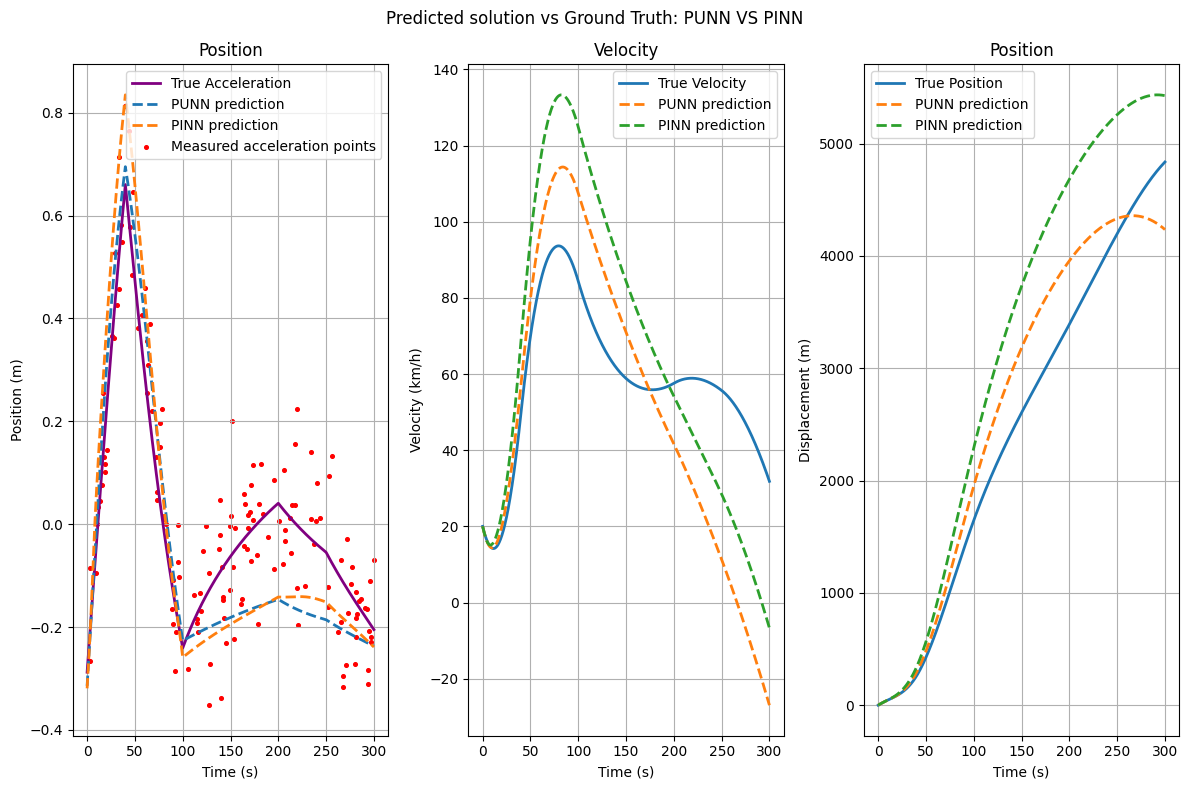

In [20]:
#PUNN
print("---PUNN---")
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
traj_true = np.hstack((Y_true, v_true.reshape(-1,1), x_true.reshape(-1,1))) #shape(t, 3) -> acceleration, velocity (km/h), position

punn_v_phy = np.zeros_like(t)
punn_x_phy = np.zeros_like(t)

#vectorized preodiction offline
punn_a_norm = punn_model.predict(X_norm)
punn_a_phy = scaler_Y.inverse_transform(punn_a_norm).flatten()

punn_v_phy = cumulative_trapezoid(y=punn_a_phy, dx=dt, initial=0)  # Velocity (m/s)
punn_v_phy += x0[1] #add initial condition (m/s)
punn_x_phy = cumulative_trapezoid(y=punn_v_phy, dx=dt, initial=0)  # Position (m)
punn_x_phy += x0[0] #add initial condition (m)

mse_a_norm = mean_squared_error(Y_true_norm, punn_a_norm)
mse_a_phy = mean_squared_error(Y_true, punn_a_phy)
mse_x, mse_v = mean_squared_error(x_true, punn_x_phy), mean_squared_error(v_true, punn_v_phy)

punn_a_phy = punn_a_phy.reshape(-1, 1)
punn_v_phy = punn_v_phy.reshape(-1,1)
punn_x_phy = punn_x_phy.reshape(-1,1)
punn_pred_data = np.hstack((punn_a_phy, punn_v_phy, punn_x_phy))

print(f"Normalized MSE/RMSE for acceleration: {mse_a_norm:.5e}, {np.sqrt(mse_a_norm):.5e}")
print(f"MSE/RMSE for acceleration: {mse_a_phy:.5e}, {np.sqrt(mse_a_phy):.5e}")
print(f"MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
print(f"MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

#PINN
print("---PINN---")
pinn_model = load_model("models/pinn_model_forward.h5", compile=False)  # Load model just for prediction
traj_true = np.hstack((Y_true, v_true.reshape(-1,1), x_true.reshape(-1,1))) #shape(t, 3) -> acceleration, velocity (km/h), position

pinn_v_phy = np.zeros_like(t)
pinn_x_phy = np.zeros_like(t)

#vectorized preodiction offline
pinn_a_norm = pinn_model.predict(X_norm)
pinn_a_phy = scaler_Y.inverse_transform(pinn_a_norm).flatten()

pinn_v_phy = cumulative_trapezoid(y=pinn_a_phy, dx=dt, initial=0)  # Velocity (m/s)
pinn_v_phy += x0[1] #add initial condition (m/s)
pinn_x_phy = cumulative_trapezoid(y=pinn_v_phy, dx=dt, initial=0)  # Position (m)
pinn_x_phy += x0[0] #add initial condition (m)

pinn_mse_a_norm = mean_squared_error(Y_true_norm, pinn_a_norm)
pinn_mse_a_phy = mean_squared_error(Y_true, pinn_a_phy)
pinn_mse_x, pinn_mse_v = mean_squared_error(x_true, pinn_x_phy), mean_squared_error(v_true, pinn_v_phy)

pinn_a_phy = pinn_a_phy.reshape(-1, 1)
pinn_v_phy = pinn_v_phy.reshape(-1,1)
pinn_x_phy = pinn_x_phy.reshape(-1,1)
pinn_pred_data = np.hstack((pinn_a_phy, pinn_v_phy, pinn_x_phy))

print(f"Normalized MSE/RMSE for acceleration: {pinn_mse_a_norm:.5e}, {np.sqrt(pinn_mse_a_norm):.5e}")
print(f"MSE/RMSE for acceleration: {pinn_mse_a_phy:.5e}, {np.sqrt(pinn_mse_a_phy):.5e}")
print(f"MSE/RMSE for velocity: {pinn_mse_v:.5e}, {np.sqrt(pinn_mse_v):.5e}")
print(f"MSE/RMSE for position: {pinn_mse_x:.5e}, {np.sqrt(pinn_mse_x):.5e}")

comparison_plot(t=t, true_data=traj_true, meas_data=Y_mask,
    pred_data=[(punn_pred_data, "PUNN prediction"), (pinn_pred_data, "PINN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN VS PINN"
)

